In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.cloud import bigquery;
from google.cloud.bigquery import dbapi;
%load_ext google.cloud.bigquery
from google.cloud import bigquery
from pdf2image import convert_from_path
from IPython.display import Image, display
# client=bigquery.Client()
client = bigquery.Client("som-nero-phi-jonc101")


/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(
/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Some utility functions

In [2]:
def find_unique_orders(df, return_combinations=False,):
    """
    Find the number of unique combinations of specific columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        return_combinations (bool): If True, return the unique combinations as a DataFrame.
                                   If False, return only the count of unique combinations.

    Returns:
        int or pd.DataFrame: The number of unique combinations or a DataFrame of unique combinations.
    """
    # Drop duplicates based on the specified columns
    subset = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
    unique_combinations = df.drop_duplicates(subset=subset)
    
    # Count the number of unique combinations
    num_unique_combinations = len(unique_combinations)
    
    # Return the result based on the return_combinations flag
    if return_combinations:
        return unique_combinations
    else:
        return num_unique_combinations

In [3]:
# Define a function to find antibiotic matches in the medication name
def find_antibiotics(med_name, antibiotic_list):
    if pd.isna(med_name):
        return None
    matches = [j for j in antibiotic_list if j.lower() in med_name.lower()]
    return matches if matches else "No Match"


In [12]:
# clean_antibiotic.csv is downloaded from the following URL: https://docs.google.com/spreadsheets/d/1NUBXLbMZ4n3A0-b-waVQGTOmcFSi0rSp/edit?gid=1568991887#gid=1568991887 
clean_antibiotic = pd.read_csv("../csv_folder/clean_antibiotic.csv") # the top 50 is the same as prior_antibiotics_list in bigquery
antibiotic_list = clean_antibiotic["antibiotic_name"]

In [449]:
cleaning_mapping = {
    # Original: Cleaned
    'Ceftriaxone': 'Ceftriaxone',
    'Sulfamethoxazole-Trimethoprim': 'Trimethoprim/Sulfamethoxazole',
    'Ciprofloxacin': 'Ciprofloxacin',
    'Ertapenem': 'Ertapenem',
    'Piperacillin-Tazobactam-Dextrs': 'Piperacillin/Tazobactam',
    'Piperacillin-Tazobactam': 'Piperacillin/Tazobactam',
    'Azithromycin': 'Azithromycin',
    'Doxycycline Hyclate': 'Doxycycline',
    'Ciprofloxacin In': 'Ciprofloxacin',
    'Vancomycin': 'Vancomycin',
    'Ciprofloxacin Hcl': 'Ciprofloxacin',
    'Cephalexin': 'Cephalexin/Cephalothin',
    'Cefazolin In Dextrose': 'Cefazolin',
    'Metronidazole In Nacl': 'Metronidazole',
    'Vancomycin In': 'Vancomycin',
    'Nitrofurantoin': 'Nitrofurantoin',
    'Metronidazole': 'Metronidazole',
    'Moxifloxacin': 'Moxifloxacin',
    'Cefepime': 'Cefepime',
    'Levofloxacin In': 'Levofloxacin',
    'Amoxicillin-Pot Clavulanate': 'Amoxicillin/Clavulanic Acid',
    'Ceftazidime-Dextrose': 'Ceftazidime',
    'Levofloxacin': 'Levofloxacin',
    'Rifaximin': 'Rifaximin',
    'Cefazolin': 'Cefazolin',
    'Cefpodoxime': 'Cefpodoxime',
    'Clindamycin In': 'Clindamycin',
    'Gentamicin': 'Gentamicin',
    'Rifampin': 'Rifampin',
    'Aztreonam': 'Aztreonam',
    'Meropenem': 'Meropenem',
    'Amoxicillin': 'Amoxicillin',
    'Linezolid': 'Linezolid',
    'Ampicillin': 'Ampicillin',
    'Cefdinir': 'Cefdinir',
    'Gentamicin-Sodium Citrate': 'Gentamicin',
    'Ethambutol': 'Ethambutol',
    'Rifabutin': 'Rifabutin',
    'Penicillin': 'Penicillin',
    'Cefoxitin': 'Cefoxitin',
    'Vancomycin In Dextrose': 'Vancomycin',
    'Clarithromycin': 'Clarithromycin',
    'Fidaxomicin': 'Fidaxomicin',
    'Trimethoprim': 'Trimethoprim',
    'Erythromycin': 'Erythromycin',
    'Isoniazid': 'Isoniazid',
    'Clindamycin Hcl': 'Clindamycin',
    'Aztreonam In': 'Aztreonam',
    'Ceftazidime': 'Ceftazidime',
    'Nitrofurantoin Macrocrystal': 'Nitrofurantoin',
    'Fosfomycin Tromethamine': 'Fosfomycin',
    'Erythromycin Ethylsuccinate': 'Erythromycin Ethylsuccinate',
    'Minocycline': 'Minocycline',
    'Ciprofloxacin-Dexamethasone': 'Ciprofloxacin',
    'Ofloxacin': 'Ofloxacin',
    'Silver Sulfadiazine': 'Silver Sulfadiazine',
    'Dicloxacillin': 'Dicloxacillin',
    'Clindamycin Phosphate': 'Clindamycin',
    'Tobramycin Sulfate': 'Tobramycin',
    'Tobramycin-Dexamethasone': 'Tobramycin',
    'Cefuroxime Axetil': 'Cefuroxime Axetil',
    'Dapsone': 'Dapsone',
    'Methenamine Hippurate': 'Methenamine',
    'Colistin': 'Colistin',
    'Cefadroxil': 'Cefadroxil',
    'Amikacin': 'Amikacin',
    'Gatifloxacin': 'Gatifloxacin',
    'Gentamicin In Nacl': 'Gentamicin'
}

# Previous Flowchart: some steps are off

<img src="../Aim_4_Cohort_Flowchart_previous/Aim_4_Cohort_Flowchart_previous.001.png" alt="Previous Adult ED Flowchart" width="500">

# Current Flowchart with updated steps and logic
## We will walk through step by step

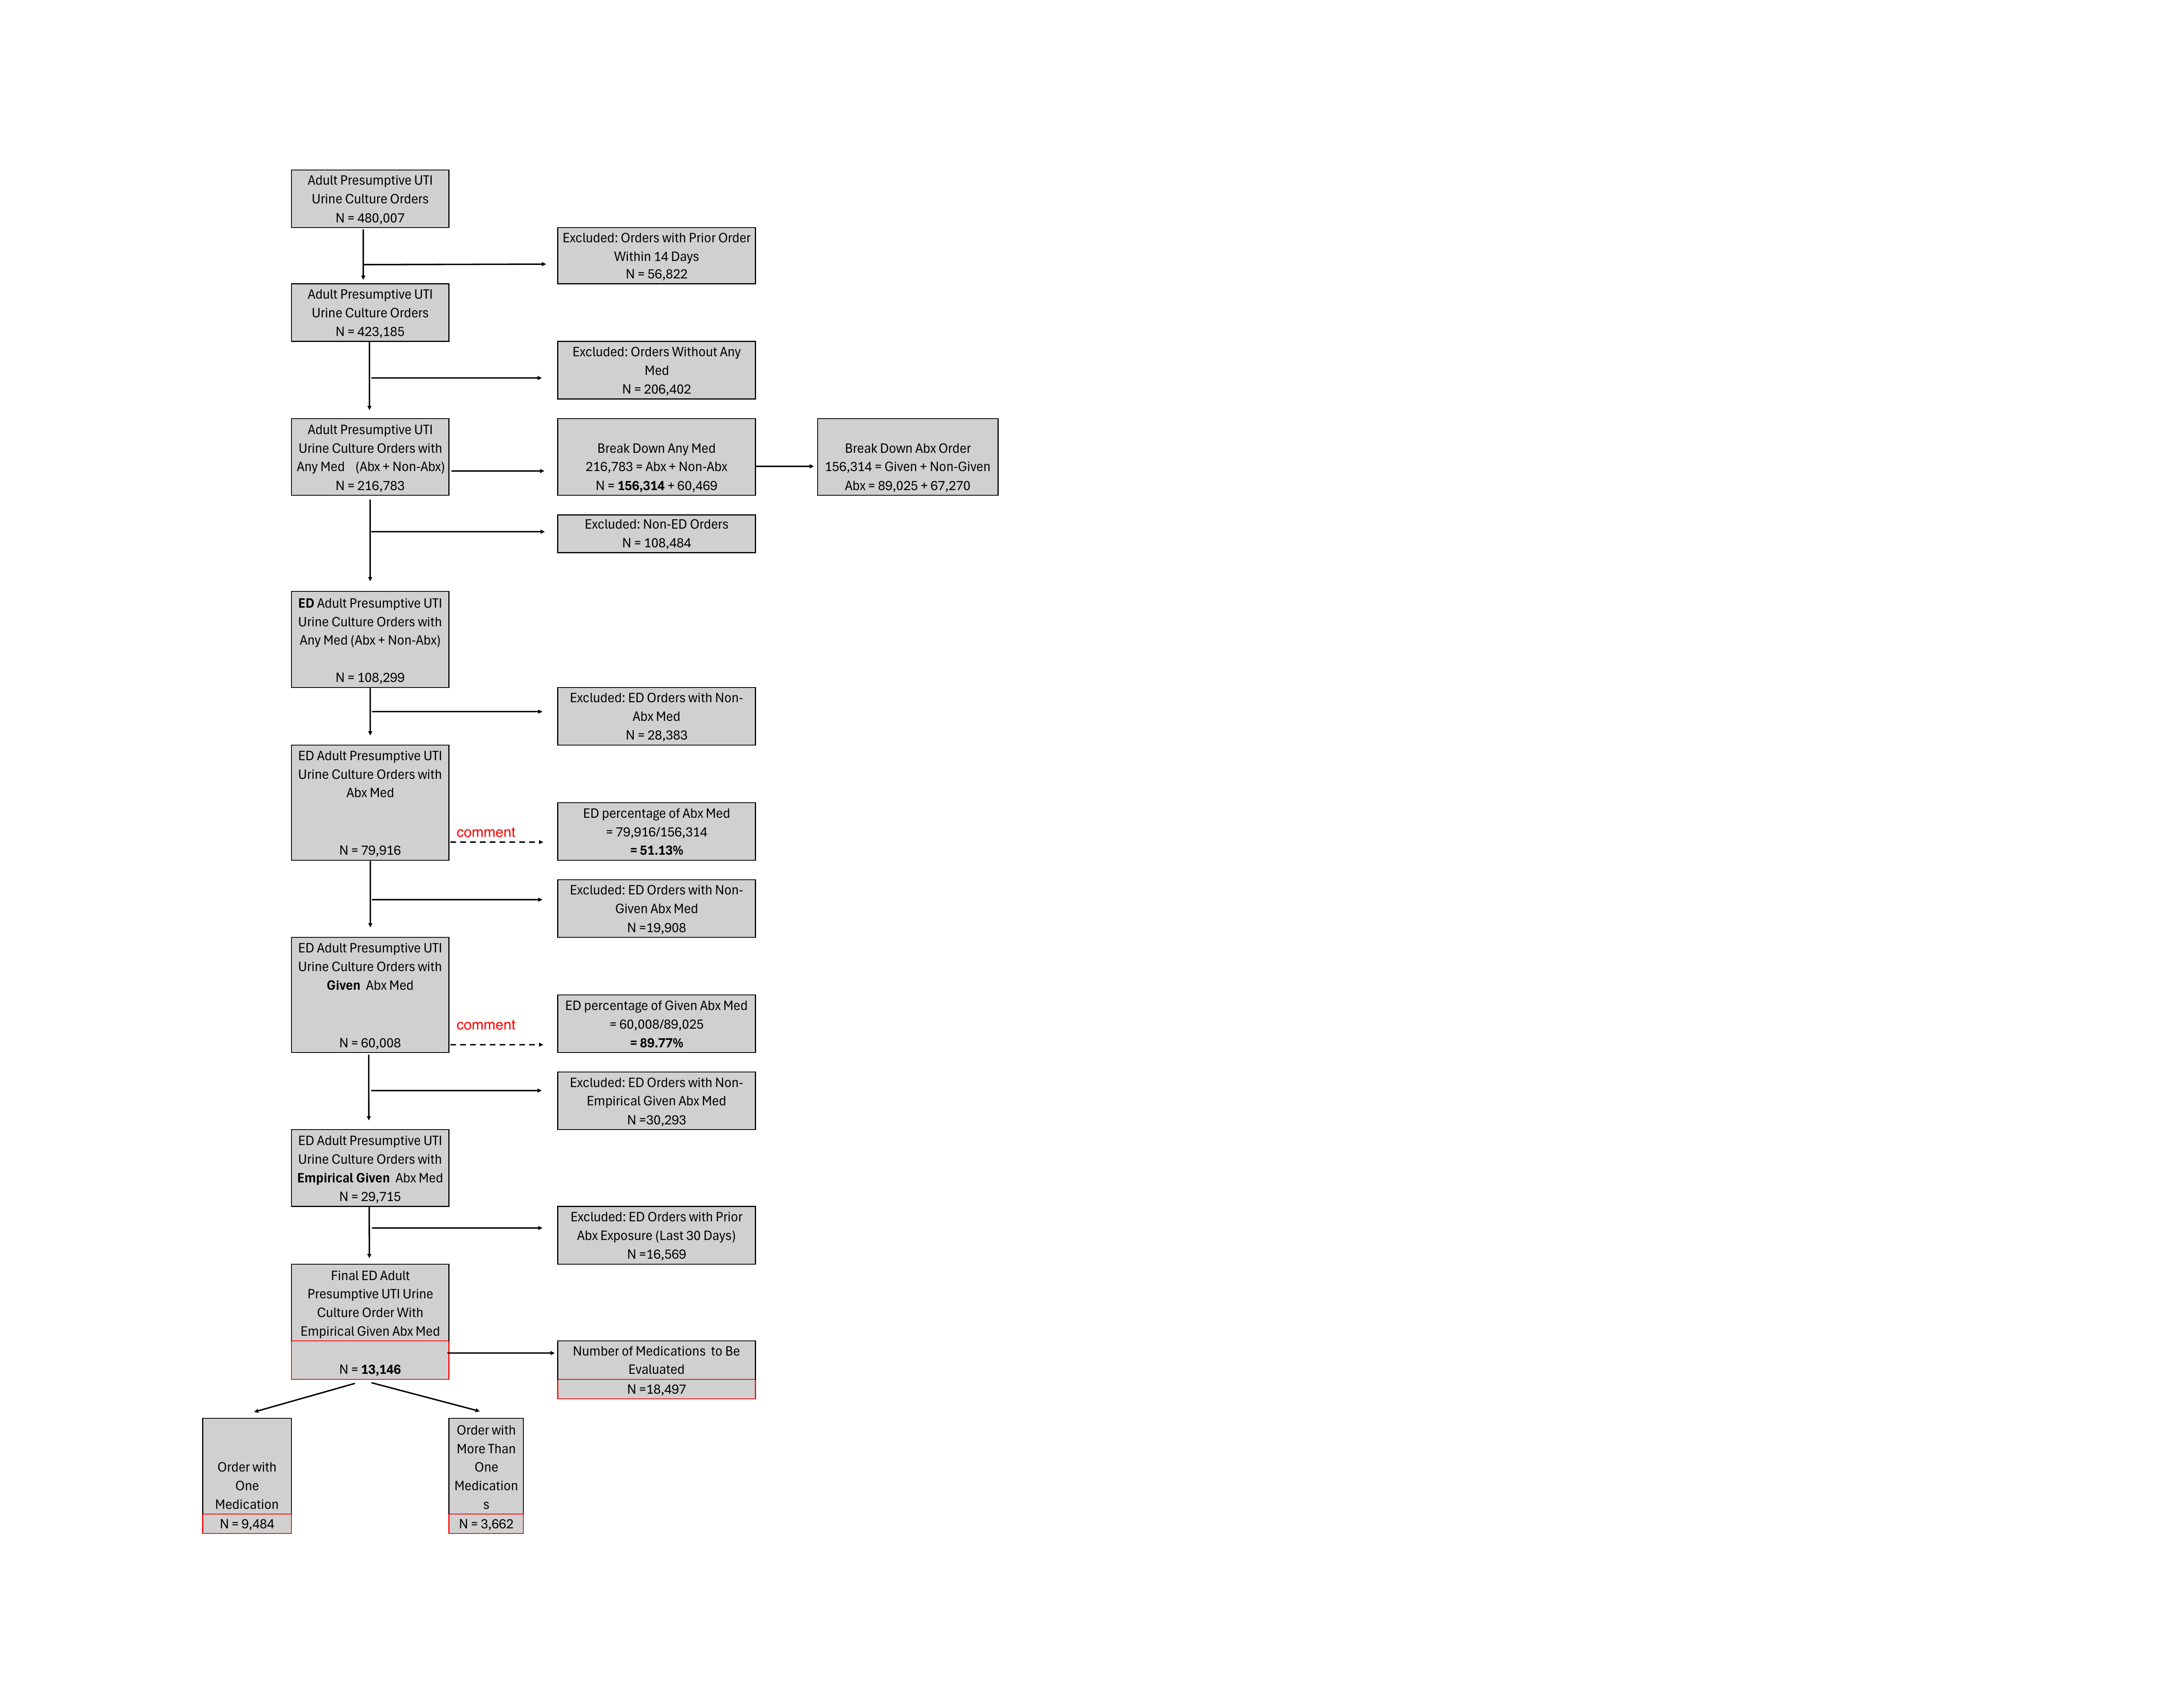

In [493]:
# Convert the first page of the PDF
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=500)
path_png = 'imgs/oervall.png'
pages[0].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ----------------------**Step 1** ------------------------

### Refactor Fateme's code for urine culture only
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_cohort_query.sql

In [473]:
%%bigquery --use_rest_api all_urine_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
        # check for urine culture ID
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) >= 18
        and 
)

select * from adult_microbiology_cultures


Query is running:   0%|          |

Downloading:   0%|          |

In [504]:
all_urine_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()

order_time_jittered_utc
1999       85
2000     2943
2001     2888
2002     2426
2003     2335
2004     2294
2005     2206
2006     2015
2007        1
2008    16122
2009    19489
2010    18549
2011    18155
2012    18334
2013    19024
2014    19759
2015    25299
2016    32936
2017    34957
2018    39314
2019    39048
2020    33811
2021    38240
2022    41856
2023    46894
2024     1027
Name: count, dtype: int64

In [544]:
find_unique_orders(all_urine_cohort[all_urine_cohort["order_time_jittered_utc"].dt.year >=2008])

462814

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

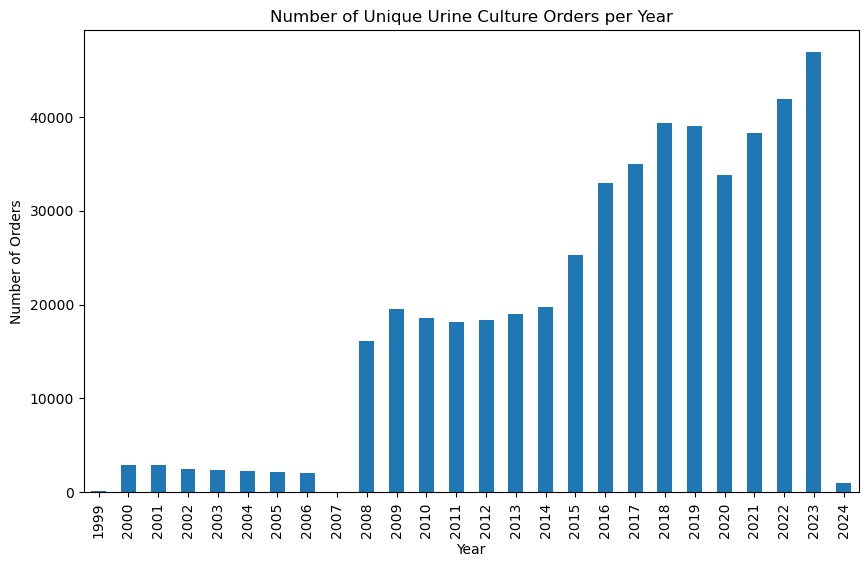

In [511]:
all_urine_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [474]:
print("the unique order number for all urine culture is {}".format(find_unique_orders(all_urine_cohort)))

the unique order number for all urine culture is 480007


# -----------------------**Step 2** ----------------------

In [16]:
%%bigquery --use_rest_api starting_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) >= 18
),

    
######################################################################################## 
-- Step 3: Identify culture orders within the prior two weeks
########################################################################################     
    
order_in_prior_two_weeks AS (
    SELECT DISTINCT
         auc.order_proc_id_coded
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    INNER JOIN
        adult_microbiology_cultures auc 
    ON
        op.anon_id = auc.anon_id
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
        AND auc.order_time_jittered_utc > op.order_time_jittered_utc
        AND TIMESTAMP_DIFF(auc.order_time_jittered_utc, op.order_time_jittered_utc, DAY) < 14
),

    
######################################################################################## 
-- Step 4: Exclude cultures with a prior culture order in the last two weeks
########################################################################################       

included_microbiology_cultures AS (
    SELECT DISTINCT
        amc.*
    FROM 
        adult_microbiology_cultures amc
    WHERE 
        amc.order_proc_id_coded NOT IN (SELECT order_proc_id_coded FROM order_in_prior_two_weeks)
),

###########################################################################################################
-- Step 5: Flag cultures as positive if they have corresponding entries in the culture_sensitivity table
###########################################################################################################    

all_cultures_with_flag AS (
    SELECT 
        imc.anon_id, 
        imc.pat_enc_csn_id_coded, 
        imc.order_proc_id_coded, 
        imc.order_time_jittered_utc, 
        imc.result_time_jittered_utc,
        imc.ordering_mode,
        imc.culture_description,
        IF(cs.order_proc_id_coded IS NOT NULL, 1, 0) AS was_positive
    FROM 
        included_microbiology_cultures imc
    LEFT JOIN 
        (SELECT DISTINCT order_proc_id_coded FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
    ON 
        imc.order_proc_id_coded = cs.order_proc_id_coded
),


#########################################################################################################################
-- Step 6: Get detailed information for positive cultures, clean antibiotic names, and exclude non-antibiotic entries
#########################################################################################################################     
positive_culture_details AS (
    SELECT 
        cs.order_proc_id_coded,
        cs.organism,
        -- Clean and standardize the antibiotic name using the updated cleaning approach
        INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )  AS antibiotic,
        cs.suscept AS susceptibility
    FROM 
        som-nero-phi-jonc101.shc_core_2023.culture_sensitivity cs
    INNER JOIN (
        -- Subquery to get antibiotic counts for those with more than 10 occurrences
        SELECT 
          INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )AS cleaned_antibiotic,
            COUNT(*) AS count
        FROM 
            som-nero-phi-jonc101.shc_core_2023.culture_sensitivity
        GROUP BY 
            cleaned_antibiotic
        HAVING 
            COUNT(*) >= 10  -- Include only antibiotics that appear 10 times or more
    ) AS antibiotic_counts 
    ON 


      INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )= antibiotic_counts.cleaned_antibiotic
    WHERE
        NOT (
            cs.antibiotic LIKE '%InBasket%'  
            OR cs.antibiotic LIKE '%Beta Lactamase%'  
            OR cs.antibiotic LIKE '%BlaZ PCR%'  
            OR cs.antibiotic LIKE '%Carbapenemase%'  
            OR cs.antibiotic LIKE '%D-Test%'  
            OR cs.antibiotic LIKE '%Esbl%'  
            OR cs.antibiotic LIKE '%ermPCR%'  
            OR cs.antibiotic LIKE '%Mupirocin%'  
            OR cs.antibiotic LIKE '%IMP%'  
            OR cs.antibiotic LIKE '%Inducible Clindamycin%'  
            OR cs.antibiotic LIKE '%INTERNAL CONTROL%'  
            OR cs.antibiotic LIKE '%KPC%'  
            OR cs.antibiotic LIKE '%MecA PCR%'  
            OR cs.antibiotic LIKE '%NDM%'  
            OR cs.antibiotic LIKE '%Ox Plate Screen%'  
            OR cs.antibiotic LIKE '%OXA-48-LIKE%'  
            OR cs.antibiotic LIKE '%VIM%'  
            OR cs.antibiotic LIKE '%Method%'  
            OR cs.antibiotic LIKE '%INH%'   
            OR cs.antibiotic LIKE '%Polymyxin B%' 
            OR cs.antibiotic LIKE '%Nalidixic%'   
            OR cs.antibiotic LIKE '%Flucytosine%' 
            OR cs.antibiotic LIKE '%Rifampin%' 
            OR cs.antibiotic LIKE '%Ethambutol%' 
            OR cs.antibiotic LIKE '%Pyrazinamide%' 
            OR cs.antibiotic LIKE '%Clofazimine%' 
            OR cs.antibiotic LIKE '%Rifabutin%' 
            OR cs.antibiotic IN ('Posaconazole','Penicillin/Ampicillin','Omadacycline', 'Amphotericin B', 'Polymixin B', 'Fluconazole', 'Itraconazole', 'Caspofungin', 'Voriconazole', 'Anidulafungin', 'Micafungin', 'Isavuconazole', 'Antibiotic', 'OXA48-LIKE PCR', 'ESBL confirmation test', 'Oxacillin Screen')
        )
)

#########################################################################################################################
  -- Step 7: Final selection of required fields
#########################################################################################################################   

SELECT 
    acwf.anon_id,
    acwf.pat_enc_csn_id_coded,
    acwf.order_proc_id_coded,
    acwf.order_time_jittered_utc,
    acwf.result_time_jittered_utc,
    acwf.ordering_mode,
    acwf.culture_description,
    acwf.was_positive,
    pcd.organism,
    pcd.antibiotic,
    CASE
        WHEN pcd.susceptibility IS NULL THEN NULL  -- Keep NULL values unchanged
        WHEN pcd.susceptibility IN ('Susceptible', 'Not Detected', 'Negative' ) THEN 'Susceptible'
        WHEN pcd.susceptibility IN ('Resistant', 'Non Susceptible', 'Positive', 'Detected') THEN 'Resistant'
        WHEN pcd.susceptibility IN ('Intermediate', 'Susceptible - Dose Dependent') THEN 'Intermediate'
        WHEN pcd.susceptibility IN ('No Interpretation', 'Not done', 'Inconclusive', 'See Comment') THEN 'Inconclusive'
        WHEN pcd.susceptibility IN ('Synergy', 'No Synergy') THEN 'Synergism'
        ELSE 'Unknown'  -- Mark unexpected values as Unknown
    END AS susceptibility
FROM
    all_cultures_with_flag acwf
LEFT JOIN
    positive_culture_details pcd
ON
    acwf.order_proc_id_coded = pcd.order_proc_id_coded
WHERE
    -- Exclude rows where susceptibility would be 'Unknown'
    (pcd.susceptibility IS NULL OR
    pcd.susceptibility IN ('Susceptible', 'Positive', 'Detected',
                           'Resistant', 'Non Susceptible', 'Negative',
                           'Intermediate', 'Susceptible - Dose Dependent',
                           'No Interpretation', 'Not done', 'Inconclusive', 'See Comment',
                           'Synergy', 'No Synergy', 'Not Detected'));


Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
print("the unique order number for urine only starting culture after 2 week exclusion is {}".format(find_unique_orders(starting_cohort)))

the unique order number for urine only starting culture after 2 week exclusion is 423185


In [545]:
find_unique_orders(starting_cohort[starting_cohort["order_time_jittered_utc"].dt.year >= 2008])

407116

In [500]:
starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()

order_time_jittered_utc
1999        78
2000      2710
2001      2702
2002      2280
2003      2180
2004      2146
2005      2086
2006      1886
2007        10
2008     38361
2009     47177
2010     46623
2011     48016
2012     49325
2013     56963
2014     65704
2015     90290
2016    120577
2017    203057
2018    202033
2019    207595
2020    176787
2021    203354
2022    224530
2023    240516
2024      4833
Name: count, dtype: int64

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

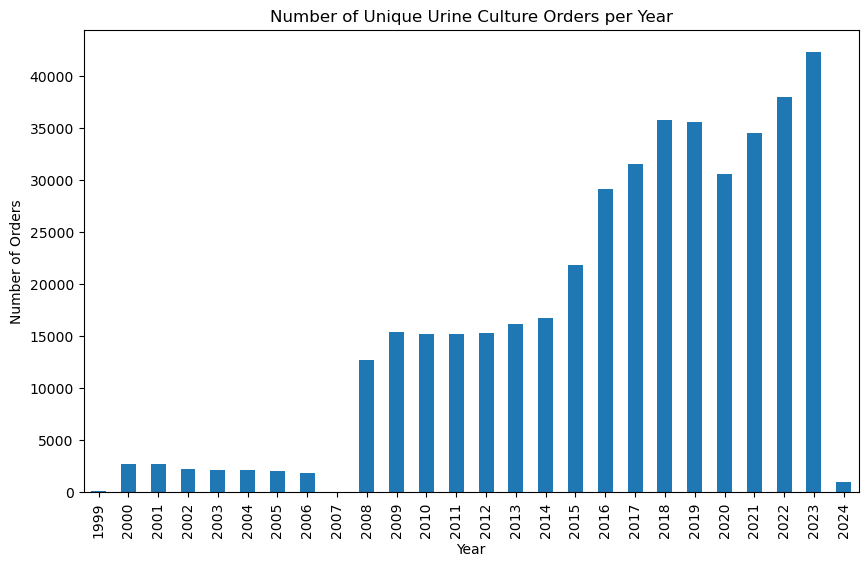

In [510]:
unique_order_starting_cohort = starting_cohort.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# find_unique_orders(unique_order_starting_cohort)
# 423185
unique_order_starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

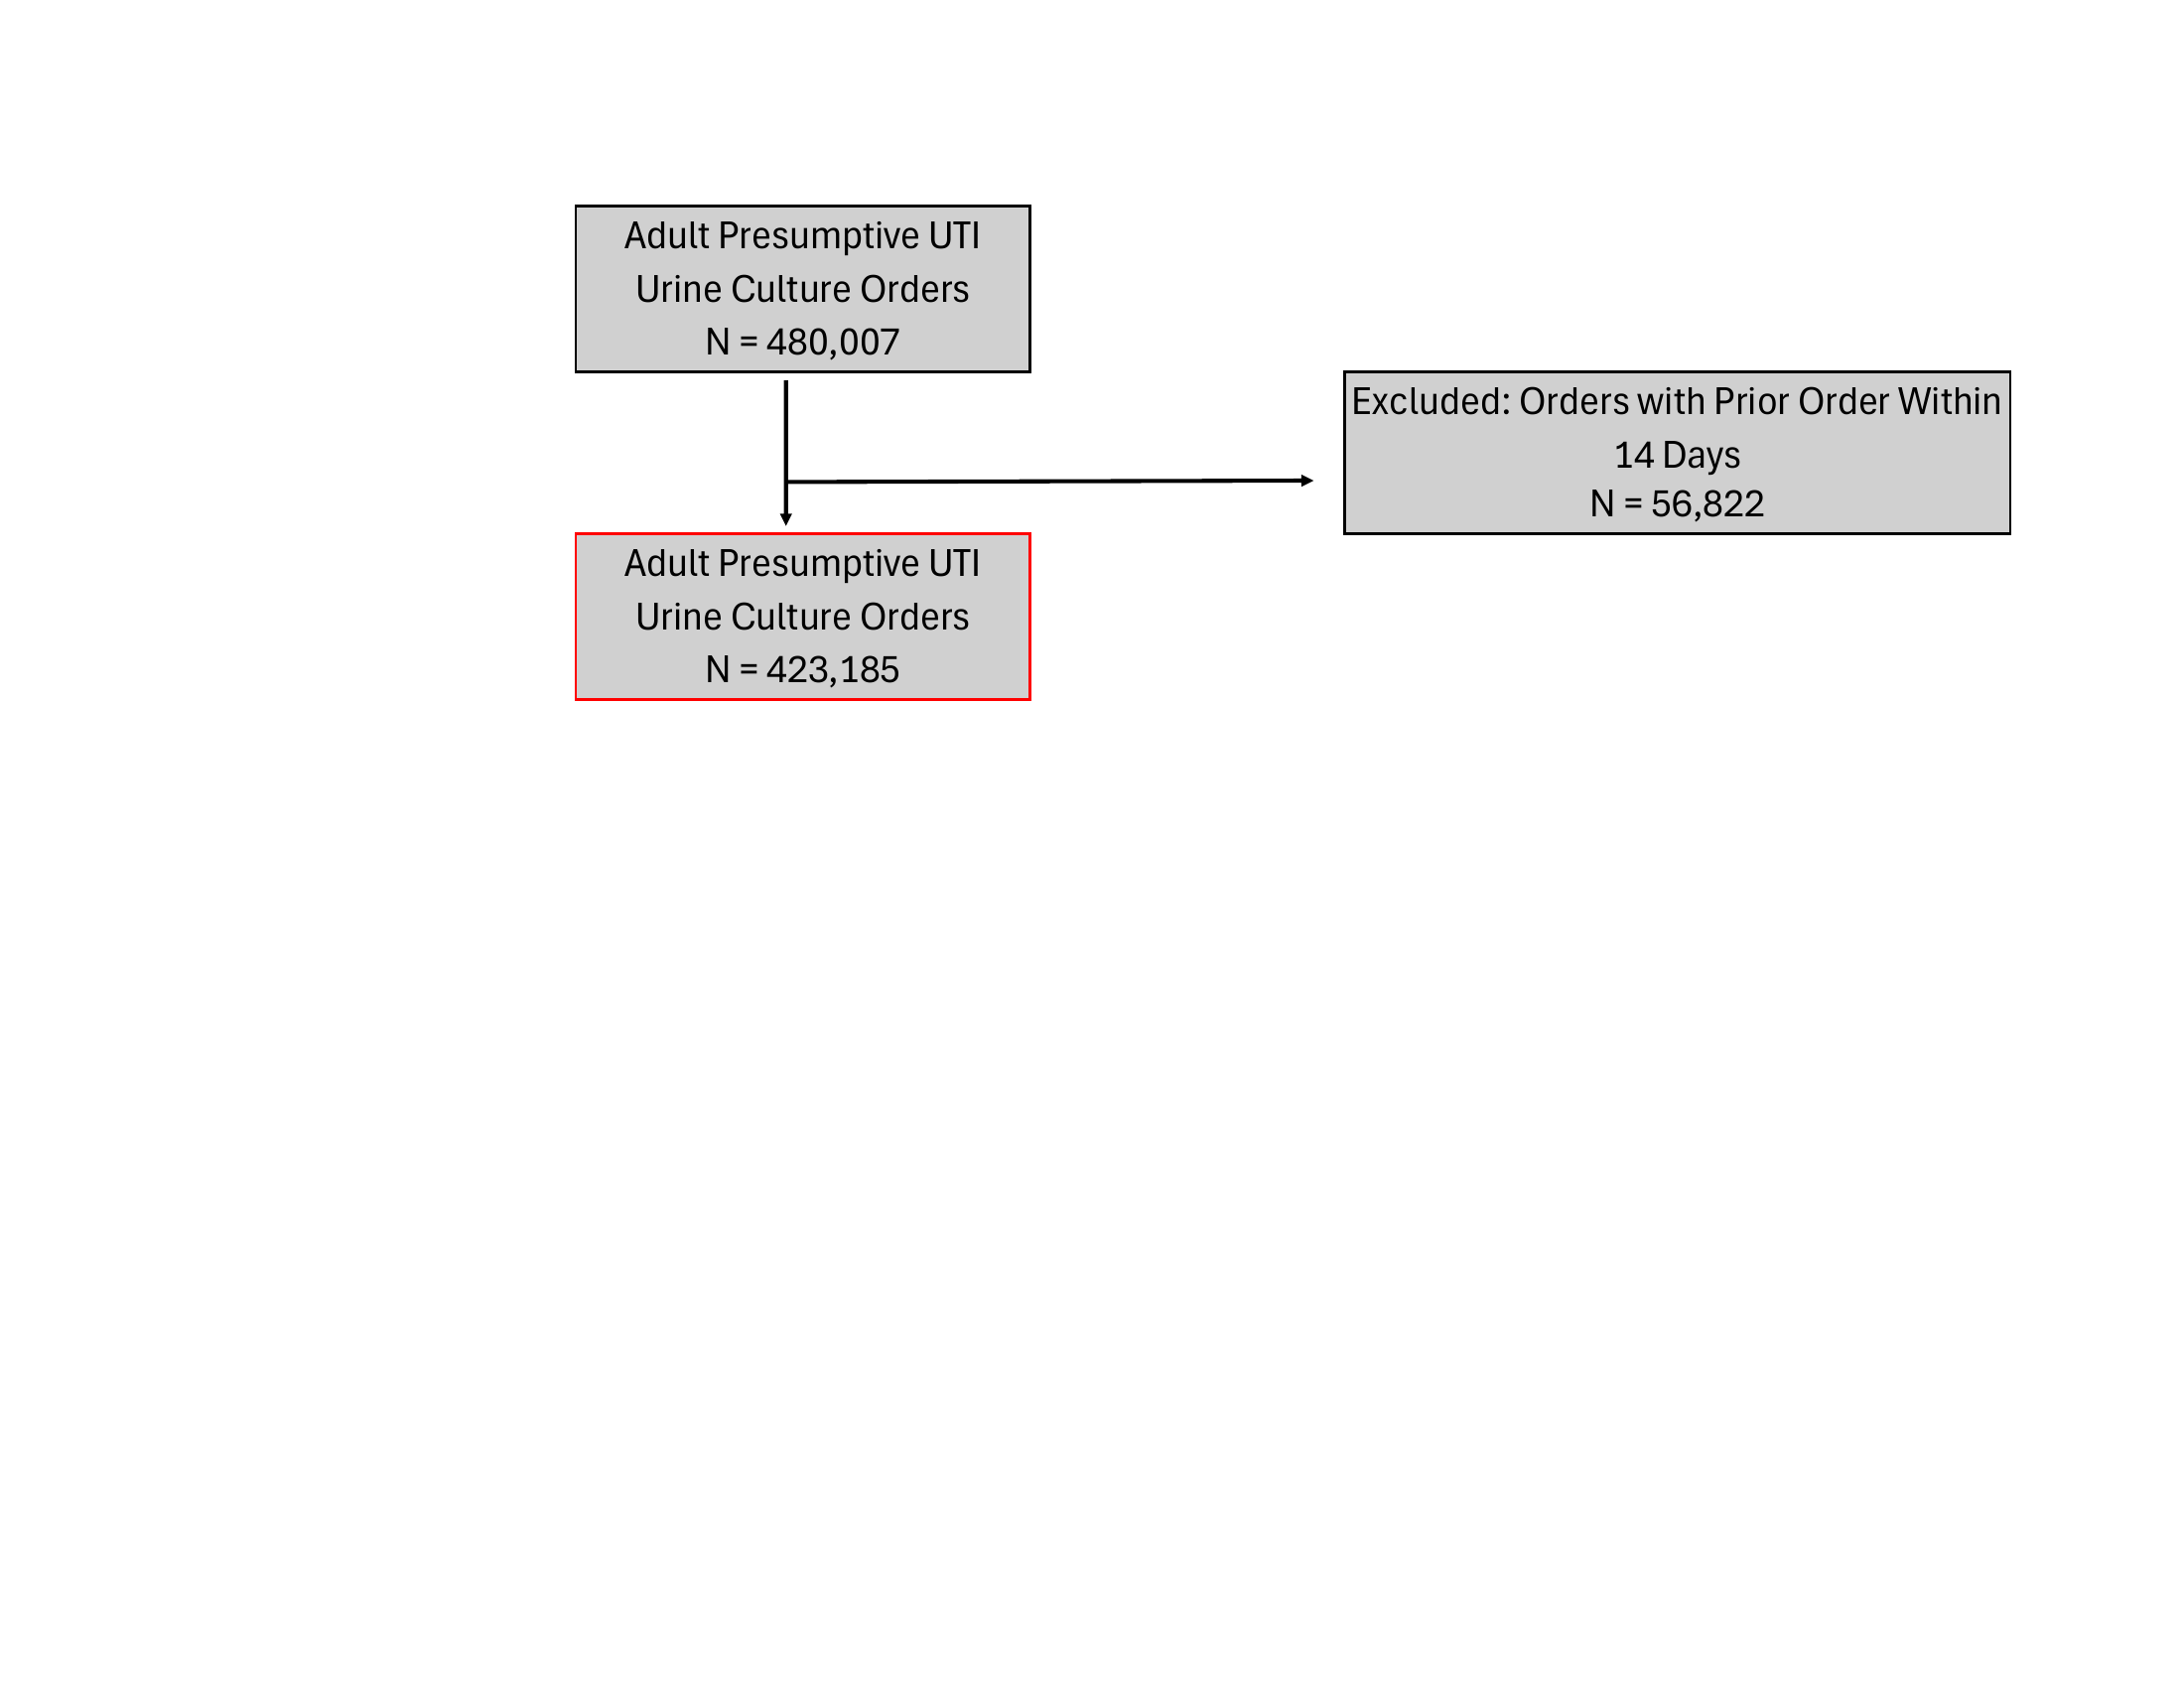

In [477]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step1-2.png'
pages[1].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))


# ---------------------**Step 3** -----------------------

## 🔍 Verifying Current Medications in the Cohort

To analyze the **current (empirical + non-empirical) medications** for the orders in the above cohort, I applied the following steps:

### ✅ Methodology:
1. **Filtered for current medications only** to focus on active prescriptions.  
2. **Retained the original medication names** without using `regex_express` for modifications.  
3. **Incorporated pharmacy data** (`pharmacy_mar`) after the weekly meeting on **March 20th** to determine whether the ordered medication was actually administered.  

This ensures a more accurate representation of **prescribed vs. administered medications** in the dataset. 🚀

In [ ]:
%%bigquery --use_rest_api current_med_original_no_mapped
##############################################################################################################################################################
# Goal:Creating the microbiology_cultures_prior_med_augmented Table. This table indicates of a patient having been treated with a specific antibiotic before specimen collection.
##############################################################################################################################################################
# CREATE OR REPLACE TABLE `som-nero-phi-jonc101.antimicrobial_stewardship.microbiology_cultures_prior_med_augmented` AS (
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
        # INITCAP(
        #     REGEXP_REPLACE(
        #         REGEXP_REPLACE(
        #             TRIM(
        #                 REGEXP_REPLACE(
        #                     REGEXP_REPLACE(
        #                         REGEXP_REPLACE(
        #                             LOWER(mm.name),  -- Convert to lowercase
        #                             '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
        #                         ),
        #                         '\\(.*?\\)', ''  -- Remove text in parentheses
        #                     ),
        #                     ' in.*$|tablet|capsule|intravenous|piggyback|' ||
        #                     'solution|suspension|oral|sodium|chloride|' ||
        #                     'injection|citrate|soln|dextrose|iv|' ||
        #                     'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
        #                     'monohydrate|ethylsuccinate|powder|mandelate|' ||
        #                     'hyclate|hcl|hippurate|tromethamine|' ||
        #                     'million|unit|syrup|chewable|delayed|mphase|' ||
        #                     'release|benzathine|syringe|dispersible|' ||
        #                     'sulfate|procaine|blue|hyos|sod*phos|' ||
        #                     'susp|and|fosamil|extended|succinate|granules|' ||
        #                     'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
        #                     'sodphos|methylene|stearate|synergy', ''  -- Remove pharmacy filler words and "synergy"
        #                 )
        #             ),
        #             '\\d|\\sfor\\s*|\\ser\\s*|\\shr\\s*|/ml\\s*|' ||
        #             '\\sml\\s*|\\sv\\s*|\\sg\\s*|\\sim\\s*', ''  -- General cleaning for non-relevant patterns
        #         ),
        #         '\\s|\\/|\\.|-$', ''  -- Remove extra characters like spaces, slashes, dots, etc.
        #     )
        # ) AS medication_name,
        # TIMESTAMP_DIFF(c.order_time_jittered_utc,mo.ordering_date_jittered_utc,day) as medication_time_to_cultureTime,       
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        # using(anon_id, pat_enc_csn_id_coded) # I added "pat_enc_csn_id_coded" to search for current medications
        using(anon_id, and +- 12 hours)
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # I incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
)

select * 
from cleaned_medications 
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time,medication_name,order_med_id_coded, medication_action
order by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time,medication_name,order_med_id_coded, medication_action

Query is running:   0%|          |

Downloading:   0%|          |

In [523]:
%%bigquery --use_rest_api current_med_original_no_mapped_with_12_hours
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
        # INITCAP(
        #     REGEXP_REPLACE(
        #         REGEXP_REPLACE(
        #             TRIM(
        #                 REGEXP_REPLACE(
        #                     REGEXP_REPLACE(
        #                         REGEXP_REPLACE(
        #                             LOWER(mm.name),  -- Convert to lowercase
        #                             '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
        #                         ),
        #                         '\\(.*?\\)', ''  -- Remove text in parentheses
        #                     ),
        #                     ' in.*$|tablet|capsule|intravenous|piggyback|' ||
        #                     'solution|suspension|oral|sodium|chloride|' ||
        #                     'injection|citrate|soln|dextrose|iv|' ||
        #                     'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
        #                     'monohydrate|ethylsuccinate|powder|mandelate|' ||
        #                     'hyclate|hcl|hippurate|tromethamine|' ||
        #                     'million|unit|syrup|chewable|delayed|mphase|' ||
        #                     'release|benzathine|syringe|dispersible|' ||
        #                     'sulfate|procaine|blue|hyos|sod*phos|' ||
        #                     'susp|and|fosamil|extended|succinate|granules|' ||
        #                     'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
        #                     'sodphos|methylene|stearate|synergy', ''  -- Remove pharmacy filler words and "synergy"
        #                 )
        #             ),
        #             '\\d|\\sfor\\s*|\\ser\\s*|\\shr\\s*|/ml\\s*|' ||
        #             '\\sml\\s*|\\sv\\s*|\\sg\\s*|\\sim\\s*', ''  -- General cleaning for non-relevant patterns
        #         ),
        #         '\\s|\\/|\\.|-$', ''  -- Remove extra characters like spaces, slashes, dots, etc.
        #     )
        # ) AS medication_name,
        # TIMESTAMP_DIFF(c.order_time_jittered_utc,mo.ordering_date_jittered_utc,day) as medication_time_to_cultureTime,       
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        ON mo.anon_id = c.anon_id
        AND ((mo.pat_enc_csn_id_coded = c.pat_enc_csn_id_coded) or (ABS(TIMESTAMP_DIFF(mo.ordering_date_jittered_utc, c.order_time_jittered_utc, HOUR)) <= 12))
        -- using(anon_id, pat_enc_csn_id_coded) # I added "pat_enc_csn_id_coded" to search for current medications
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # I incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
)

select *
from cleaned_medications 
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time, medication_name,order_med_id_coded, medication_action
order by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time,medication_name,order_med_id_coded, medication_action

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

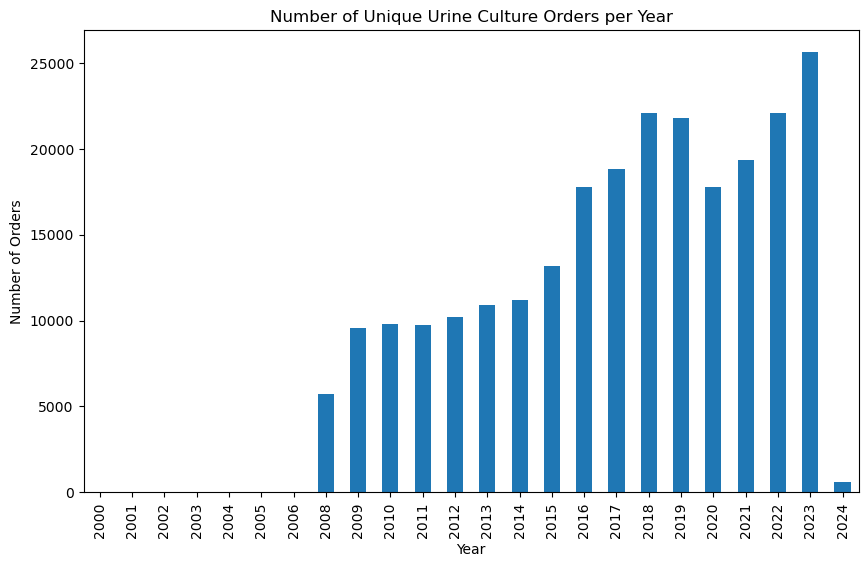

In [ ]:
current_med_original_no_mapped_with_12_hours[current_med_original_no_mapped_with_12_hours["medication_name"].notnull()]\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])\
        ["order_time_jittered_utc"].dt.year.value_counts().sort_index()\
            .plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))


In [524]:
current_med_original_no_mapped_with_12_hours

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action
0,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,NaT,None,None,None
1,JC1000013,15174722,302914865,2008-04-11 23:45:00+00:00,2008-04-13 02:50:00+00:00,NaT,None,None,None
2,JC1000021,32992898,351382857,2009-06-06 23:12:00+00:00,2009-06-09 00:00:00+00:00,NaT,None,None,None
3,JC1000021,131009159044,366795029,2010-05-29 23:22:00+00:00,2010-06-01 00:13:00+00:00,2010-05-29 07:00:00+00:00,MONTELUKAST 10 MG PO TABS,None,None
4,JC1000022,15142402,323829550,2008-03-13 03:50:00+00:00,2008-03-14 03:14:00+00:00,NaT,None,None,None
...,...,...,...,...,...,...,...,...,...
13123641,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,2015-08-20 07:00:00+00:00,HELP ORDER,None,None
13123642,JC999925,131107270857,471989931,2015-08-09 09:12:00+00:00,2015-08-11 14:59:00+00:00,2015-08-20 07:00:00+00:00,SERTRALINE 50 MG PO TABS,None,None
13123643,JC999935,14537303,312599852,2005-07-23 19:47:00+00:00,2005-07-25 18:27:00+00:00,NaT,None,None,None
13123644,JC999992,131189547541,497201103,2016-06-06 03:57:00+00:00,2016-06-08 00:36:00+00:00,2016-06-06 07:00:00+00:00,CEPHALEXIN 500 MG PO CAPS,None,None


In [18]:
%%bigquery --use_rest_api current_med_original_no_mapped
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.current_med_original_no_mapped

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
# we check the unique order number for current_med_original_no_mapped and starting_cohort
assert find_unique_orders(current_med_original_no_mapped) == find_unique_orders(starting_cohort), "Unique order counts do not match between current_med_original_no_mapped and starting_cohort"

In [20]:
current_med_original_no_mapped

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action
0,JC974754,131357518268,892830862,2023-08-21 19:09:00+00:00,2023-08-24 14:37:00+00:00,2023-09-01 07:00:00+00:00,BARIUM SULFATE 40 % (W/V) PO SUSP,895171572.000000000,Contrast Given
1,JC974754,131362754143,917579871,2023-12-05 07:28:00+00:00,2023-12-07 16:09:00+00:00,2023-10-27 07:00:00+00:00,OSMOLITE 1.5 CYCLIC TUBE FEEDING,908239129.000000000,Start Cyclic TF
2,JC977584,131233935900,528293337,2017-06-30 13:04:00+00:00,2017-07-02 15:22:00+00:00,2017-07-01 07:00:00+00:00,DIATRIZOATE MEGLUMINE & NA (GASTROGRAFIN) (RAD...,528493678.000000000,Contrast Given
3,JC978582,131301129094,704066677,2021-01-02 18:18:00+00:00,2021-01-05 00:29:00+00:00,2021-02-03 08:00:00+00:00,FENTANYL CITRATE (PF) 50 MCG/ML INJ SOLN (WRAP...,710344528.000000000,Given by Physician
4,JC979028,131298918545,693926728,2020-10-29 22:58:00+00:00,2020-10-31 23:46:00+00:00,2020-10-30 07:00:00+00:00,OSMOLITE 1.2 CONTINUOUS TUBE FEEDING,694146665.000000000,New Bottle/Bag for Tube Feeding
...,...,...,...,...,...,...,...,...,...
12834705,JC1748747,131356656272,884619554,2023-06-26 23:08:00+00:00,2023-06-28 16:58:00+00:00,2023-07-05 07:00:00+00:00,MAGNESIUM SULFATE IN D5W 1 GRAM/100 ML IV PGBK...,886611992.000000000,Stopped
12834706,JC1752003,131066298777,458165223,2015-02-11 01:29:00+00:00,2015-02-13 22:34:00+00:00,2015-01-18 08:00:00+00:00,TPN ADULT STANDARD,456609238.000000000,Stopped
12834707,JC1755607,131258175603,579000755,2018-09-08 16:26:00+00:00,2018-09-10 15:54:00+00:00,2018-09-08 07:00:00+00:00,LACTATED RINGERS IV SOLP,579020479.000000000,Stopped
12834708,JC1755708,131071680488,456696652,2015-02-20 09:18:00+00:00,2015-02-21 19:34:00+00:00,2015-02-20 08:00:00+00:00,NOREPINEPHRINE IV INFUSION,456697510.000000000,Stopped


In [24]:
current_med_original_no_mapped["medication_action"].value_counts()

medication_action
Given                    4419561
Missed                   1105033
New Bag                  1020777
Completed                 477302
Rate Verify               454898
                          ...   
Oral Contrast Started         20
L&D Rate Change                5
Downtime/New Syringe           4
Leech(es) removed              1
Leech(es) applied              1
Name: count, Length: 72, dtype: int64

# --------------------- Step 3.1 -----------------------

## 🛠️ Cleaning Up Medication Categories

### Since the original names were retained, I will now categorize the medications into **antibiotic** and **non-antibiotic** groups.

### 📌 Legend:
- **None** → No medication prescribed  
- **No Match** → A **non-antibiotic** medication was prescribed  
- **Else** → An **antibiotic** medication was prescribed  

In [26]:
# this line is to clean the medication
current_med_original_no_mapped["cleaned_antibiotic"] = current_med_original_no_mapped["medication_name"].apply(
    lambda x: find_antibiotics(x, antibiotic_list)
)

In [527]:
current_med_original_no_mapped_with_12_hours["cleaned_antibiotic"] = current_med_original_no_mapped_with_12_hours["medication_name"].apply(
    lambda x: find_antibiotics(x, antibiotic_list)
)

In [264]:
# current_med_original_no_mapped.iloc[135:147]

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
135,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MAGNESIUM SULFATE IN D5W 1 GRAM/100 ML IV PGBK,None,None,No Match
136,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MAGNESIUM SULFATE IN WATER 2 GRAM/50 ML (4 %) ...,None,None,No Match
137,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,None,None,[Meropenem]
138,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Completed,[Meropenem]
139,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,New Bag,[Meropenem]
140,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Paused,[Meropenem]
141,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Rate Change,[Meropenem]
142,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Rate Verify,[Meropenem]
143,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MEROPENEM 1 GRAM/50 ML NS MINIBAG PLUS,877049773.000000000,Restarted,[Meropenem]
144,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-24 07:00:00+00:00,MULTIVITAMIN (GENERIC) PO TABS,877243176.000000000,Given,No Match


<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

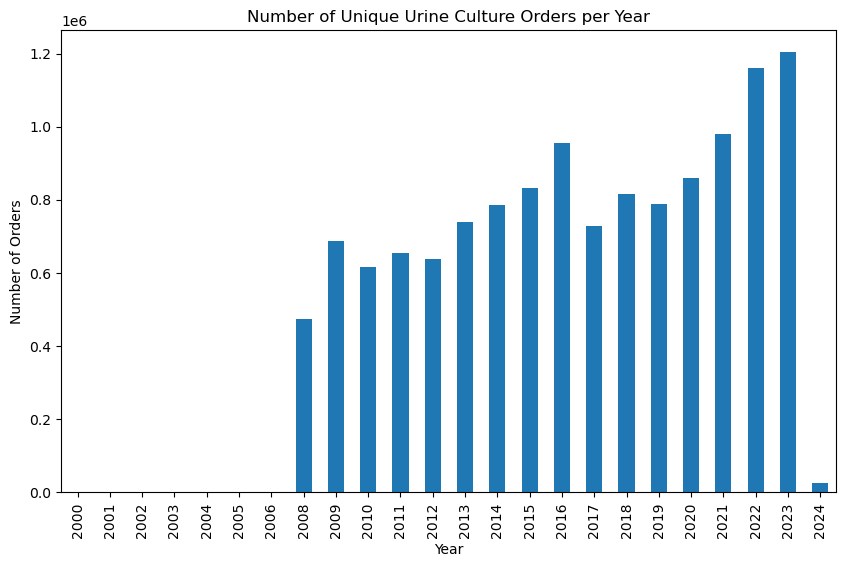

In [550]:
current_med_original_no_mapped_with_12_hours[current_med_original_no_mapped_with_12_hours["medication_time"].notnull()]["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [534]:
current_med_original_no_mapped[current_med_original_no_mapped["order_time_jittered_utc"].dt.year < 2008]
# ["medication_name"].isnull().sum()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
12866,JC994995,14535371,312485784,2006-04-21 20:02:00+00:00,2006-04-23 16:55:00+00:00,NaT,None,None,None,None
13473,JC537087,6855947,312894742,2001-12-04 19:31:00+00:00,2001-12-07 19:13:00+00:00,NaT,None,None,None,None
13580,JC550813,6686238,306496283,2003-08-25 02:00:00+00:00,2003-09-01 18:56:00+00:00,NaT,None,None,None,None
13910,JC555662,6642634,312823271,2005-11-28 00:26:00+00:00,2005-11-29 18:29:00+00:00,NaT,None,None,None,None
13911,JC555740,6671255,313533210,2001-09-19 15:40:00+00:00,2001-09-20 17:20:00+00:00,NaT,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
12597425,JC515815,6621421,308475943,2004-11-03 16:05:00+00:00,2004-11-05 18:49:00+00:00,NaT,None,None,None,None
12597478,JC521516,14475935,312319559,2001-12-13 22:50:00+00:00,2001-12-17 19:22:00+00:00,NaT,None,None,None,None
12597502,JC523895,14472793,309433289,2000-04-04 23:17:00+00:00,2000-04-06 17:20:00+00:00,NaT,None,None,None,None
12597569,JC532104,6633957,312714822,2001-02-03 16:32:00+00:00,2001-02-05 19:36:00+00:00,NaT,None,None,None,None


In [529]:
culture_order_with_any_given_cur_med_with_12_hours =  current_med_original_no_mapped_with_12_hours[(current_med_original_no_mapped_with_12_hours["cleaned_antibiotic"].notnull()) & (current_med_original_no_mapped_with_12_hours["medication_action"] == "Given")]
print("the unique order number for culture_order_with_any_given_cur_med is {}".format(find_unique_orders(culture_order_with_any_given_cur_med_with_12_hours)))
culture_order_with_abx_med_given_12_hours = culture_order_with_any_given_cur_med_with_12_hours[culture_order_with_any_given_cur_med_with_12_hours["cleaned_antibiotic"] != "No Match"]
print("the unique order number for culture_order_with_abx_med is {}".format(find_unique_orders(culture_order_with_abx_med_given_12_hours)))

the unique order number for culture_order_with_any_given_cur_med is 140880
the unique order number for culture_order_with_abx_med is 92257


<Axes: title={'center': 'Number of Unique Urine Culture Orders with Given Abx Med per Year'}, xlabel='Year', ylabel='Number of Orders'>

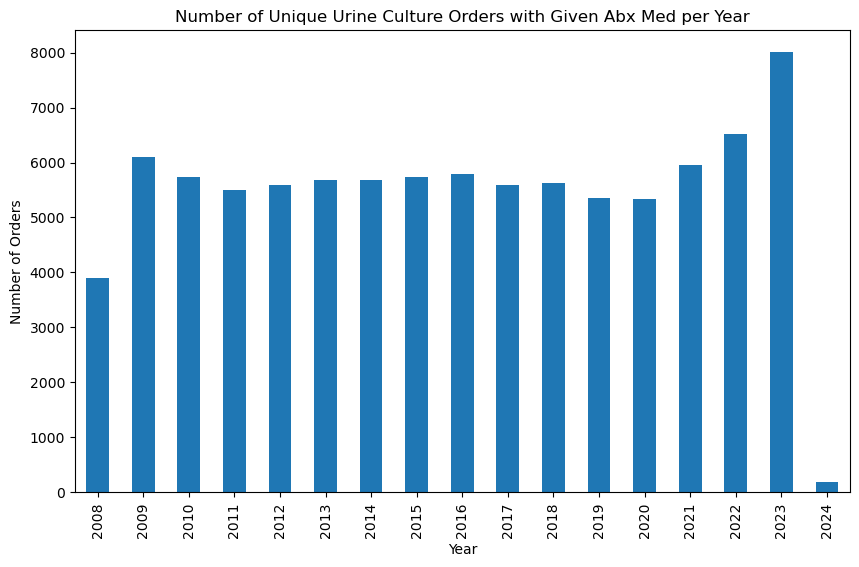

In [562]:
nique_order_culture_order_with_abx_med_given_12_hours = culture_order_with_abx_med_given_12_hours.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
nique_order_culture_order_with_abx_med_given_12_hours["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders with Given Abx Med per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

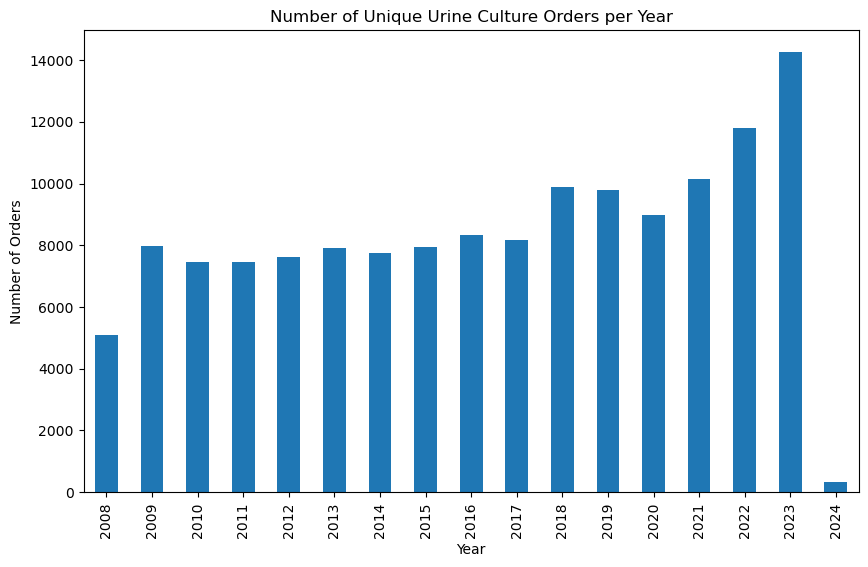

In [531]:
unique_order_culture_order_with_any_given_cur_med_12hours = culture_order_with_any_given_cur_med_with_12_hours.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
unique_order_culture_order_with_any_given_cur_med_12hours["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [516]:
culture_order_with_any_given_cur_med =  current_med_original_no_mapped[(current_med_original_no_mapped["cleaned_antibiotic"].notnull()) & (current_med_original_no_mapped["medication_action"] == "Given")]
print("the unique order number for culture_order_with_any_given_cur_med is {}".format(find_unique_orders(culture_order_with_any_given_cur_med)))

the unique order number for culture_order_with_any_given_cur_med is 135423


<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

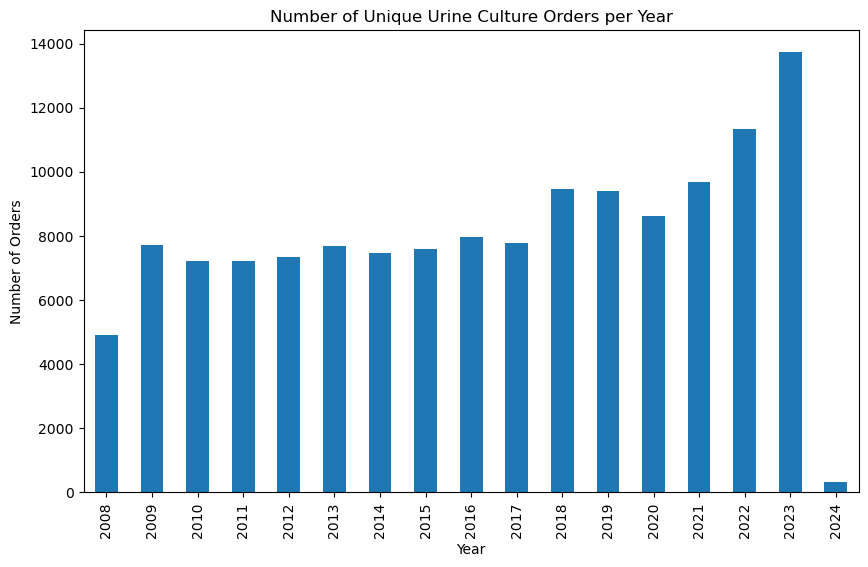

In [522]:
unique_order_culture_order_with_any_given_cur_med = culture_order_with_any_given_cur_med.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
unique_order_culture_order_with_any_given_cur_med["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [ ]:
culture_order_with_any_cur_med =  current_med_original_no_mapped[(current_med_original_no_mapped["cleaned_antibiotic"].notnull())]
culture_order_without_any_cur_med =  current_med_original_no_mapped[current_med_original_no_mapped["cleaned_antibiotic"].isnull()]
print("the unique order number for culture_order_with_any_cur_med is {}".format(find_unique_orders(culture_order_with_any_cur_med)))
print("the unique order number for culture_order_without_any_cur_med is {}".format(find_unique_orders(culture_order_without_any_cur_med)))

the unique order number for culture_order_with_any_cur_med is 216783
the unique order number for culture_order_without_any_cur_med is 206402


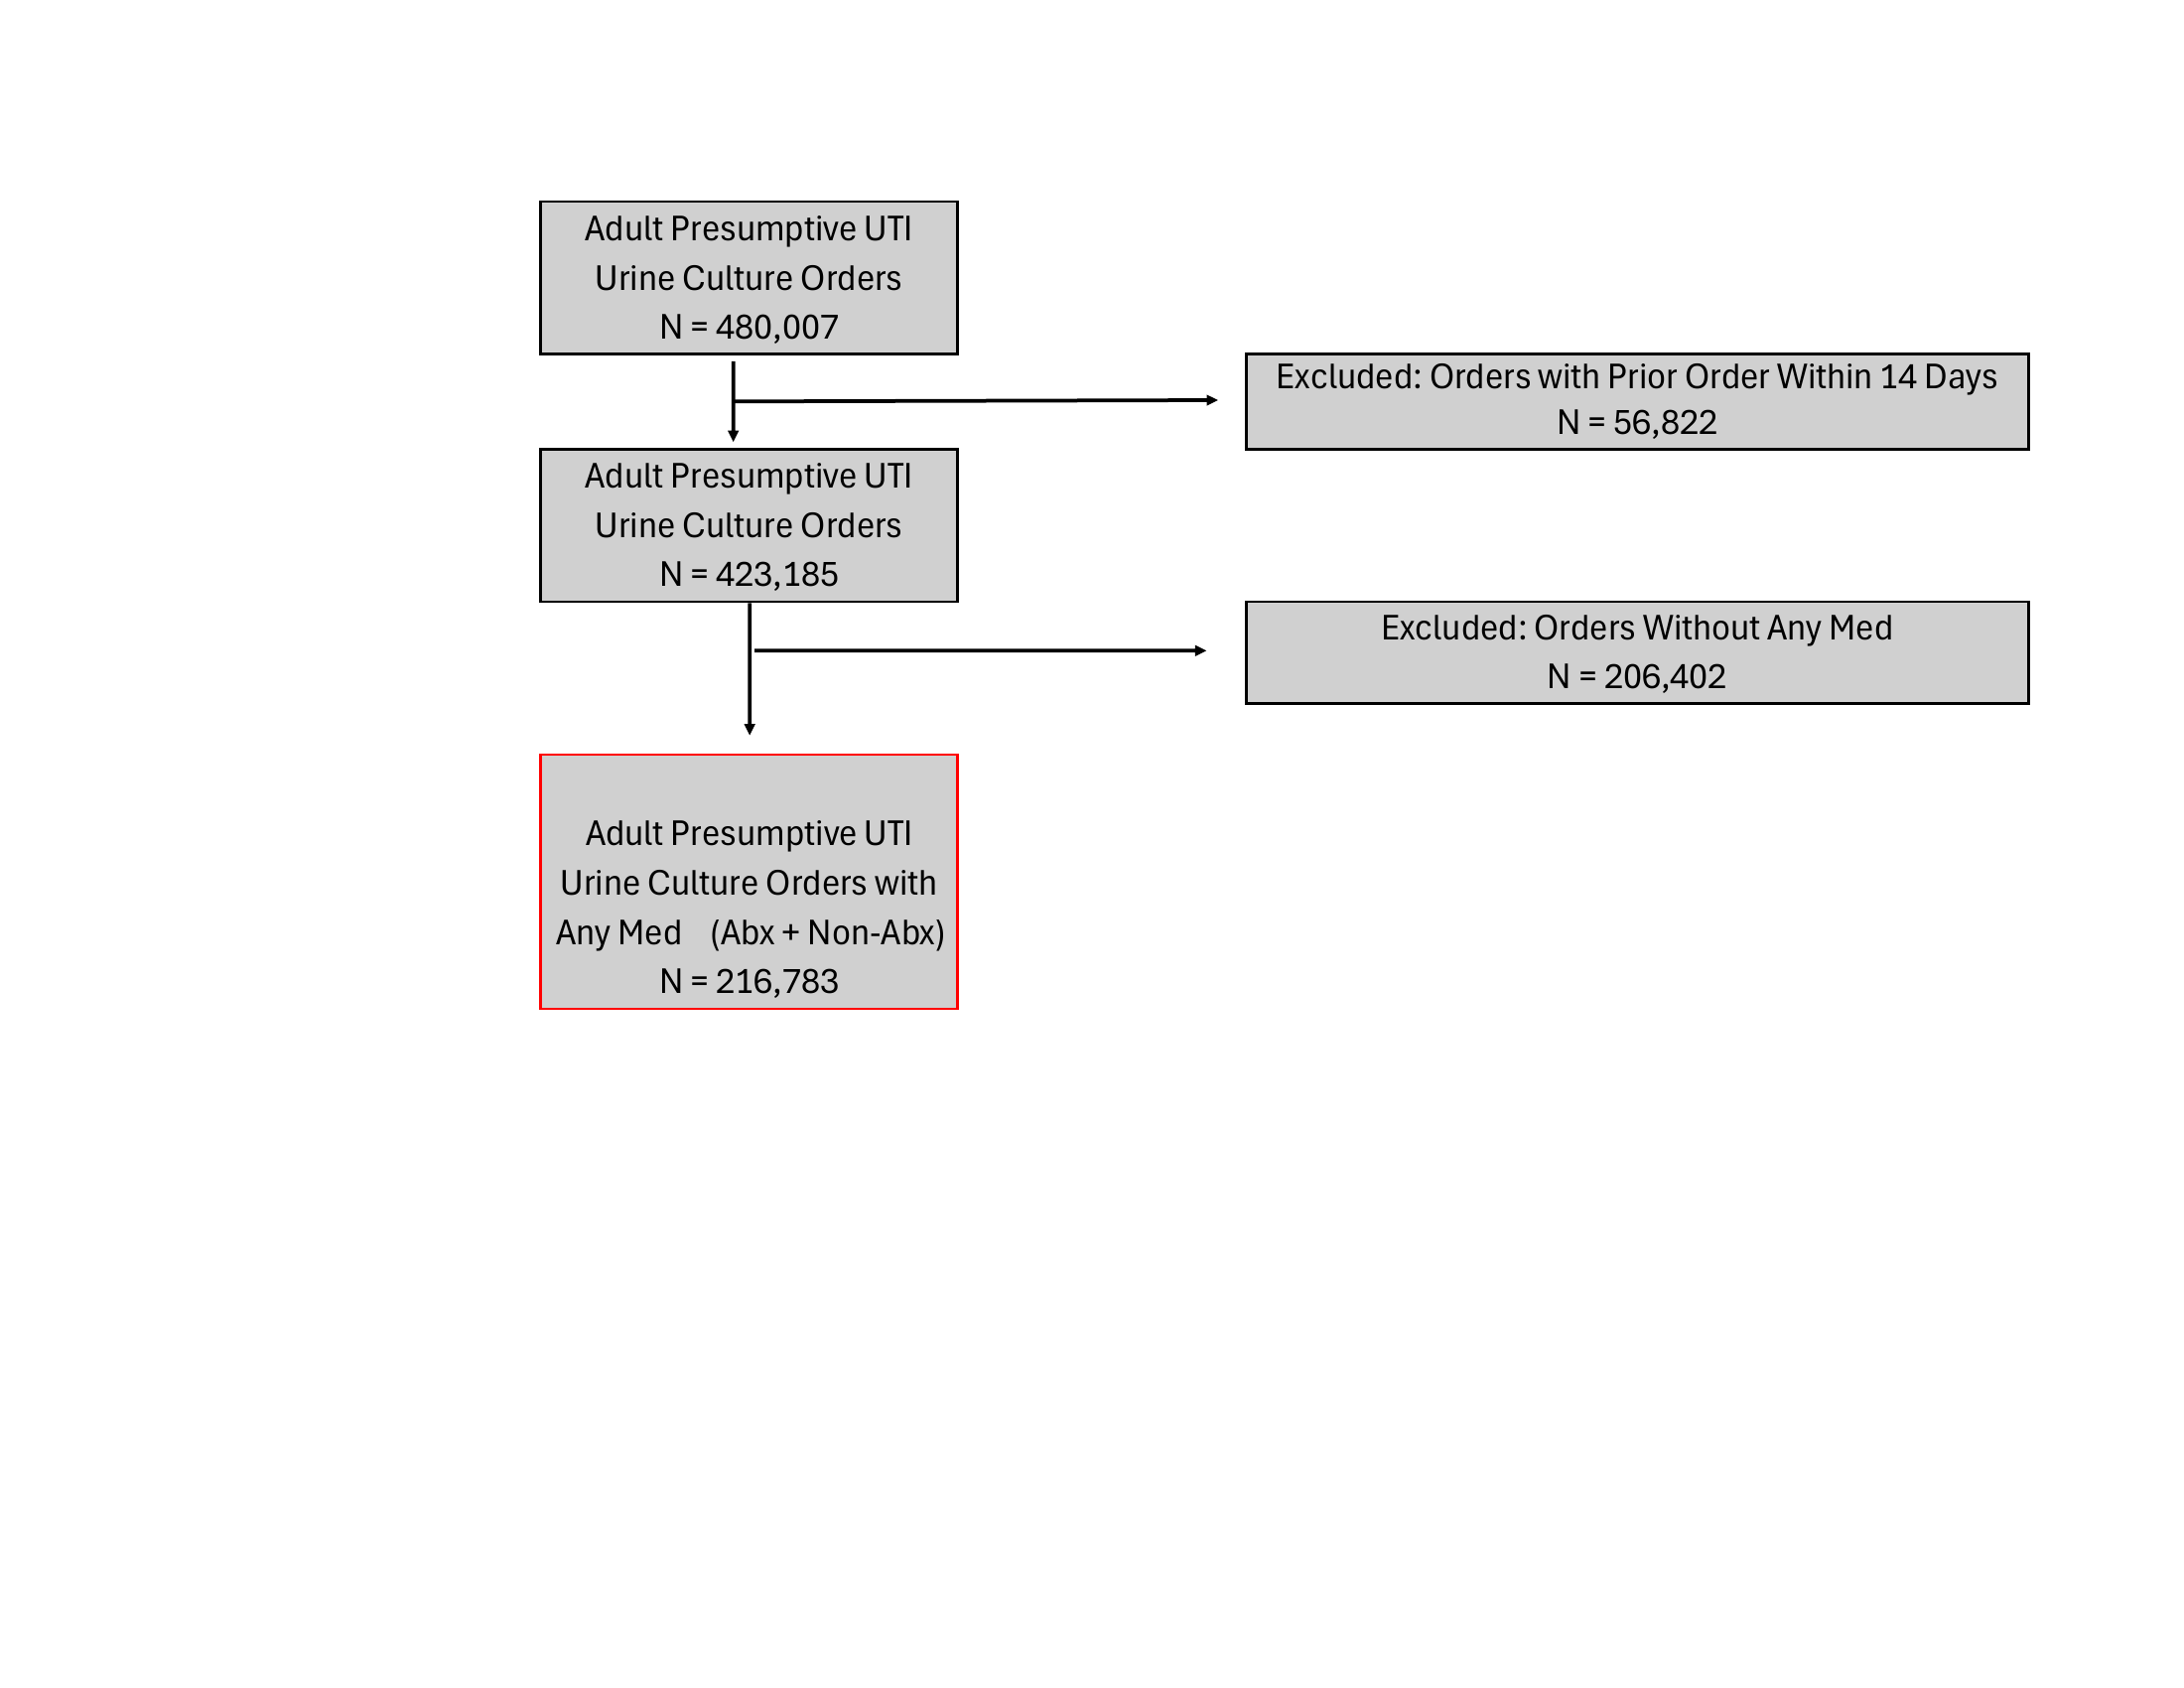

In [478]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step3.png'
pages[2].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

## We can further categorize `culture_order_with_any_cur_med` into antibiotic med and non-antibiotic med

In [30]:
culture_order_with_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] != "No Match"]
culture_order_with_non_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] == "No Match"]
print("the unique order number for culture_order_with_abx_med is {}".format(find_unique_orders(culture_order_with_abx_med)))
print("the unique order number for culture_order_with_non_abx_med is {}".format(find_unique_orders(culture_order_with_non_abx_med)))

the unique order number for culture_order_with_abx_med is 156314
the unique order number for culture_order_with_non_abx_med is 184104


## 📌 Understanding the Discrepancy in Order Counts

The reason why **(156,314 + 184,104) ≠ 216,783** is because:

- For one **order**, multiple **medications** can be prescribed.
- An order may include **both an antibiotic and a non-antibiotic**.

### 📊 Key Breakdown:
- **Total unique orders with any current medication:** `216,783`
- **Unique orders with at least one antibiotic (`abx_med`):** `156,314`
- **Unique orders without any antibiotics:**
  
  \[
    Total unique orders with current medication - Unique orders with an antibiotic 
  \]

  \[
  216,783 - 156,314 = **60,469**
  \]

Thus, the **60,469 orders** had at least one **non-antibiotic** medication but no antibiotics.

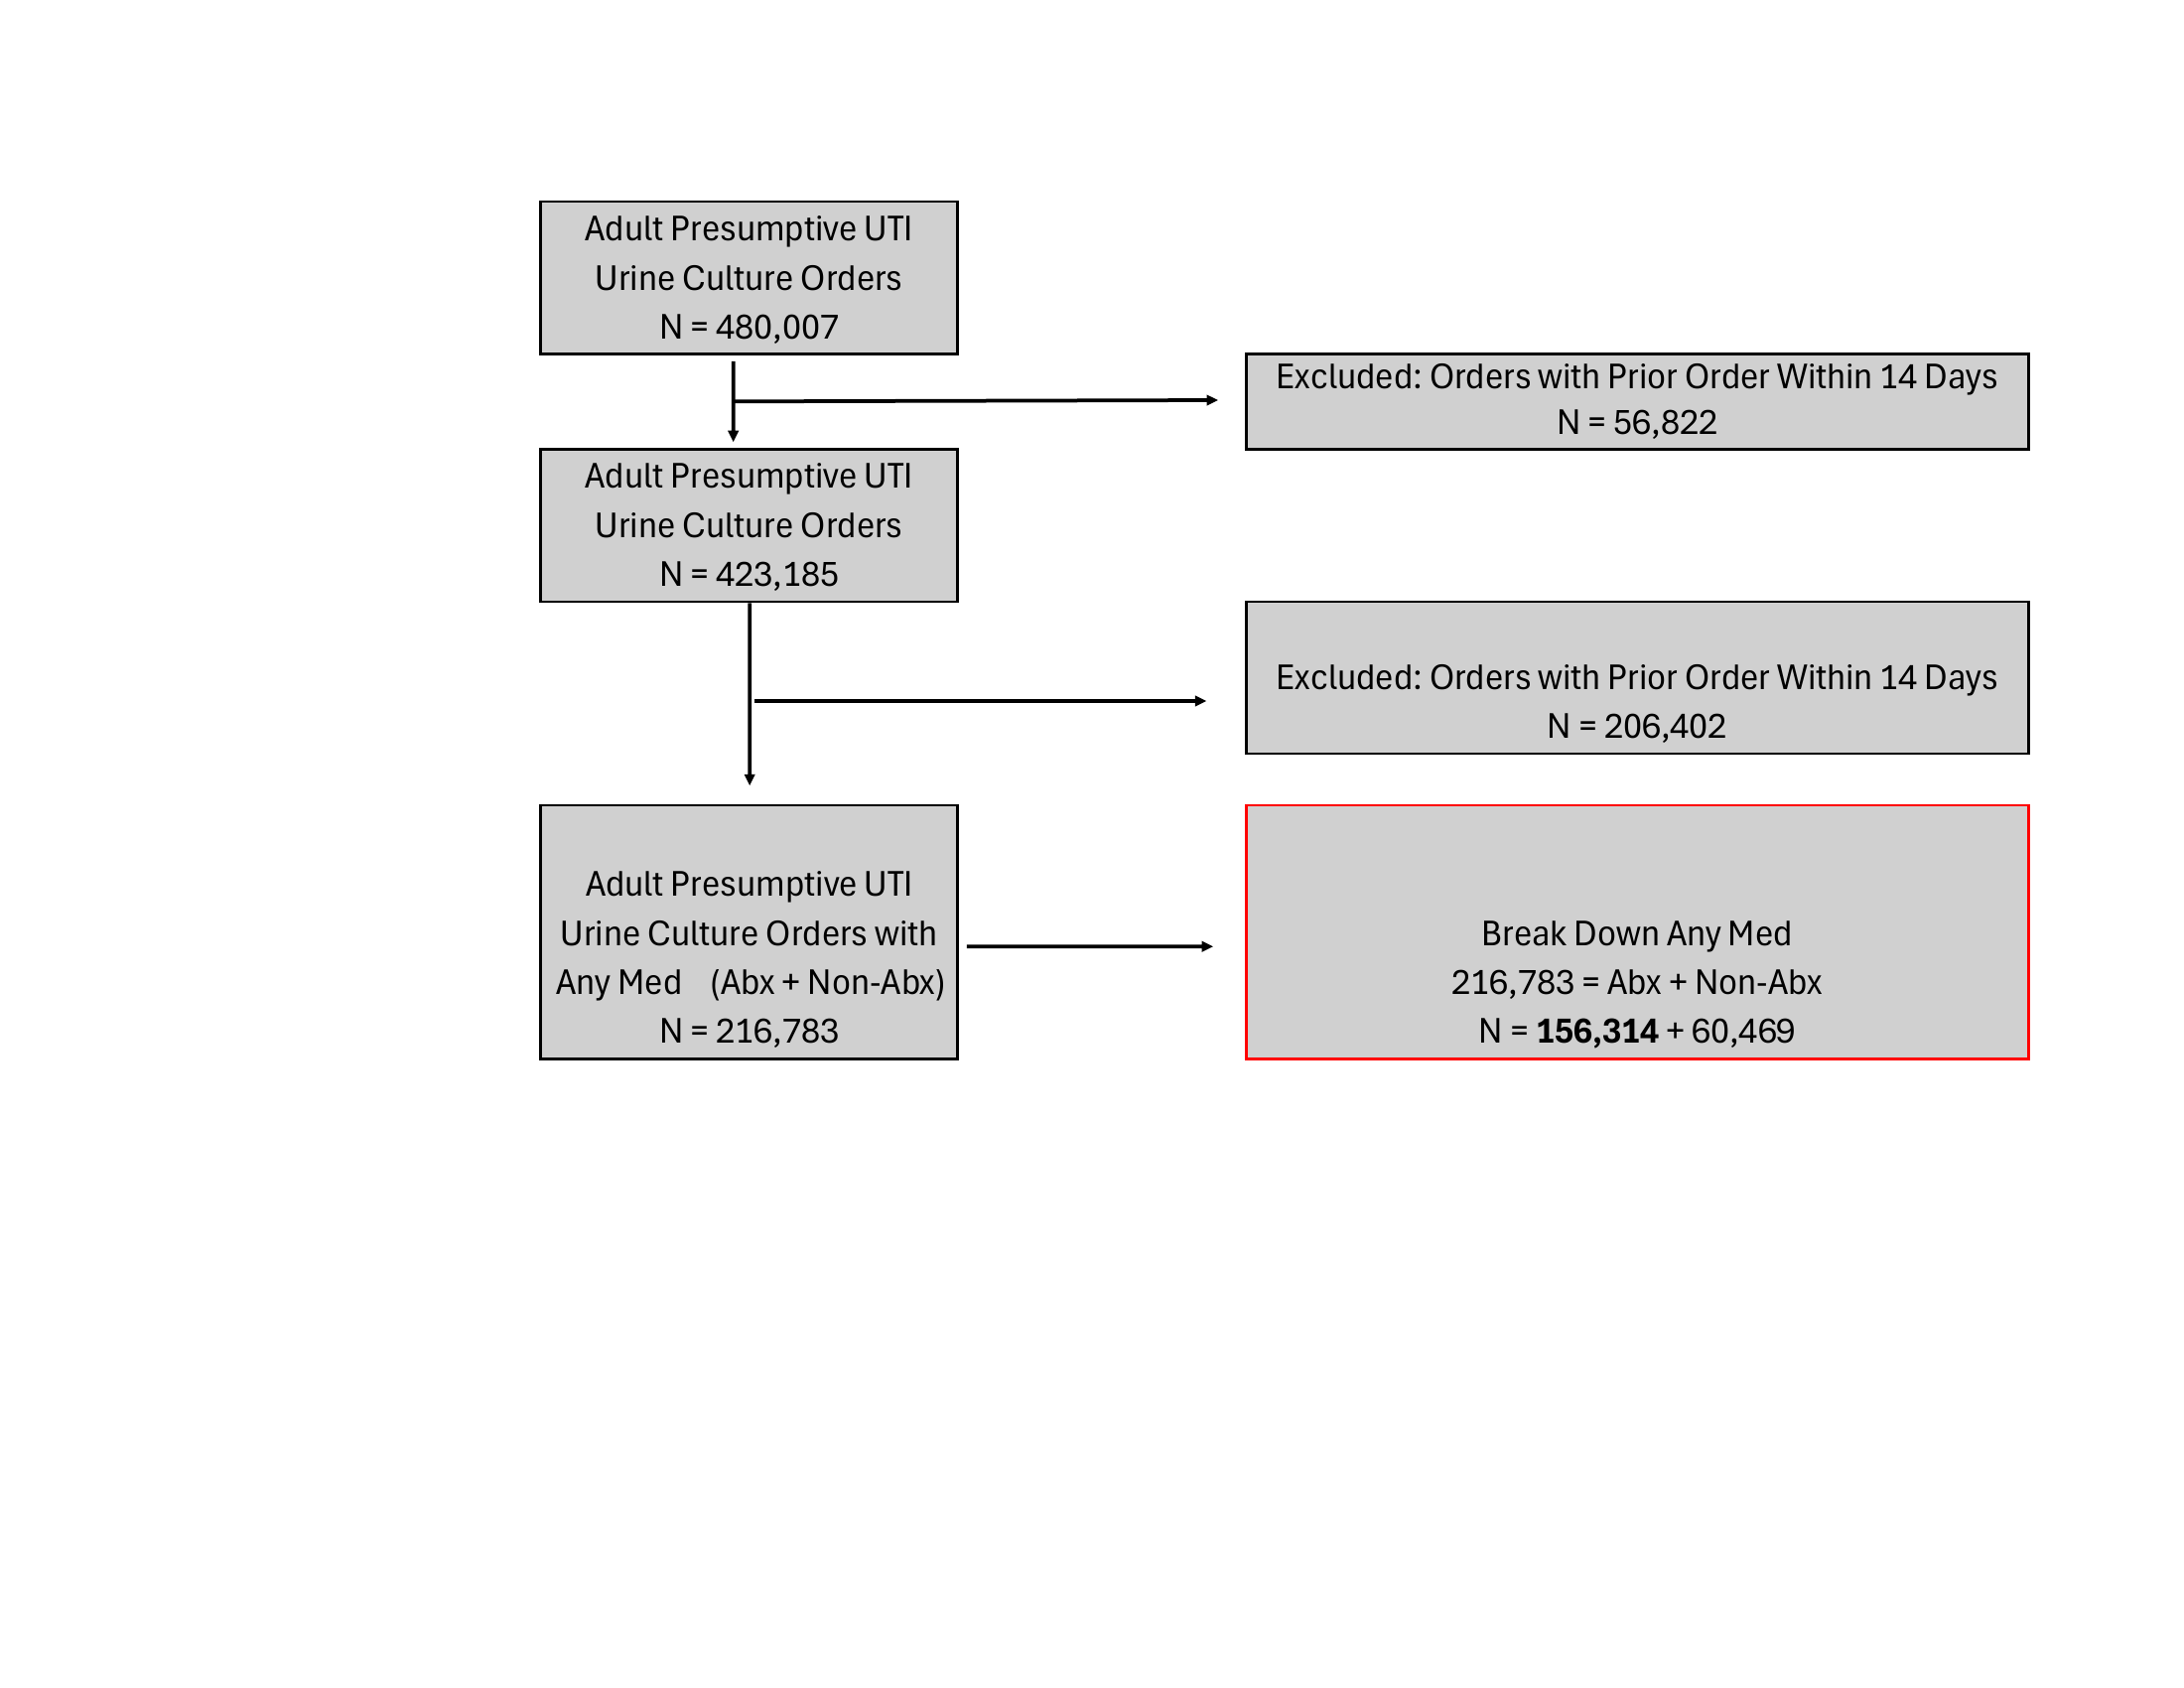

In [479]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step3-1.png'
pages[3].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ------------------------------ Step 3.2 ----------------------------

## 🔍 Verifying Antibiotic Administration in Orders

From the above analysis, we observe that:

- The total number of **culture orders** associated with at least one **antibiotic (`abx_med`)** is **156,314**.
- Now, we need to determine how many of these **antibiotic medications were actually administered**.

This check will help confirm whether all prescribed **antibiotic orders** were followed through with actual medication administration. 🚀

In [32]:
culture_order_with_abx_med_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"] == "Given"]
culture_order_with_abx_med_non_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"]!= "Given"]

In [33]:
print("the unique order number for culture_order_with_abx_med_given is {}".format(find_unique_orders(culture_order_with_abx_med_given)))
print("the unique order number for culture_order_with_abx_med_non_given is {}".format(find_unique_orders(culture_order_with_abx_med_non_given)))

the unique order number for culture_order_with_abx_med_given is 89025
the unique order number for culture_order_with_abx_med_non_given is 147673


<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

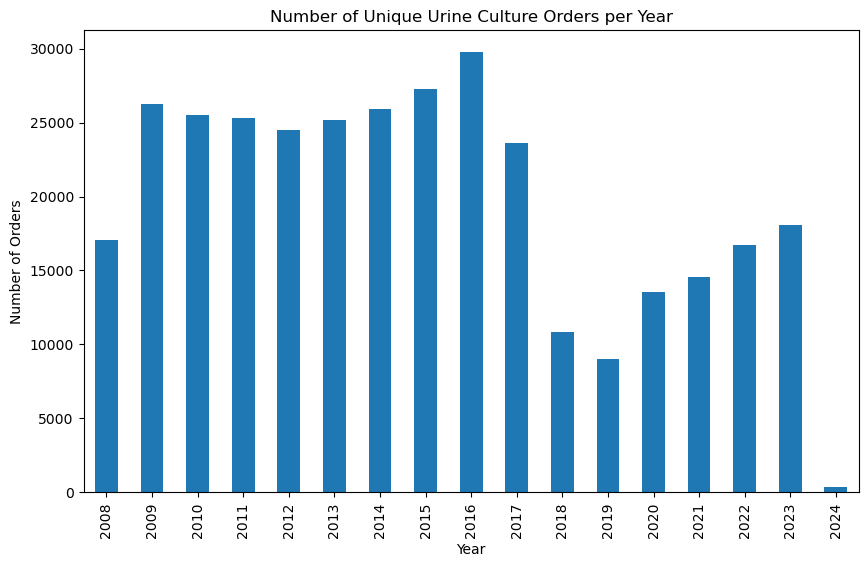

In [519]:
culture_order_with_abx_med_given["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [518]:
print("the unique order number for culture_order_with_abx_med_given is {}"\
      .format(find_unique_orders(culture_order_with_any_given_cur_med[culture_order_with_any_given_cur_med["cleaned_antibiotic"] != "No Match"])))

the unique order number for culture_order_with_abx_med_given is 89025


## 🔍 Understanding the Discrepancy in Antibiotic Orders

Similarly, **(89,025 + 147,673) ≠ 156,314** because:

- A single **order** can have multiple **medication actions** associated with it.
- An order may include **both "Given" and "Non-Given" medications**.

### 📊 Key Breakdown:
- **Total culture orders with an antibiotic (`abx_med`):** `156,314`
- **Orders where at least one antibiotic was **administered** (`Given`):** `89,025`
- **Orders where antibiotics were **not given** (`Non-Given`):** `147,673`
Because one order administration can associate with many actions,
- **Unique orders with antibiotic not given:**
  
  \[
    Total unique orders with antibiotic medication - Unique orders with administered antibiotic medication 
  \]

  \[
  156,314 - 89,025 = **67289**
  \]

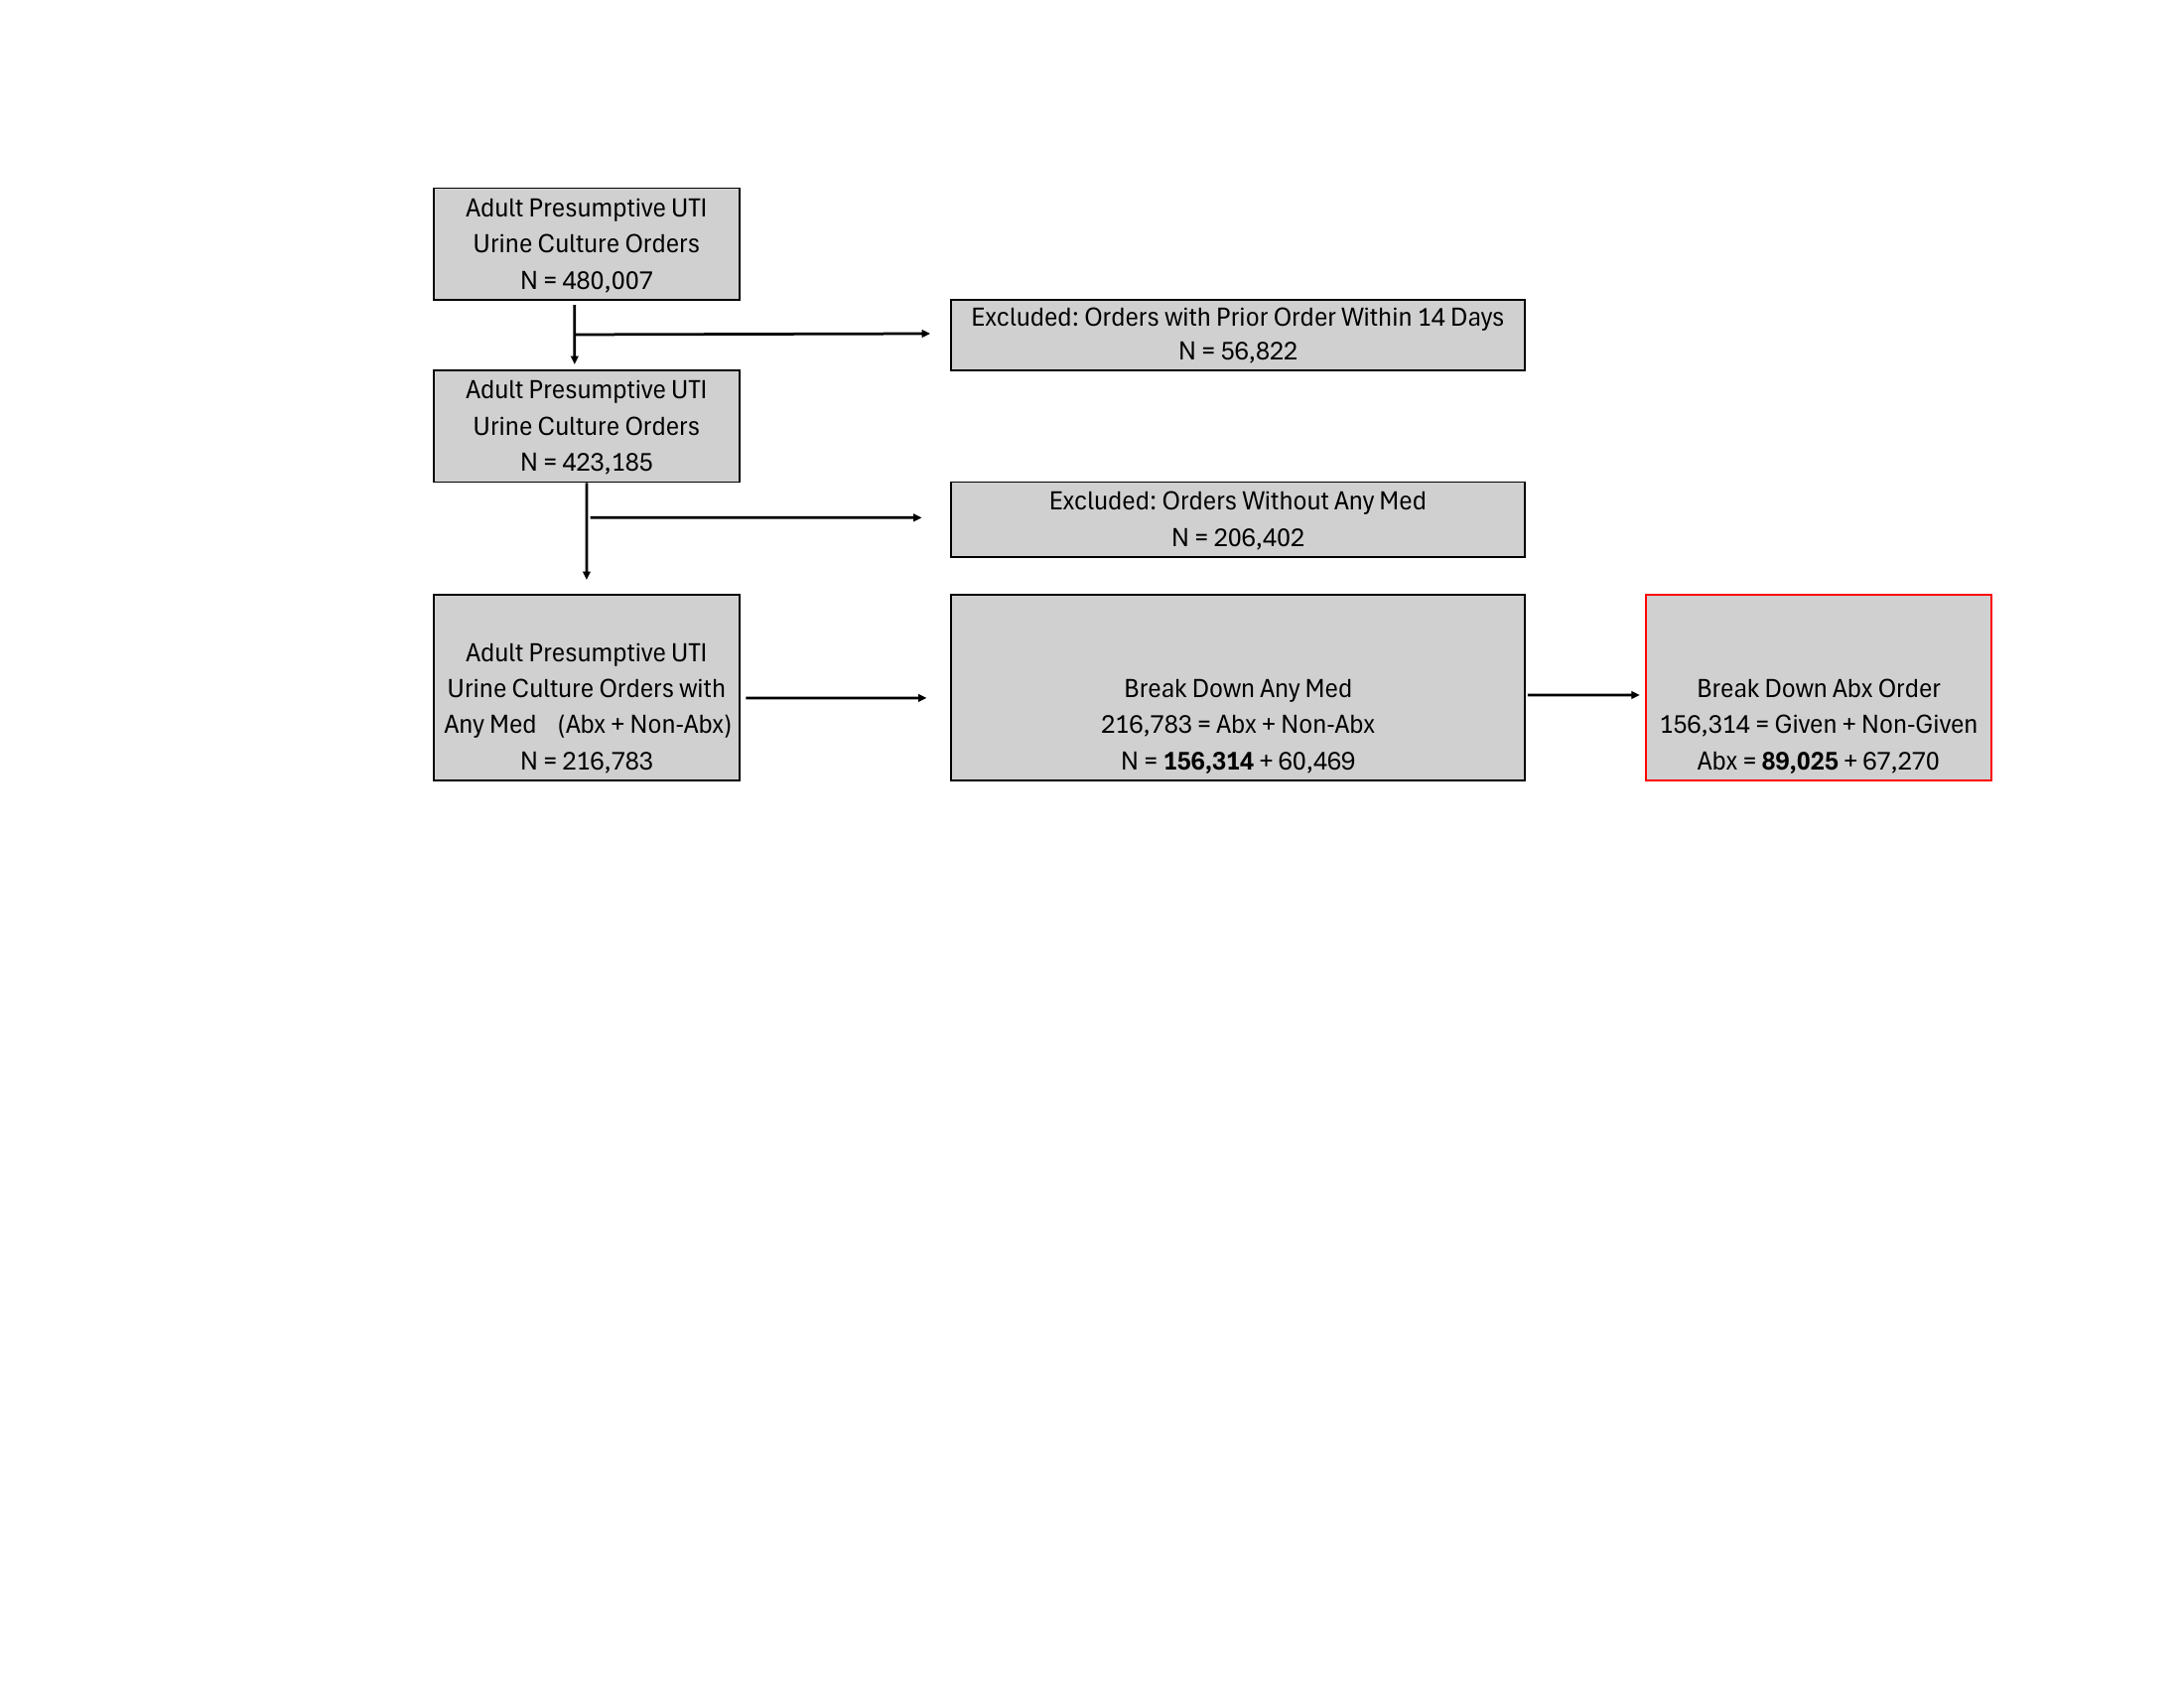

In [480]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step3-2.png'
pages[4].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))


In [35]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = culture_order_with_abx_med_given.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['cleaned_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= culture_order_with_abx_med_given[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)

In [36]:
sorted_group_counts_df
# JC999856	23290259	338723165, this example is good to show multiple medication scenario

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
2066847,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-23 07:00:00+00:00,CEFEPIME 2 GRAM/20 ML IV PUSH,876966020.000000000,Given,[Cefepime]
8495366,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-26 07:00:00+00:00,ERTAPENEM IV PUSH,877644606.000000000,Given,[Ertapenem]
8818568,JC1000129,131354606122,877003103,2023-04-24 01:28:00+00:00,2023-04-26 01:57:00+00:00,2023-04-27 07:00:00+00:00,ERTAPENEM IV PUSH,877931931.000000000,Given,[Ertapenem]
2072191,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,2023-07-15 07:00:00+00:00,CEFTRIAXONE 1 GRAM/10 ML IV PUSH (VIAL ONLY),894930579.000000000,Given,[Ceftriaxone]
8806288,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,2023-07-12 07:00:00+00:00,ERTAPENEM IV PUSH,894500637.000000000,Given,[Ertapenem]
...,...,...,...,...,...,...,...,...,...,...
11667813,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,2016-07-17 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,500348131.000000000,Given,"[Metronidazole In Nacl, Metronidazole]"
124529,JC999856,23290259,338723165,2008-12-23 05:45:00+00:00,2008-12-25 17:23:00+00:00,2008-12-22 08:00:00+00:00,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,338722444.000000000,Given,"[Piperacillin-Tazobactam-Dextrs, Piperacillin-..."
6530329,JC999856,23290259,338723165,2008-12-23 05:45:00+00:00,2008-12-25 17:23:00+00:00,2008-12-23 08:00:00+00:00,RIFAXIMIN 200 MG PO TABS,338741529.000000000,Given,[Rifaximin]
7493945,JC999856,23290259,338723165,2008-12-23 05:45:00+00:00,2008-12-25 17:23:00+00:00,2008-12-24 08:00:00+00:00,VANCOMYCIN IVPB (CUSTOM DOSE),338794596.000000000,Given,[Vancomycin]


# ---------------------------------**Step 4** ---------------------------

### Refactor Fateme's code for ward info in order to select ED order
Reference: https://github.com/HealthRex/CDSS/blob/master/scripts/antibiotic-susceptibility/sql/queries/microbiology_cultures_ward_info.sql

In [ ]:
# explore tables to check ED info for patients 2015

In [10]:
%%bigquery --use_rest_api df_hosp_ward_info
WITH
-- Step 1: Extract ER and ICU Information from adt Table
temp_er_icu_info_adt AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        CASE 
            WHEN pat_class = 'Emergency' OR pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER,
        CASE 
            WHEN pat_class = 'Intensive Care (IC)' THEN 1
            ELSE 0
        END AS hosp_ward_ICU,
        CASE 
            WHEN pat_lv_of_care LIKE "%Critical Care" THEN 1
            ELSE 0
        END AS hosp_ward_Critical_Care
    FROM
        `som-nero-phi-jonc101.shc_core_2023.adt`
),

-- Step 2: Extract ER Information from order_proc Table
temp_er_info_order_proc AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        CASE 
            WHEN proc_pat_class = 'Emergency' OR proc_pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER_order_proc
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 3: Combine ER and ICU Information
temp_combined_er_icu_info AS (
    SELECT
        adt.anon_id,
        adt.pat_enc_csn_id_coded,
        adt.hosp_ward_ER,
        adt.hosp_ward_ICU,
        adt.hosp_ward_Critical_Care,
        er.order_proc_id_coded,
        er.hosp_ward_ER_order_proc
    FROM
        temp_er_icu_info_adt adt
    LEFT JOIN
        temp_er_info_order_proc er
    ON
        adt.pat_enc_csn_id_coded = er.pat_enc_csn_id_coded
),

-- Step 4: Extract IP and OP Information from order_proc Table
temp_ip_op_info AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        CASE 
            WHEN ordering_mode = 'Inpatient' THEN 1
            ELSE 0
        END AS hosp_ward_IP,
        CASE 
            WHEN ordering_mode = 'Outpatient' THEN 1
            ELSE 0
        END AS hosp_ward_OP
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 5: Combine All Information into One Temporary Table
temp_combined_hosp_ward_info AS (
    SELECT
        ipop.anon_id,
        ipop.pat_enc_csn_id_coded,
        ipop.order_proc_id_coded,
        ipop.order_time_jittered_utc,
        ipop.hosp_ward_IP,
        ipop.hosp_ward_OP,
        COALESCE(icu.hosp_ward_ER, 0) AS hosp_ward_ER_adt,
        COALESCE(icu.hosp_ward_ER_order_proc, 0) AS hosp_ward_ER_order_proc,
        COALESCE(icu.hosp_ward_ICU, 0) AS hosp_ward_ICU,
        COALESCE(icu.hosp_ward_Critical_Care, 0) AS hosp_ward_Critical_Care
    FROM
        temp_ip_op_info ipop
    LEFT JOIN
        temp_combined_er_icu_info icu
    ON
        ipop.pat_enc_csn_id_coded = icu.pat_enc_csn_id_coded AND ipop.order_proc_id_coded = icu.order_proc_id_coded
),

-- Step 6: Extract ICU stay based on transfer orders
temp_cohortOfInterest AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        hosp_disch_time_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.encounter`
    WHERE hosp_disch_time_jittered_utc IS NOT NULL
),

temp_ordersTransfer AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        description,
        level_of_care,
        service,
        order_inst_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.order_proc` AS procedures
    WHERE (description LIKE "CHANGE LEVEL OF CARE/TRANSFER PATIENT" OR description LIKE "ADMIT TO INPATIENT") AND level_of_care IS NOT NULL
),

temp_icuTransferCount AS (
    SELECT
        mc.pat_enc_csn_id_coded,
        COUNT(CASE WHEN level_of_care LIKE "Critical Care" THEN 1 END) AS numICUTransfers
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc # only change this to the starting cohort above
    LEFT JOIN
        temp_ordersTransfer ot
    ON
        mc.pat_enc_csn_id_coded = ot.pat_enc_csn_id_coded
    GROUP BY
        mc.pat_enc_csn_id_coded
),

microbiology_cultures_with_icu_flag AS (
    SELECT DISTINCT
        mc.anon_id,
        mc.pat_enc_csn_id_coded,
        mc.order_proc_id_coded,
        mc.order_time_jittered_utc,
        CASE WHEN itc.numICUTransfers > 0 THEN 1 ELSE 0 END AS icu_flag
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
    LEFT JOIN
        temp_icuTransferCount itc
    ON
        mc.pat_enc_csn_id_coded = itc.pat_enc_csn_id_coded
)

-- Step 7: Create the Final Table with Correct Binary Indicators for Each Hospital Ward and ICU Flag
SELECT
    mc.anon_id,
    mc.pat_enc_csn_id_coded,
    mc.order_proc_id_coded,
    mc.order_time_jittered_utc,
    MAX(CASE WHEN chwi.hosp_ward_IP = 1 THEN 1 ELSE 0 END) AS hosp_ward_IP,
    MAX(CASE WHEN chwi.hosp_ward_OP = 1 THEN 1 ELSE 0 END) AS hosp_ward_OP,
    MAX(CASE WHEN chwi.hosp_ward_ER_adt = 1 OR chwi.hosp_ward_ER_order_proc = 1 THEN 1 ELSE 0 END) AS hosp_ward_ER,
    MAX(
        CASE 
            WHEN chwi.hosp_ward_ICU = 1 THEN 1 
            WHEN icu_flag.icu_flag = 1 THEN 1 
            WHEN chwi.hosp_ward_Critical_Care = 1 THEN 1
            ELSE 0 
        END
    ) AS hosp_ward_ICU
FROM
   `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort` mc
LEFT JOIN
    temp_combined_hosp_ward_info chwi
ON
    mc.anon_id = chwi.anon_id 
    AND mc.pat_enc_csn_id_coded = chwi.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = chwi.order_proc_id_coded
LEFT JOIN
    microbiology_cultures_with_icu_flag icu_flag
ON
    mc.anon_id = icu_flag.anon_id 
    AND mc.pat_enc_csn_id_coded = icu_flag.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = icu_flag.order_proc_id_coded
GROUP BY
    mc.anon_id, 
    mc.pat_enc_csn_id_coded, 
    mc.order_proc_id_coded, 
    mc.order_time_jittered_utc;

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
%%bigquery --use_rest_api df_hosp_ward_info
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_ward_info

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
assert find_unique_orders(df_hosp_ward_info) == find_unique_orders(starting_cohort), "Unique order counts do not match between df_hosp_ward_info and starting_cohort"

In [490]:
find_unique_orders(starting_cohort)

423185

In [40]:
ED_order = df_hosp_ward_info[df_hosp_ward_info['hosp_ward_ER'] == 1]
ED_order

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU
311323,JC1783941,131355397449,879930149,2023-06-02 20:17:00+00:00,0,1,1,0
311324,JC3243957,131288047970,662720316,2020-06-04 22:01:00+00:00,0,1,1,1
311325,JC561062,131152772437,480348716,2015-10-31 05:52:00+00:00,1,0,1,0
311326,JC1426476,131076943795,459620731,2015-03-30 04:46:00+00:00,1,0,1,0
311327,JC689618,131289176218,674136233,2020-07-11 01:41:00+00:00,1,0,1,1
...,...,...,...,...,...,...,...,...
423180,JC2511105,131186021383,493795751,2016-05-31 04:09:00+00:00,1,0,1,0
423181,JC1266055,131032973898,439244514,2014-05-23 10:46:00+00:00,1,0,1,0
423182,JC815723,131366627809,920688268,2023-10-26 23:26:00+00:00,1,0,1,0
423183,JC573303,131331405981,790075838,2022-04-18 20:01:00+00:00,1,0,1,0


# ------------------------------**Step 4.1** -----------------------

In [555]:
ED_culture_order_with_abx_med_given_12_hours = culture_order_with_abx_med_given_12_hours.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')
print("the unique order number for ED_culture_order_with_abx_med_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med_given_12_hours)))

the unique order number for ED_culture_order_with_abx_med_given is 60527


<Axes: title={'center': 'Number of Unique ED Urine Culture Orders with Given Abx Med per Year'}, xlabel='Year', ylabel='Number of Orders'>

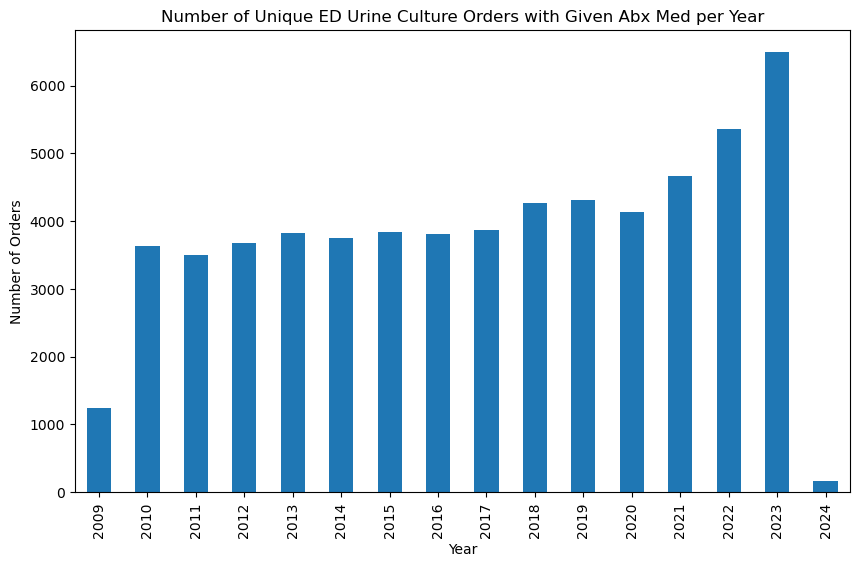

In [564]:
unique_ED_culture_order_with_abx_med_given_12_hours = ED_culture_order_with_abx_med_given_12_hours.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
unique_ED_culture_order_with_abx_med_given_12_hours["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique ED Urine Culture Orders with Given Abx Med per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [41]:
ED_culture_order_with_any_med =  culture_order_with_any_cur_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')
ED_culture_order_with_abx_med =  culture_order_with_abx_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')

In [42]:
print("the unique order number for ED_culture_order_with_any_med is {}".format(find_unique_orders(ED_culture_order_with_any_med)))
print("the unique order number for ED_culture_order_with_abx_med is {}".format(find_unique_orders(ED_culture_order_with_abx_med)))

the unique order number for ED_culture_order_with_any_med is 108299
the unique order number for ED_culture_order_with_abx_med is 79916


<Axes: title={'center': 'Number of Unique ED Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

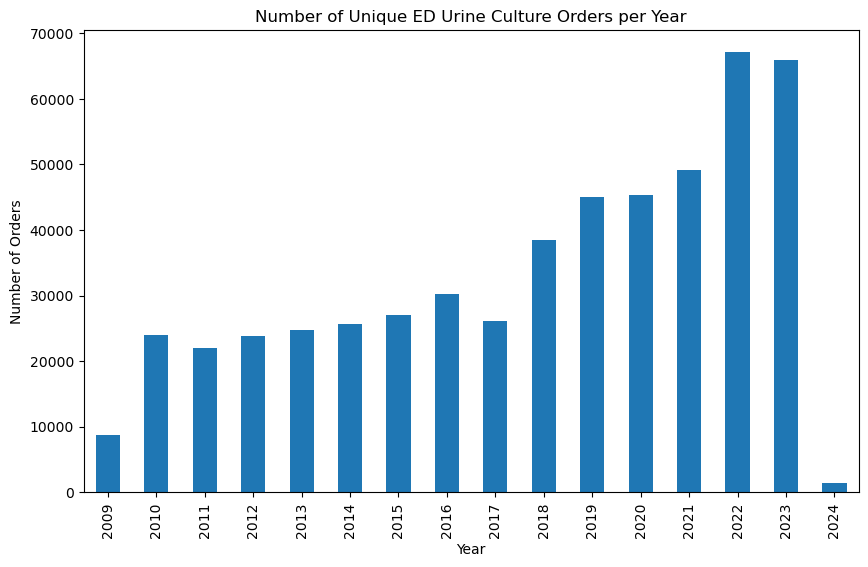

In [552]:
ED_culture_order_with_abx_med["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique ED Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

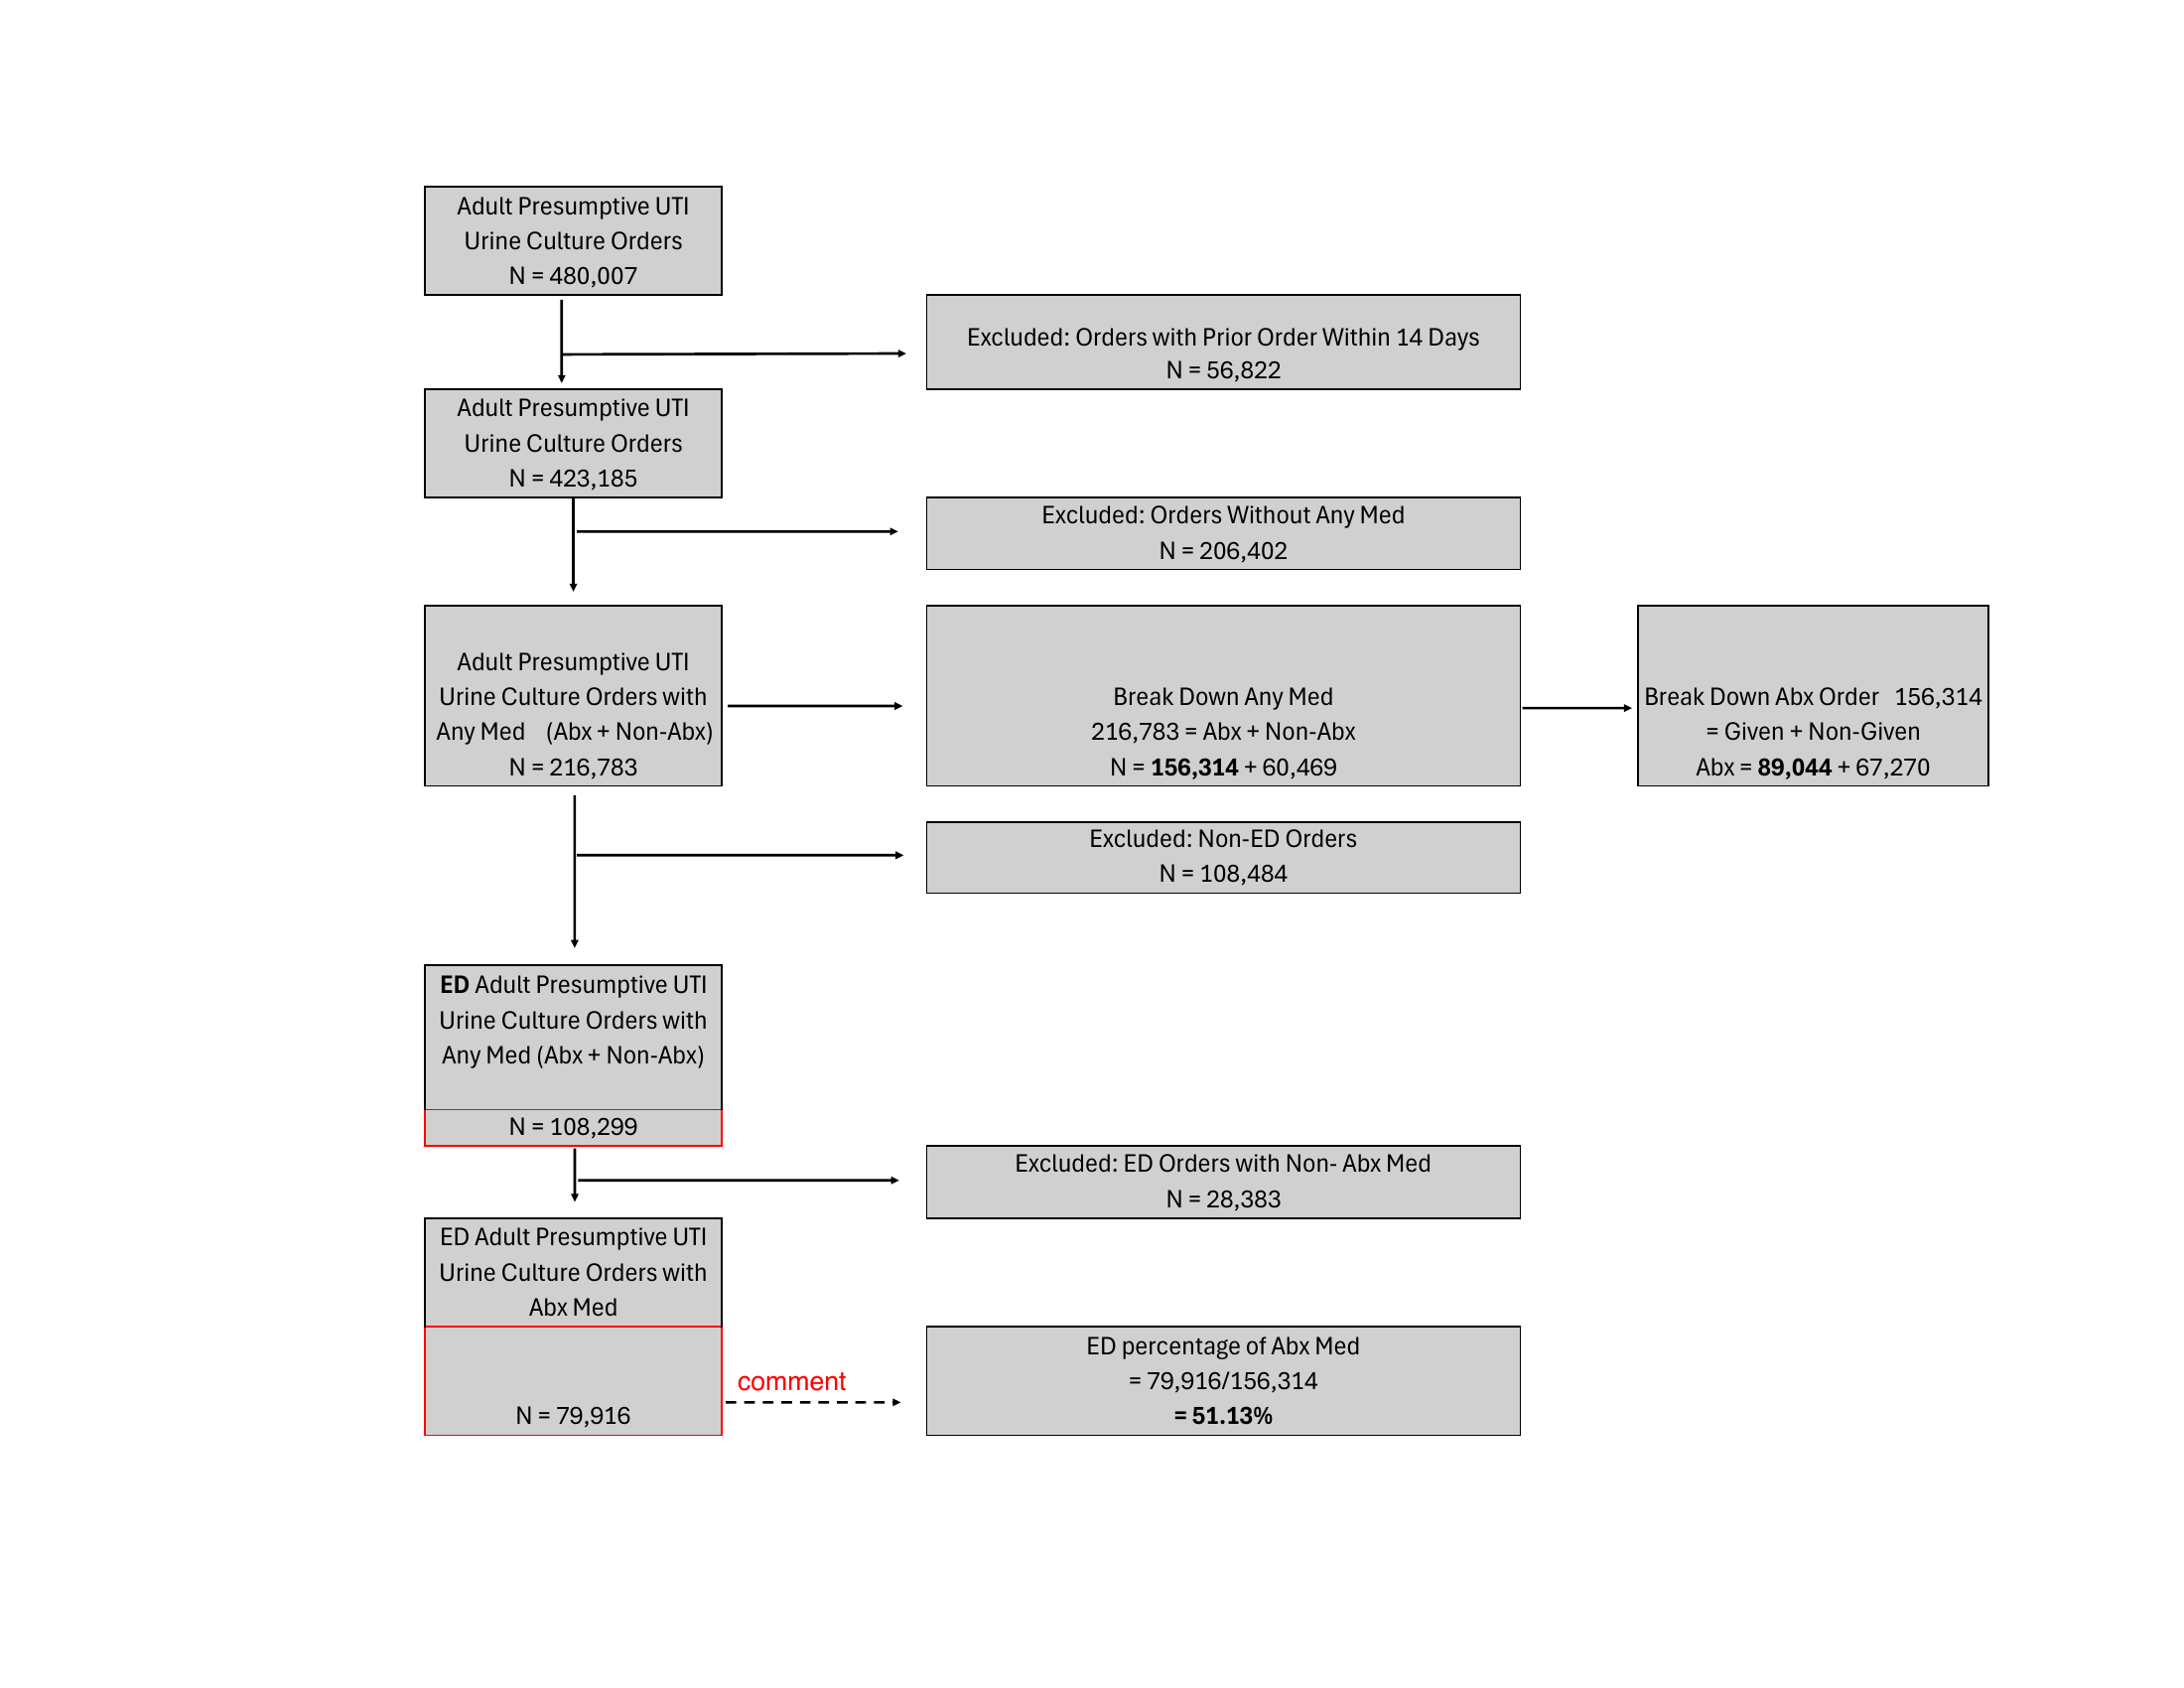

In [530]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step4-1.png.png'
pages[5].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ---------------------------------**Step 4.2** ------------------------

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

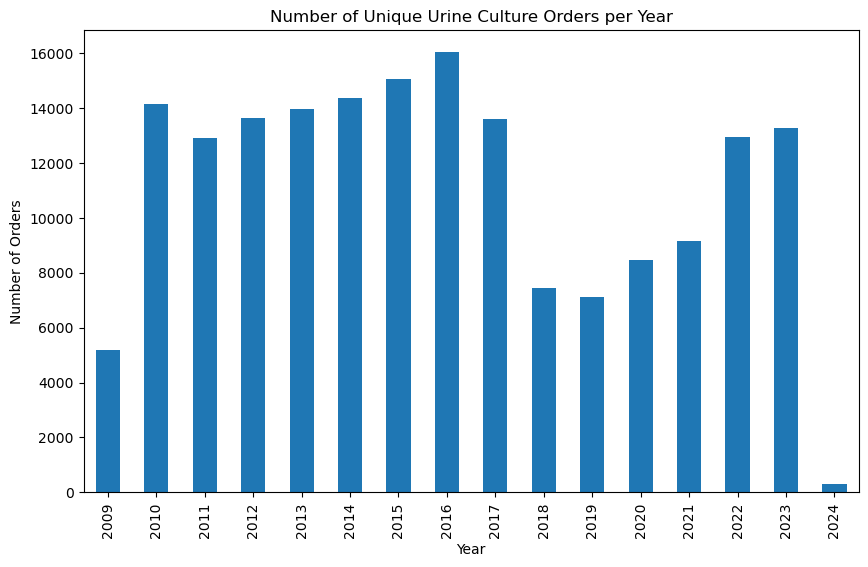

In [539]:
ED_culture_order_with_abx_med_given["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

In [44]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"] == "Given"]
ED_culture_order_with_abx_med_non_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"]!= "Given"]
print("the unique order number for ED_culture_order_with_abx_med_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med_given)))
print("the unique order number for ED_culture_order_with_abx_med_non_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med) - find_unique_orders(ED_culture_order_with_abx_med_given)))

the unique order number for ED_culture_order_with_abx_med_given is 60008
the unique order number for ED_culture_order_with_abx_med_non_given is 19908


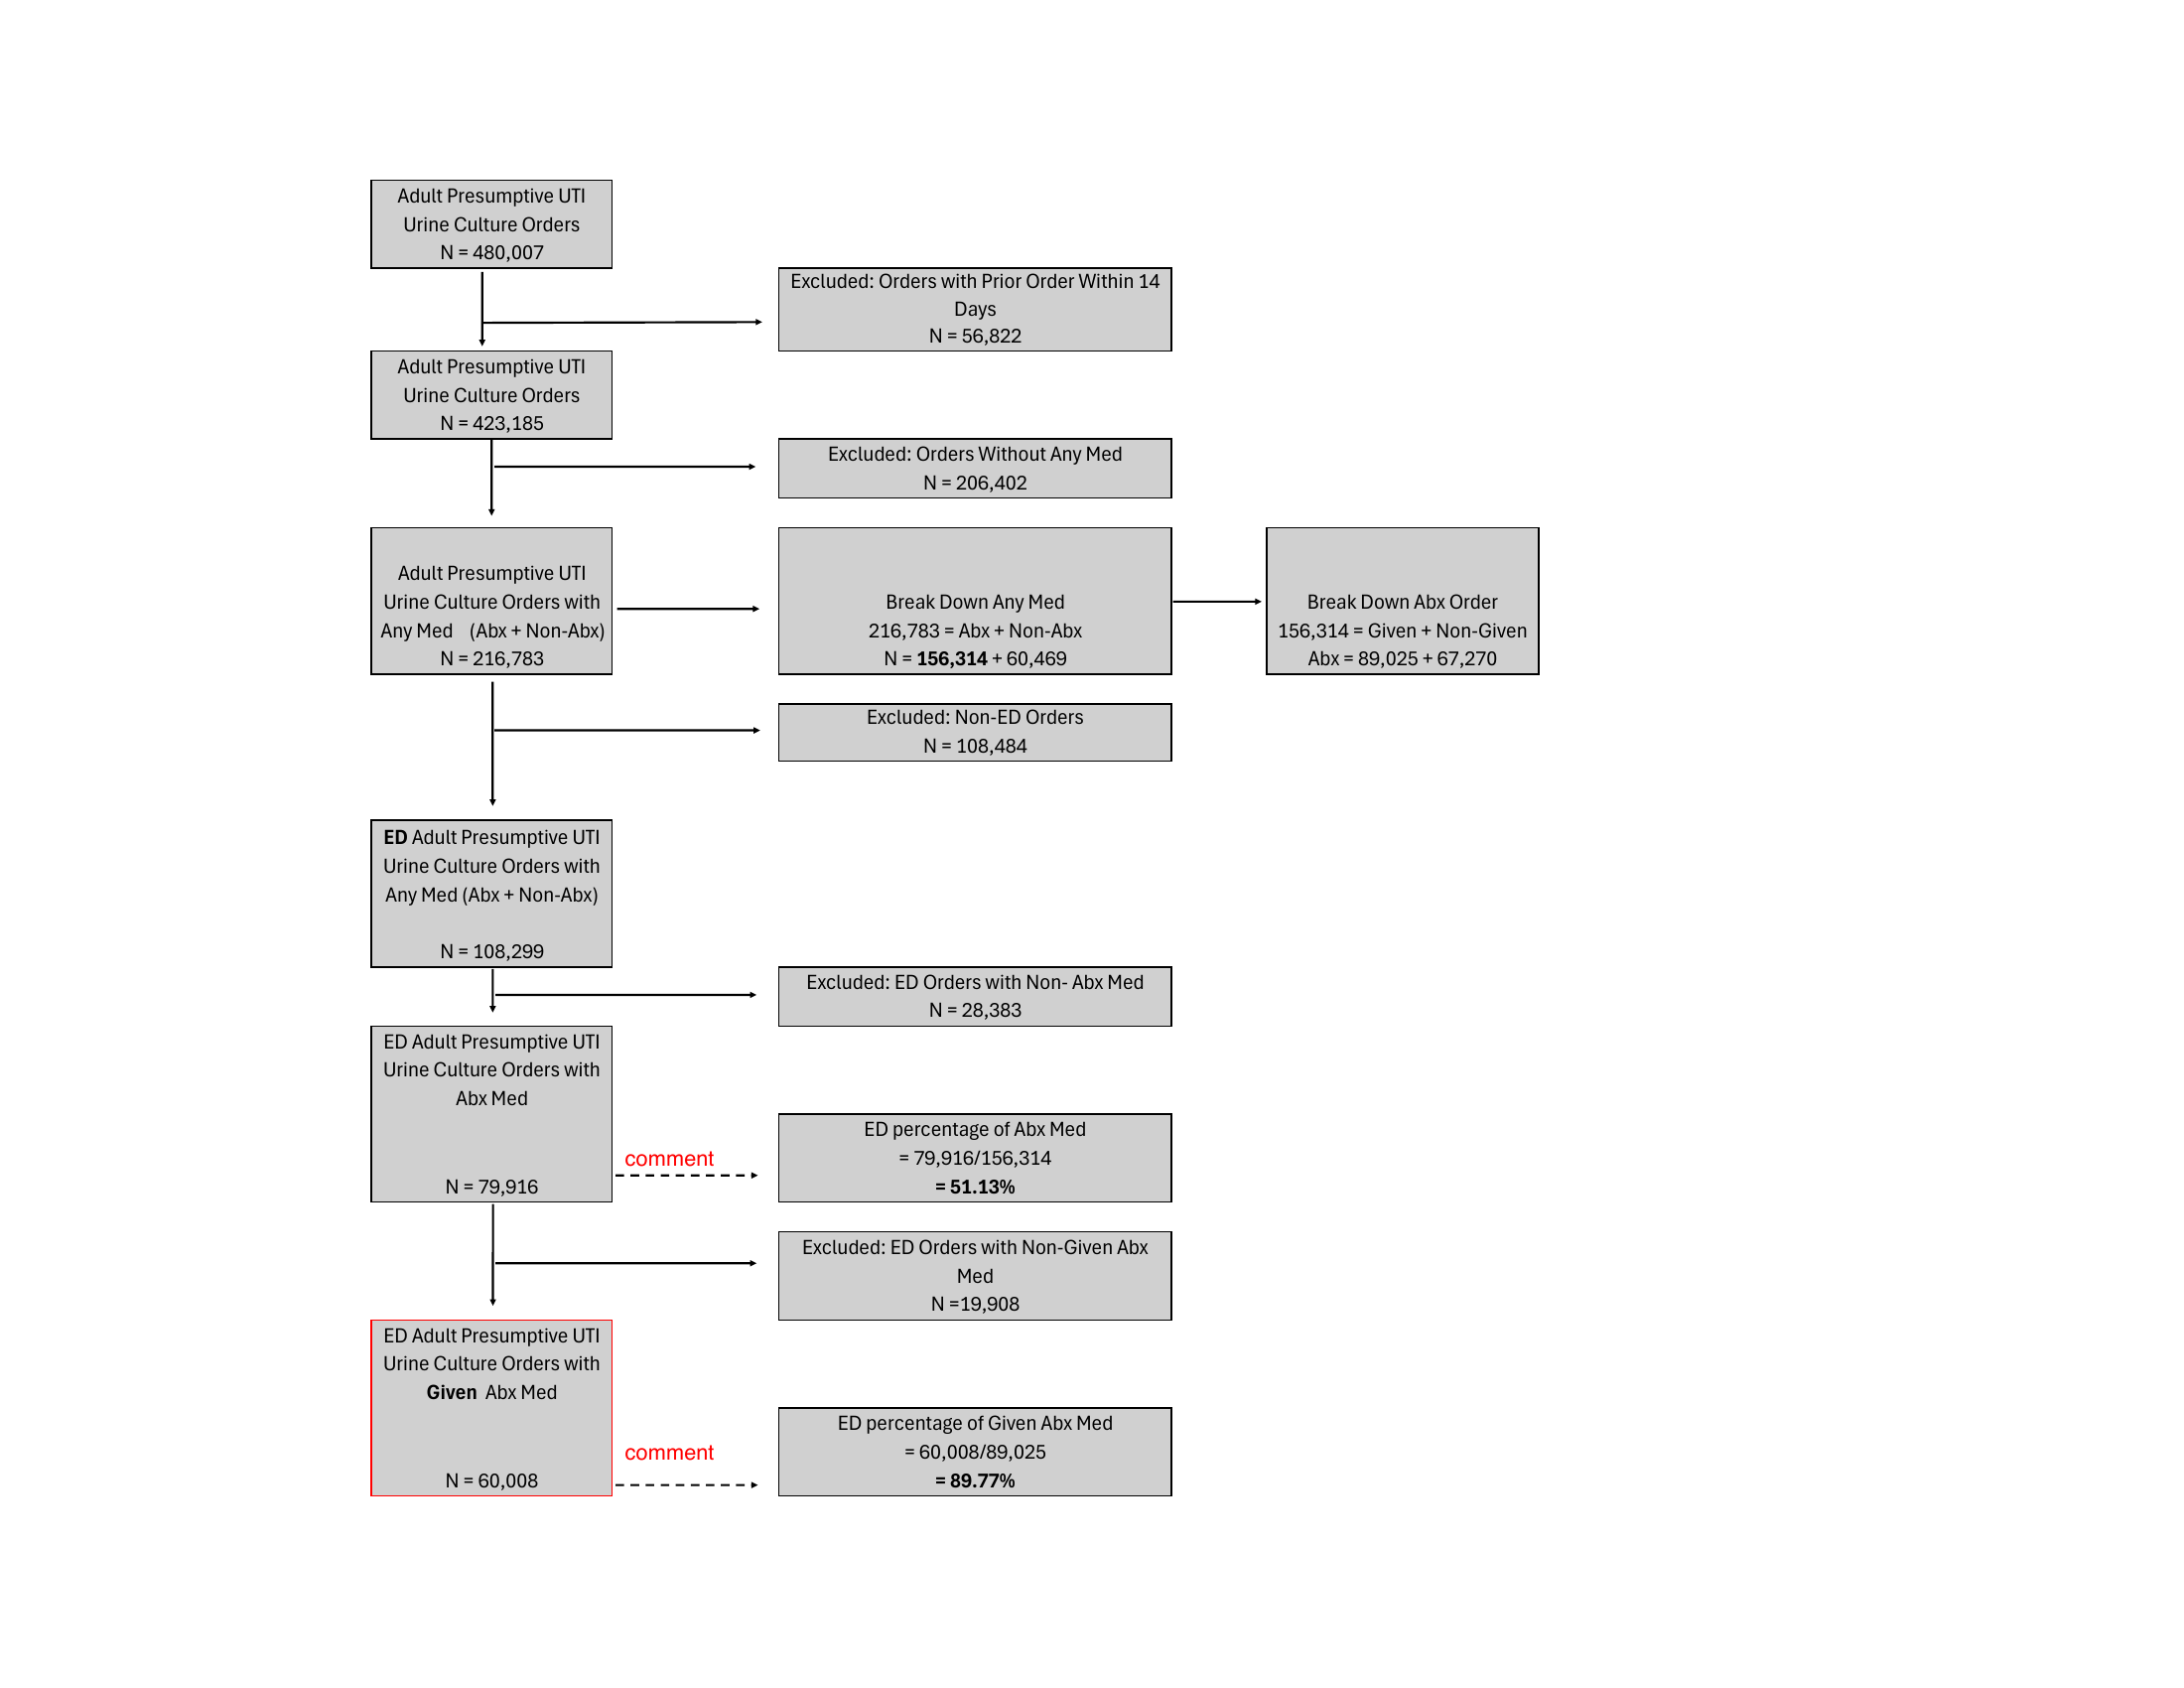

In [491]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step4-2.png.png'
pages[6].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

# ------------------------------**Step 5** -----------------------

## 🔍 Identifying Empirical Antibiotic Use in the ED Cohort

Now that we've curated the **`ED_culture_order_with_abx_med_given`** cohort, the next step is to determine:

> **How many of the 60,008 orders with antibiotic medications are empirical?**

### 📖 Definition of Empirical Use:
An antibiotic is considered **empirical** if either of the following conditions is met:

1. **The medication time** is **after the culture order time** but **before the culture result time**.
2. **The medication time** is **within 6 hours before** the culture order time.
# 12 hours?

This definition helps us identify antibiotics that were likely prescribed based on **clinical suspicion**, prior to definitive diagnostic results.

In [46]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med_given.drop(columns=['hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU'])

In [559]:
# Group by the specified columns
grouped_12_hours = ED_culture_order_with_abx_med_given_12_hours.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

# Function to filter each group
def filter_group(group):
        # Keep rows where:
        # 1. medication_time is greater than culture order time but smaller than result time, OR
        # 2. medication_time is within 6 hours before the culture order time
    condition = (
        ((group['medication_time'] > group['order_time_jittered_utc']) & 
            (group['medication_time'] < group['result_time_jittered_utc'])) | 
        ((group['medication_time'] >= (group['order_time_jittered_utc'] - pd.Timedelta(hours=12))) & 
            (group['medication_time'] <= group['order_time_jittered_utc'])
    ))
    return group[condition]

# Apply the filter to each group
filtered_groups_12_hours = [filter_group(group) for _, group in grouped_12_hours]

# Combine the filtered groups into a new DataFrame
filtered_df_12_hours= pd.concat([group for group in filtered_groups_12_hours if group is not None])

# Reset the index
# filtered_df = filtered_df.reset_index(drop=True)

In [560]:
print("the unique order number for empirical abx med order is {}".format(find_unique_orders(filtered_df_12_hours)))

the unique order number for empirical abx med order is 36219


In [48]:
# Group by the specified columns
grouped = ED_culture_order_with_abx_med_given.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

# Function to filter each group
def filter_group(group):
        # Keep rows where:
        # 1. medication_time is greater than culture order time but smaller than result time, OR
        # 2. medication_time is within 6 hours before the culture order time
    condition = (
        ((group['medication_time'] > group['order_time_jittered_utc']) & 
            (group['medication_time'] < group['result_time_jittered_utc'])) | 
        ((group['medication_time'] >= (group['order_time_jittered_utc'] - pd.Timedelta(hours=6))) & 
            (group['medication_time'] <= group['order_time_jittered_utc'])
    ))
    return group[condition]

# Apply the filter to each group
filtered_groups = [filter_group(group) for _, group in grouped]

# Combine the filtered groups into a new DataFrame
filtered_df = pd.concat([group for group in filtered_groups if group is not None])

# Reset the index
# filtered_df = filtered_df.reset_index(drop=True)


In [49]:
filtered_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
347427,JC1000129,131359337847,894465321,2023-07-12 23:05:00+00:00,2023-07-17 23:46:00+00:00,2023-07-15 07:00:00+00:00,CEFTRIAXONE 1 GRAM/10 ML IV PUSH (VIAL ONLY),894930579.000000000,Given,[Ceftriaxone]
420944,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,2017-06-27 07:00:00+00:00,CIPROFLOXACIN HCL 500 MG PO TABS,528319990.000000000,Given,"[Ciprofloxacin Hcl, Cipro, Ciprofloxacin, Oflo..."
420945,JC1000159,131233687107,528101351,2017-06-25 18:22:00+00:00,2017-06-27 19:56:00+00:00,2017-06-26 07:00:00+00:00,CEFTRIAXONE 2 GRAM/50 ML MINIBAG PLUS,528216964.000000000,Given,[Ceftriaxone]
499831,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.000000000,Given,[Ceftriaxone]
287134,JC1000449,131010625428,371801412,2010-08-15 17:23:00+00:00,2010-08-17 13:36:00+00:00,2010-08-16 07:00:00+00:00,CEFTRIAXONE 1 GRAM/50 ML D5W IVPB (COMPOUNDED),371847424.000000000,Given,[Ceftriaxone]
...,...,...,...,...,...,...,...,...,...,...
376802,JC999190,131368104425,926230628,2024-01-04 07:03:00+00:00,2024-01-07 23:21:00+00:00,2024-01-05 08:00:00+00:00,CEFTRIAXONE 2 GRAM/20 ML IV PUSH (VIAL ONLY),926633172.000000000,Given,[Ceftriaxone]
438755,JC999590,131022787414,414244926,2013-02-04 01:57:00+00:00,2013-02-06 07:08:00+00:00,2013-02-04 08:00:00+00:00,LEVOFLOXACIN IN D5W 500 MG/100 ML IV PGBK,414290521.000000000,Given,"[Levofloxacin, Levofloxacin In, Ofloxacin]"
242561,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,2016-07-18 07:00:00+00:00,AMOXICILLIN-POT CLAVULANATE 500-125 MG PO TABS,500408533.000000000,Given,"[Amoxicillin-Pot Clavulanate, Amoxicillin]"
242574,JC999842,131192863784,500208763,2016-07-16 14:51:00+00:00,2016-07-18 16:13:00+00:00,2016-07-17 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,500348131.000000000,Given,"[Metronidazole In Nacl, Metronidazole]"


In [ ]:
# starting_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# filtered_df["order_time_jittered_utc"].dt.year.value_counts().sort_index()
# # non_subset_rows = ED_culture_order_with_abx_med[~ED_culture_order_with_abx_med.index.isin(filtered_df.index)]
# non_subset_rows

In [187]:
filtered_df.to_csv('../csv_folder/filtered_df.csv', index=False)
# will upload this to bigquery as well

In [50]:
print("the unique order number for empirical abx med order is {}".format(find_unique_orders(filtered_df)))
print("the unique order number for non empirical abx med order is {}"\
      .format(find_unique_orders(ED_culture_order_with_abx_med_given) -find_unique_orders(filtered_df)))

the unique order number for empirical abx med order is 29715
the unique order number for non empirical abx med order is 30293


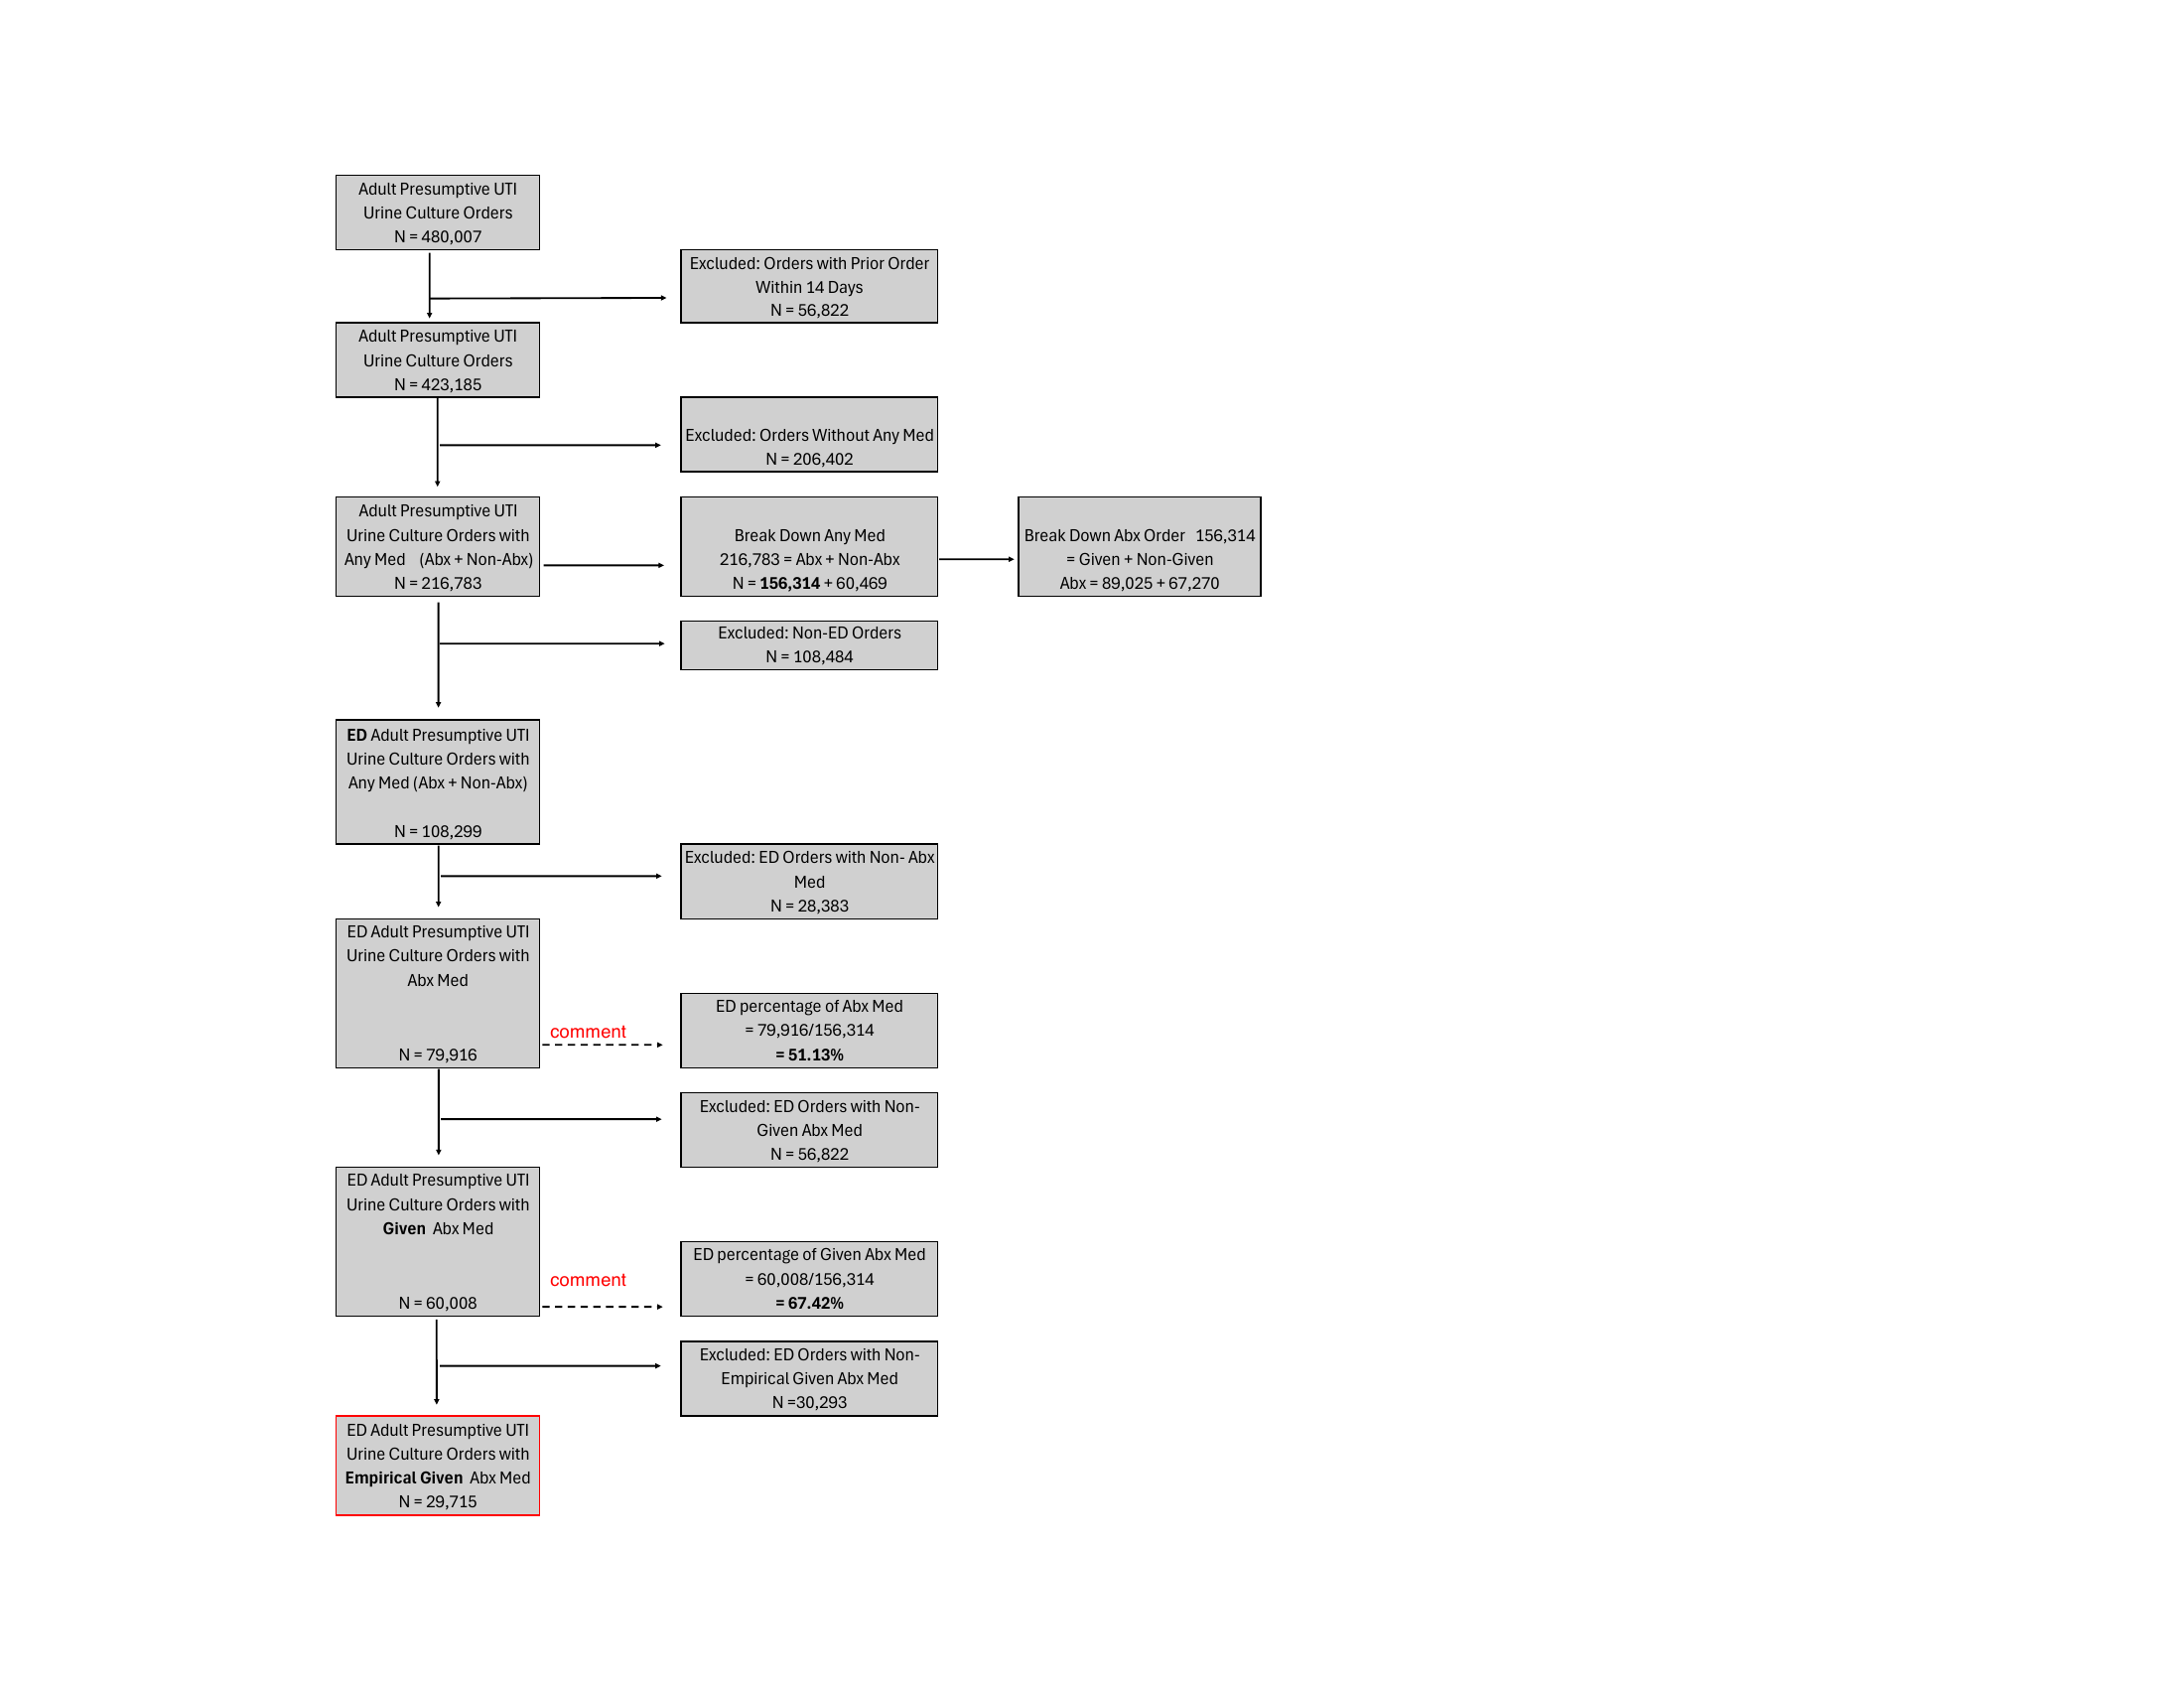

In [483]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step5.png.png'
pages[7].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

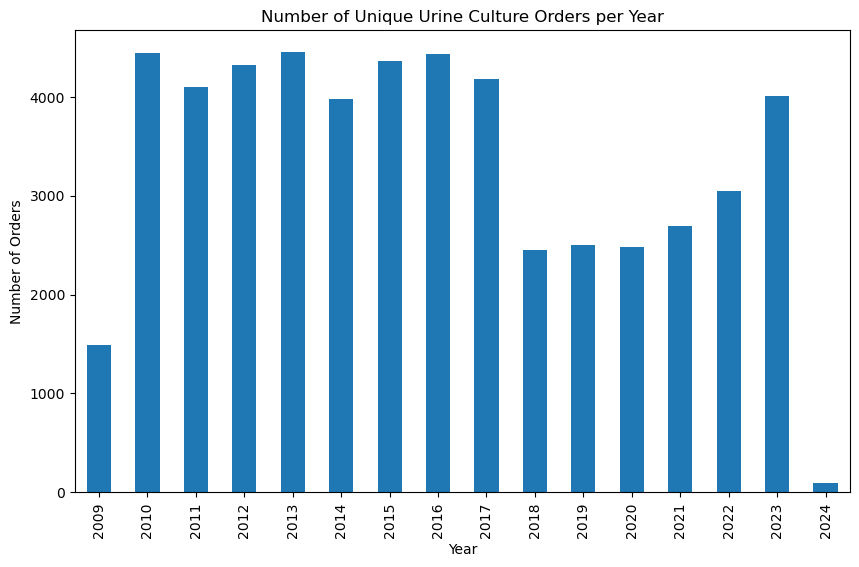

In [540]:
filtered_df["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

# -----------------------------**Step 6** -------------------------------

## 🔍 Excluding Orders with Prior Medication Exposure

Now that we've identified the orders with **empirical antibiotic use**, the next step is to refine the cohort by accounting for **prior medication exposure**.

> We will exclude any orders where the patient received **any antibiotic within the 30 days** preceding the culture order.

This ensures that the empirical use we're measuring reflects **new treatments** rather than continued or repeated antibiotic use.

In [ ]:
%%bigquery --use_rest_api all_med
CREATE OR REPLACE TABLE `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` AS 
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_cohort`
        -- limit 1000
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mo.pat_enc_csn_id_coded AS medication_encounter_id,
        ARRAY_AGG(DISTINCT ca.antibiotic_name IGNORE NULLS) AS cleaned_antibiotic,
         -- Avoid nulls  -- Aggregates matche
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        USING(anon_id)
    LEFT JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.clean_antibiotic` ca
        ON LOWER(mo.med_description) LIKE CONCAT('%', LOWER(ca.antibiotic_name), '%')  -- Match antibiotic names within medication_name
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # Incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
    GROUP BY 
        c.anon_id, c.pat_enc_csn_id_coded, c.order_proc_id_coded, 
        c.order_time_jittered_utc, c.result_time_jittered_utc, 
        mo.ordering_date_jittered_utc, mo.med_description, mo.pat_enc_csn_id_coded, mar.order_med_id_coded, mar.mar_action
    -- limit 1000
)

SELECT * 
FROM cleaned_medications
ORDER BY 
    anon_id, pat_enc_csn_id_coded, order_proc_id_coded, 
    order_time_jittered_utc, result_time_jittered_utc, 
    medication_time, medication_name, medication_encounter_id
    -- limit 1000;

In [52]:
%%bigquery --use_rest_api all_med_sample
select * from `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` limit 100

Query is running:   0%|          |

Downloading:   0%|          |

In [53]:
all_med_sample.head(10)

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,medication_encounter_id,cleaned_antibiotic,order_med_id_coded,medication_action
0,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,MOXIFLOXACIN 0.5 % OPHT DROP (SHC BEI),131214003566,[Moxifloxacin],517696558.000000000,Given
1,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,ONDANSETRON HCL (PF) 4 MG/2 ML INJ SOLN,131214003566,[],None,None
2,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,PHENYLEPHRINE HCL 10 % OPHT DROP,131214003566,[],None,None
3,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,PHENYLEPHRINE HCL 2.5 % OPHT DROP,131214003566,[],517696555.000000000,Given
4,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,POVIDONE-IODINE 5 % OPHT SOLN,131214003566,[],None,None
5,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,PREDNISOLONE ACETATE 1 % OPHT DRPS,131214003566,[],None,None
6,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,TETRACAINE HCL (PF) 0.5 % OPHT DROP,131214003566,[],517696556.000000000,Given
7,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-10 08:00:00+00:00,TROPICAMIDE 1 % OPHT DROP,131214003566,[],517696557.000000000,Given
8,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-11 08:00:00+00:00,KETOROLAC 0.5 % OPHT DROP,131214001894,[],None,None
9,JC701145,131249703642,558867991,2018-04-06 23:13:00+00:00,2018-04-08 18:34:00+00:00,2017-02-17 08:00:00+00:00,ALLOPURINOL 300 MG PO TABS,131218691917,[],None,None


## ⏳ Filtering Out Cultures with Prior Antibiotic Exposure

The following code block filters out culture orders where there was **prior antibiotic exposure** within the time window of:

> **6 hours to 720 hours (30 days)** before the culture order time.

This step ensures that we exclude patients who may have already been on antibiotics leading up to the culture, helping to isolate truly **empirical use cases**.

In [54]:
%%bigquery --use_rest_api final_cohort

WITH exclusion AS (
    SELECT
      distinct
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc
    FROM
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med` al
    INNER JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df` m
    USING
        (anon_id, pat_enc_csn_id_coded, order_proc_id_coded, order_time_jittered_utc)
    WHERE
    al.medication_time IS NOT NULL
    AND ARRAY_LENGTH(al.cleaned_antibiotic) > 0 
    AND al.medication_action like "Given"
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) > -720
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) < -6
),

filtered_groups AS (
    SELECT
        m.*
    FROM
         `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df` m
    WHERE
        -- Disregard groups where any medication_time is between 6 and 720 hours after order_time_jittered_utc
        NOT EXISTS (
            SELECT 1
            FROM exclusion ex
            WHERE
                ex.anon_id = m.anon_id
                AND ex.pat_enc_csn_id_coded = m.pat_enc_csn_id_coded
                AND ex.order_proc_id_coded = m.order_proc_id_coded
                AND ex.order_time_jittered_utc = m.order_time_jittered_utc
        )
)
SELECT 
*
    -- distinct
    -- anon_id,
    -- pat_enc_csn_id_coded,
    -- order_proc_id_coded,
    -- order_time_jittered_utc
    -- -- medication_time,
    -- -- result_time_jittered_utc
    -- -- medication_name,

FROM
    filtered_groups
ORDER BY
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc

Query is running:   0%|          |

Downloading:   0%|          |

In [438]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = final_cohort.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['cleaned_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= final_cohort[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)
sorted_group_counts_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic,final_antibiotic
3,JC1002069,131301979803,702752325,2021-01-22 10:31:00+00:00,2021-01-25 18:35:00+00:00,2021-01-22 08:00:00+00:00,ERTAPENEM IV PUSH,702752818.0,Given,[Ertapenem],Ertapenem
5,JC1002069,131301979803,702752325,2021-01-22 10:31:00+00:00,2021-01-25 18:35:00+00:00,2021-01-24 08:00:00+00:00,CEFTRIAXONE 2 GRAM/20 ML IV PUSH (VIAL ONLY),702948139.0,Given,[Ceftriaxone],Ceftriaxone
6,JC1002236,131028087616,429583733,2013-10-17 07:37:00+00:00,2013-10-19 13:58:00+00:00,2013-10-17 07:00:00+00:00,CEFTRIAXONE 1 GRAM/50 ML D5W IVPB,429584620.0,Given,[Ceftriaxone],Ceftriaxone
7,JC1002236,131028087616,429583733,2013-10-17 07:37:00+00:00,2013-10-19 13:58:00+00:00,2013-10-17 07:00:00+00:00,PIPERACILLIN-TAZOBACTAM-DEXTRS 2.25 GRAM/50 ML...,429637789.0,Given,"[Piperacillin-Tazobactam-Dextrs, Piperacillin-...",Piperacillin/Tazobactam
11,JC1003324,131010309122,370576057,2010-08-03 07:29:00+00:00,2010-08-04 19:14:00+00:00,2010-08-03 07:00:00+00:00,AZITHROMYCIN 250 MG PO TABS,370578023.0,Given,[Azithromycin],Azithromycin
...,...,...,...,...,...,...,...,...,...,...,...
21943,JC997923,131021488686,409787875,2012-10-17 10:55:00+00:00,2012-10-19 14:42:00+00:00,2012-10-17 07:00:00+00:00,CLINDAMYCIN IN D5W 900 MG/50 ML IV PGBK,409795071.0,Given,[Clindamycin In],Clindamycin
21946,JC999046,131295639761,684488130,2020-10-10 07:11:00+00:00,2020-10-12 14:49:00+00:00,2020-10-10 07:00:00+00:00,CEFTRIAXONE 1 GRAM/10 ML IV PUSH (VIAL ONLY),684488188.0,Given,[Ceftriaxone],Ceftriaxone
21948,JC999046,131295639761,684488130,2020-10-10 07:11:00+00:00,2020-10-12 14:49:00+00:00,2020-10-11 07:00:00+00:00,NITROFURANTOIN MONOHYD/M-CRYST 100 MG PO CAPS,684673220.0,Given,[Nitrofurantoin],Nitrofurantoin
21949,JC999190,131016754952,394205737,2012-01-18 07:25:00+00:00,2012-01-20 14:32:00+00:00,2012-01-18 08:00:00+00:00,LEVOFLOXACIN IN D5W 750 MG/150 ML IV PGBK,394213060.0,Given,"[Levofloxacin, Levofloxacin In, Ofloxacin]",Levofloxacin


In [439]:
print("the unique order number for final_cohort is {}".format(find_unique_orders(final_cohort)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 13146
the unique order number from final cohort that has more than one medication is 3662


Before cleaning up the medication name: out of the 13,146 valid unique culture orders, **4,606** were associated with **more than 1 medications**.

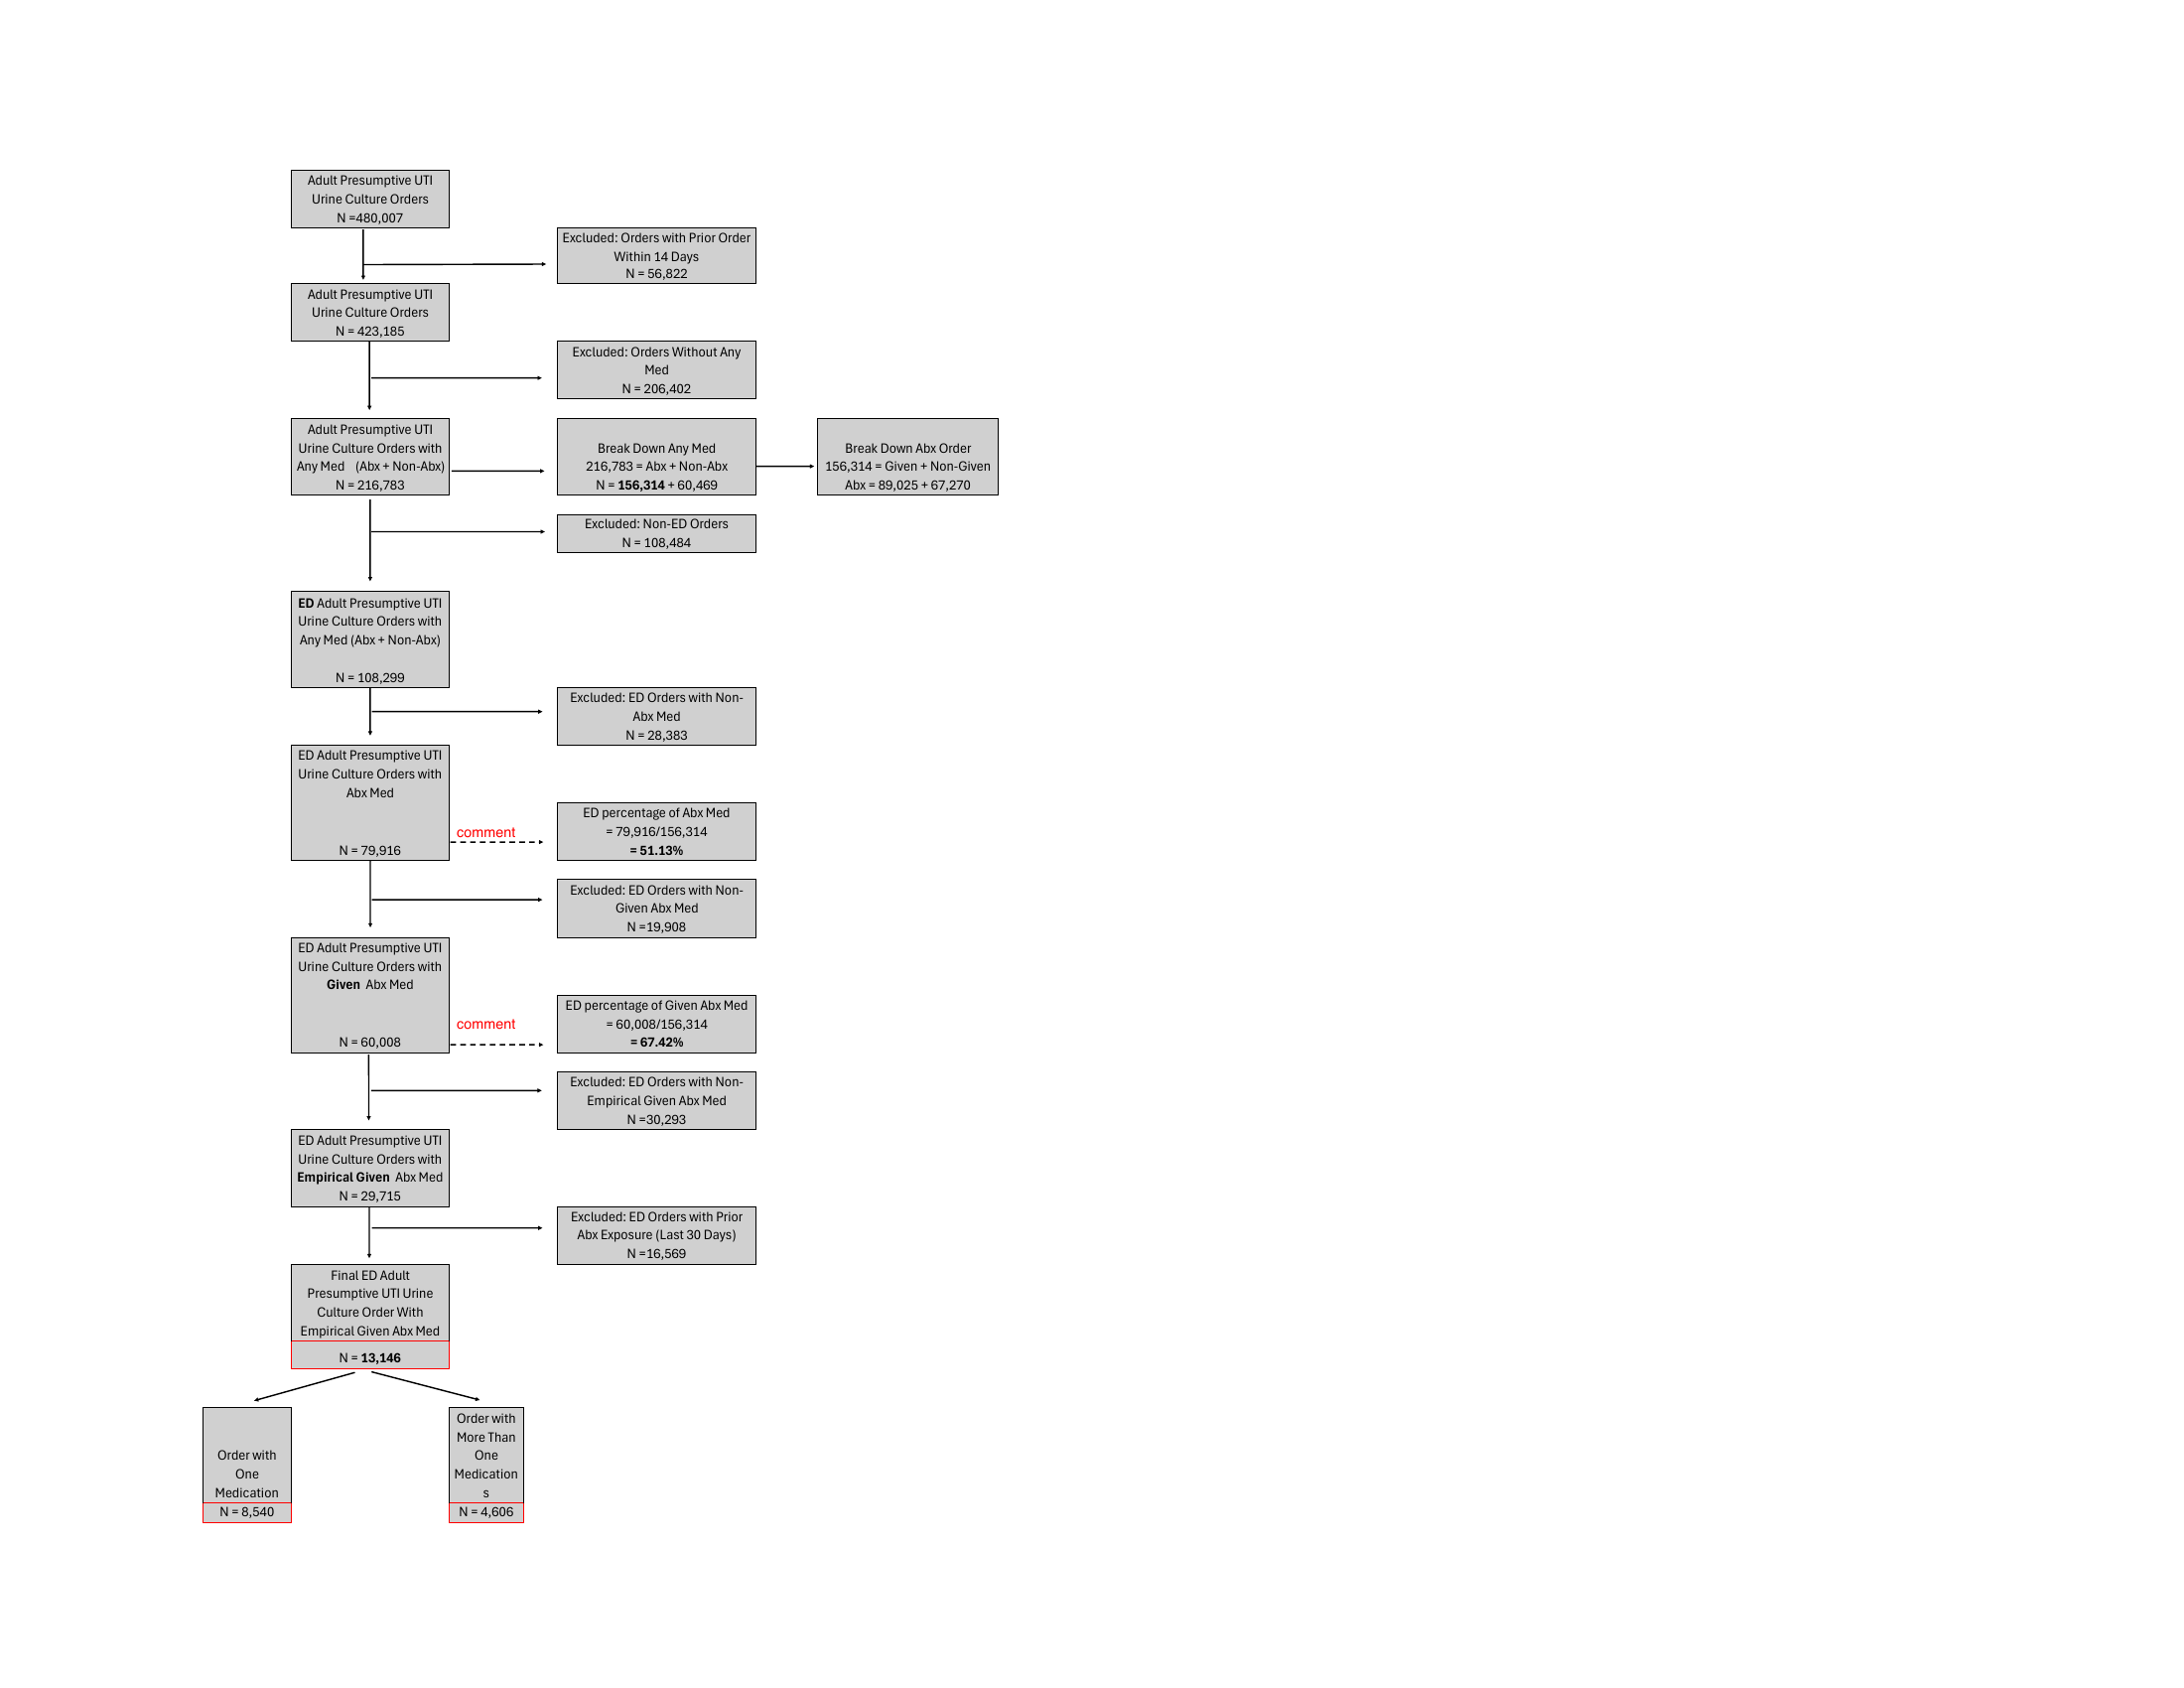

In [484]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/step6.png.png'
pages[8].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

## ⏳ Cleaning the medication name

In [450]:
import ast
def convert_to_list_and_keep_longest(value):
    # 1) Convert string -> list if possible
    if isinstance(value, str):
        try:
            value = ast.literal_eval(value)
        except:
            # If parsing fails, just keep the original value
            pass
    
    # 2) If the value is now a non-empty list, return the longest item
    if isinstance(value, list) and value:
        return max(value, key=len)
    
    # Otherwise, return the value as-is
    return value

# Apply the function to your column
final_cohort["final_antibiotic"] = final_cohort["cleaned_antibiotic"].apply(convert_to_list_and_keep_longest).replace(cleaning_mapping)

In [121]:
final_cohort.to_csv('../csv_folder/final_cohort.csv', index=False)

In [486]:
final_cohort = final_cohort.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', 'final_antibiotic'], keep='first', inplace=False)
group_counts = final_cohort.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['final_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= final_cohort[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

print("the unique order number for final_cohort is {}".format(find_unique_orders(final_cohort)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 13146
the unique order number from final cohort that has more than one medication is 3662


<Axes: title={'center': 'Number of Unique Urine Culture Orders per Year'}, xlabel='Year', ylabel='Number of Orders'>

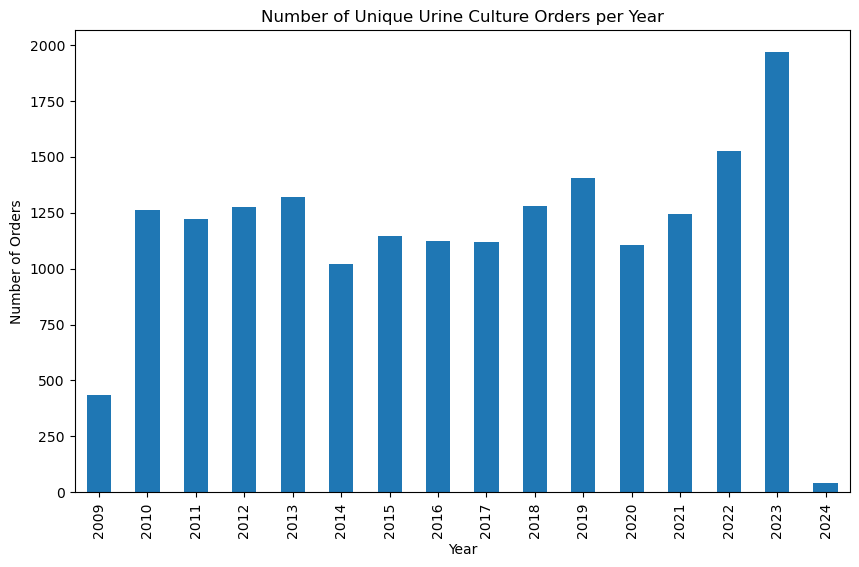

In [542]:
final_cohort["order_time_jittered_utc"].dt.year.value_counts().sort_index().plot(kind='bar', title='Number of Unique Urine Culture Orders per Year', xlabel='Year', ylabel='Number of Orders', figsize=(10, 6))

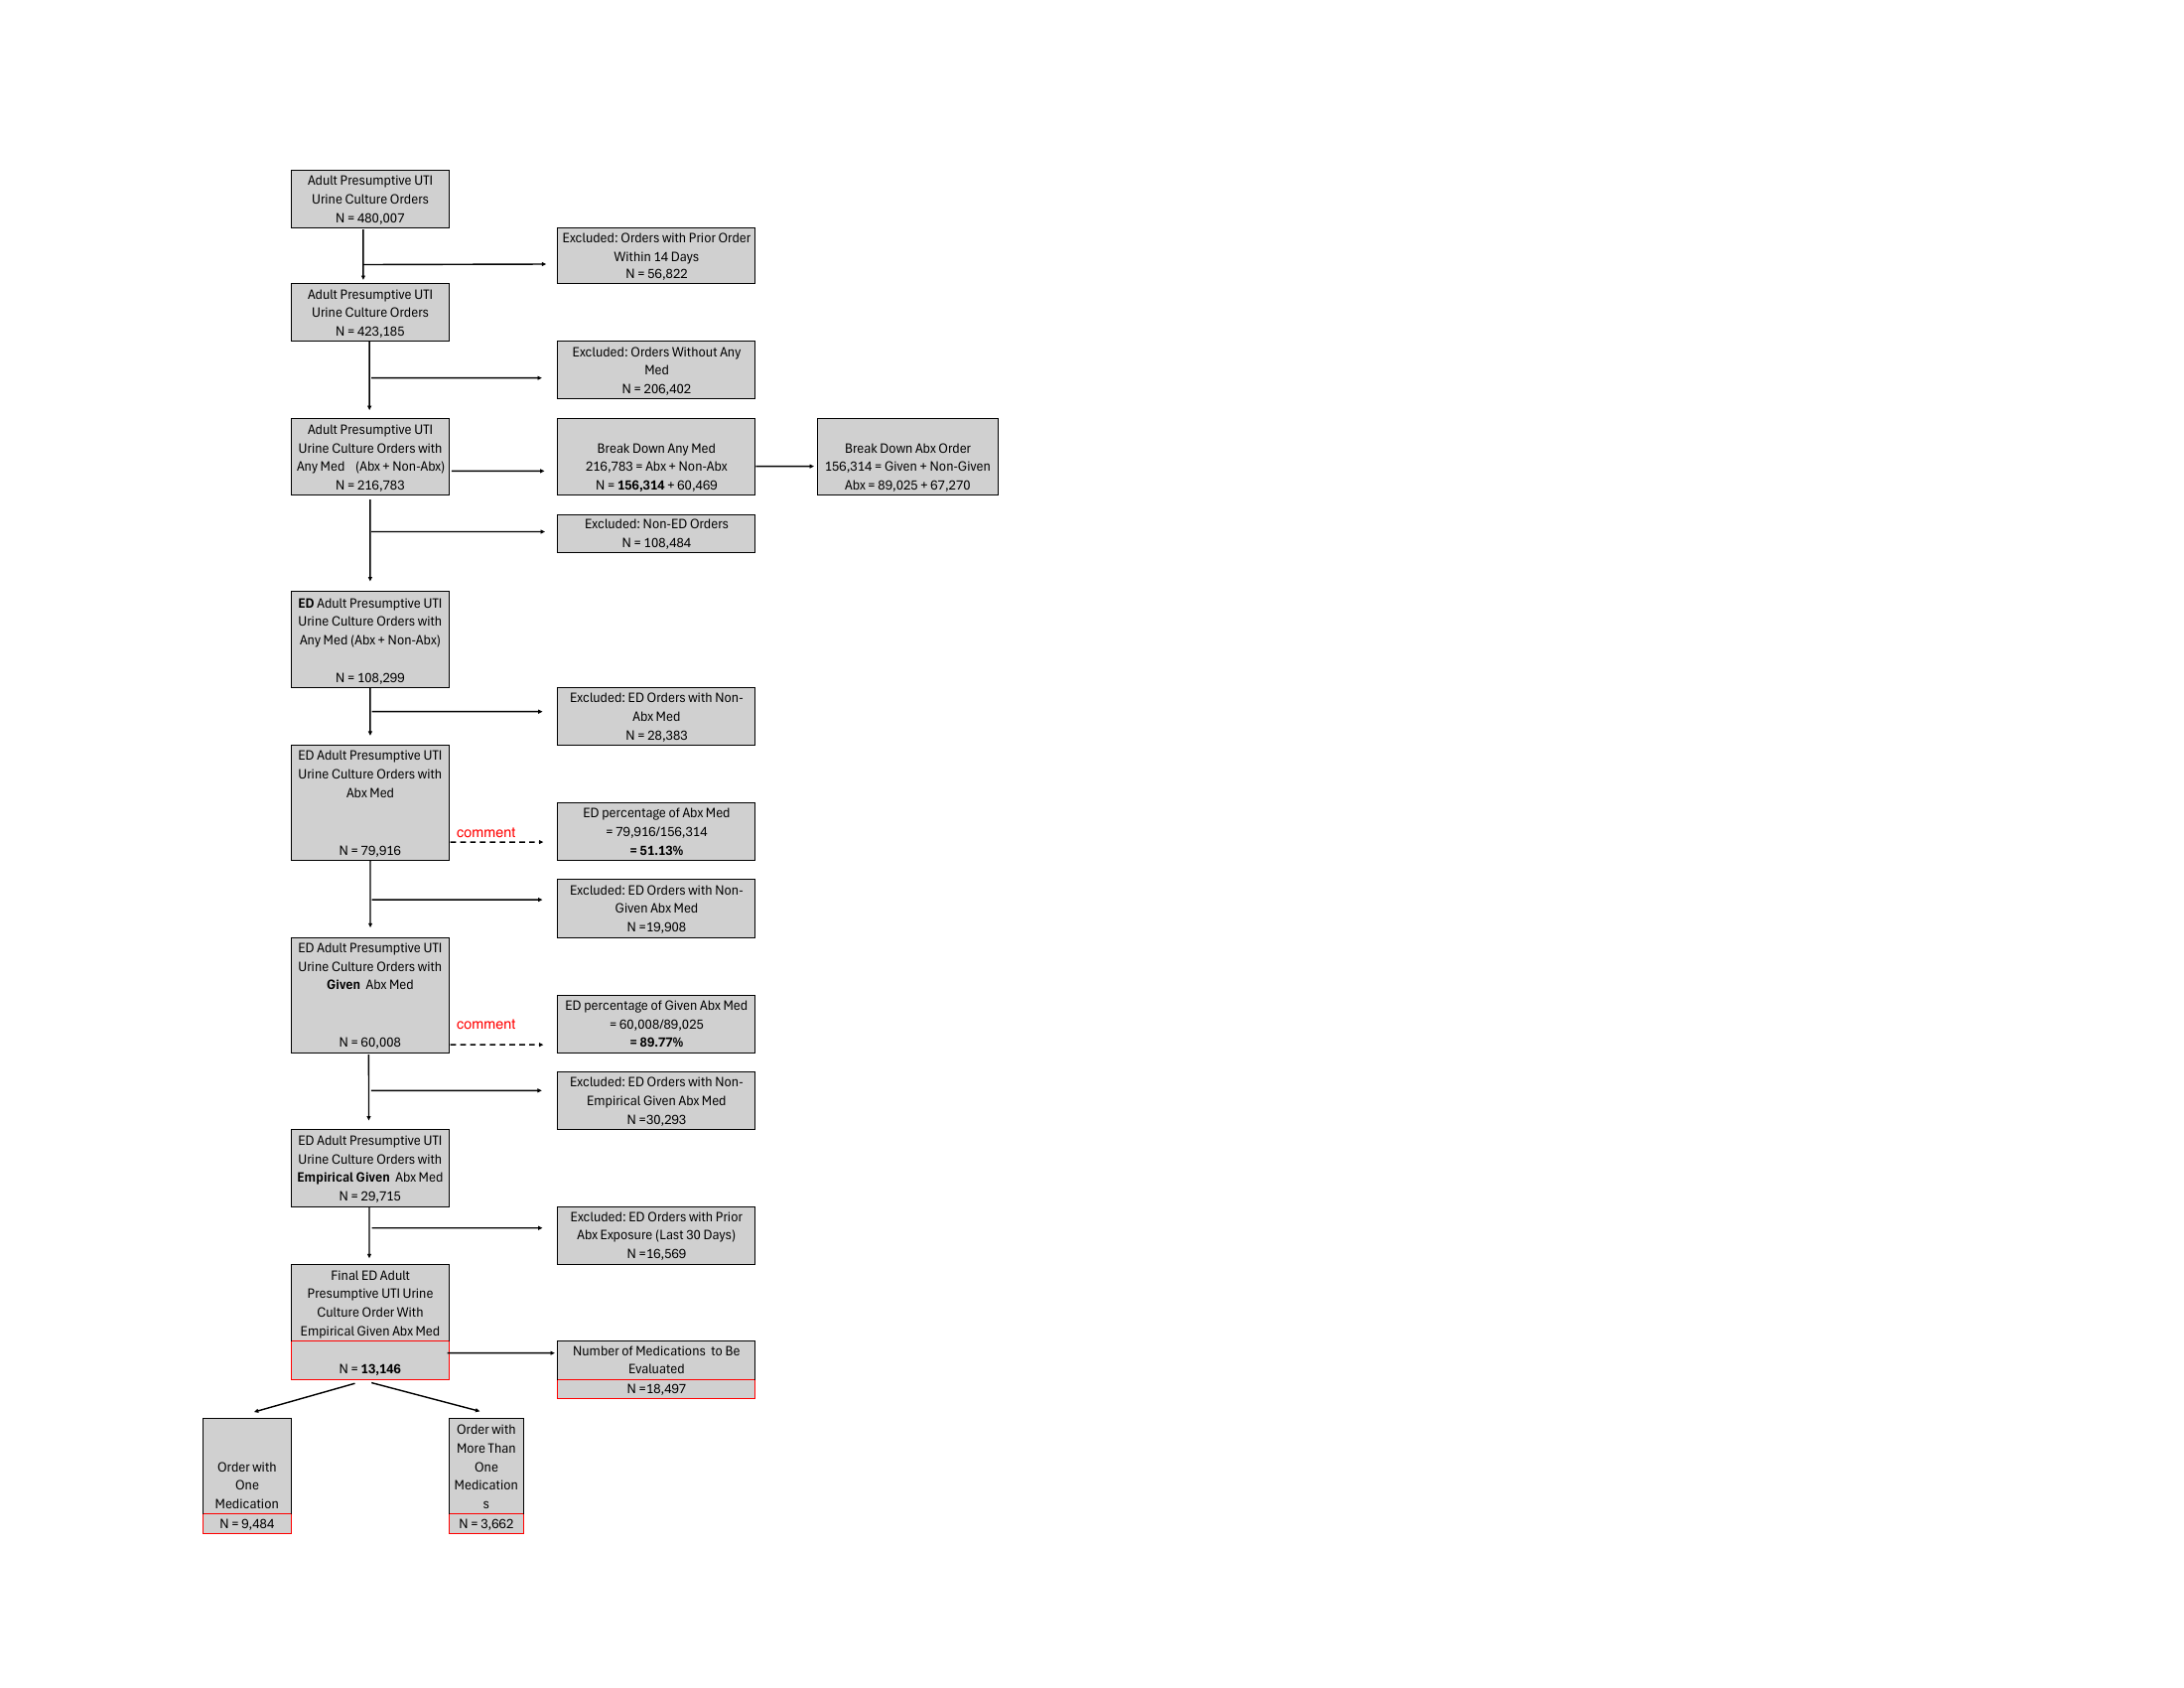

In [488]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom.pdf', dpi=200)
path_png = 'imgs/final_step.png.png'
pages[9].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [230]:
# read impliced_susceptibility rules
implied_suspectibility = pd.read_csv('../csv_folder/implied_susceptibility_rules.csv')

# Include implied-susceptibility rules

Step 1: Check for inherent resistance

In [451]:
import re
with_implied_susceptibility_starting_cohort = starting_cohort.copy()
with_implied_susceptibility_starting_cohort["susceptibility_source"] = "original"
# Get unique organisms from implied_susceptibility
bacteria = implied_suspectibility["Organism"].dropna().unique().tolist()

# Create regex pattern and find matches
pattern = '|'.join([re.escape(org) for org in bacteria])
matches = with_implied_susceptibility_starting_cohort["organism"].str.contains(pattern, case=False, na=False)

# Add a new column showing WHICH organism was matched
def find_matched_organism(org_name):
    org_name = str(org_name).upper()
    for bact in bacteria:
        if re.search(re.escape(bact), org_name, re.IGNORECASE):
            return bact
    return None

with_implied_susceptibility_starting_cohort['matched_organism'] \
    = with_implied_susceptibility_starting_cohort['organism'].apply(find_matched_organism)


In [452]:
# Step 2: Join with our starting cohort on matched organisms
inherent_resistance = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].isna()
][['Organism', 'Antibiotic']].drop_duplicates()
resistant_to_add = pd.merge(
    with_implied_susceptibility_starting_cohort[['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'result_time_jittered_utc', 'ordering_mode',
       'culture_description', 'was_positive', 'organism', "matched_organism"]].drop_duplicates(),
    inherent_resistance,
    left_on='matched_organism',
    right_on='Organism',
    how='inner'
)
resistant_to_add = resistant_to_add.rename(columns={'Antibiotic': 'antibiotic'})
resistant_to_add['susceptibility'] = 'Resistant'
resistant_to_add['susceptibility_source'] = 'inherent_resistance'
cols_to_keep = with_implied_susceptibility_starting_cohort.columns
added_resistant_cohort = (pd.concat([
    with_implied_susceptibility_starting_cohort,
    resistant_to_add[cols_to_keep]
], ignore_index=True))\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')\
    .sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])# Keeps our new resistant records if duplicates exist

In [236]:
# duplicate_check = added_resistant_cohort.duplicated(
#     subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
#             'organism', 'antibiotic', 'susceptibility'],
#     keep=False  # Mark all duplicates as True
# )

# # Step 2: Create a separate dataframe with just duplicates
# duplicates_df = added_resistant_cohort[duplicate_check].sort_values(
#     by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
#         'organism', 'antibiotic', 'susceptibility']
# )

Step 2: Check for implied susceptibility

In [453]:
# Step 1: Get cases where Implied_Agent exists (not null)
implied_agent_rules = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].notna()
][['Organism', 'Antibiotic', 'Implied_Agent']].drop_duplicates()
implied_to_process = pd.merge(
    added_resistant_cohort.drop(columns = ['susceptibility_source']),
    implied_agent_rules,
    left_on=['matched_organism', 'antibiotic'],
    right_on=['Organism', 'Implied_Agent'],
    how='inner'
).rename(columns={'antibiotic': 'antibiotic_to_drop', 'Antibiotic': 'antibiotic'}).drop(columns =['antibiotic_to_drop', 'Organism', 'Implied_Agent'])
implied_to_process['susceptibility_source'] = 'implied'
cols_to_keep = added_resistant_cohort.columns
final_implied_cohort = (pd.concat([
    added_resistant_cohort,
    implied_to_process[cols_to_keep]
], ignore_index=True)).sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')

In [288]:
final_implied_cohort.to_csv('../csv_folder/final_implied_cohort.csv', index=False)

In [454]:
merged_culture_med = final_cohort.drop(columns = ["cleaned_antibiotic"]).merge(final_implied_cohort, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', 'result_time_jittered_utc'], how='inner')

In [281]:
merged_culture_med.to_csv('../csv_folder/merged_culture_med_analysis.csv', index=False)

In [455]:
print("while the unique culture order is {}, the number of medication to evaluate is {}".format(find_unique_orders(final_cohort), len(final_cohort)))

while the unique culture order is 13146, the number of medication to evaluate is 18497


In [373]:
# negative rate
10067/18497, 8430/18497

(0.5442504189868628, 0.4557495810131373)

In [ ]:
# Incorporate antibiotic ranking to  both prescribe and tested antibioti

In [468]:
%%bigquery --use_rest_api aim_4_antibiotic_ranking
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_copy.aim_4_antibiotic_ranking

Query is running:   0%|          |

Downloading:   0%|          |

In [541]:
final_implied_cohort

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,ordering_mode,culture_description,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism
0,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Cefazolin,Susceptible,original,ESCHERICHIA COLI
1,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Levofloxacin,Susceptible,original,ESCHERICHIA COLI
2,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Nitrofurantoin,Susceptible,original,ESCHERICHIA COLI
3,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Ciprofloxacin,Susceptible,original,ESCHERICHIA COLI
4,JC1000010,15404221,325204620,2008-05-12 03:14:00+00:00,2008-05-13 00:42:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Trimethoprim/Sulfamethoxazole,Susceptible,original,ESCHERICHIA COLI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171539,JC999998,15725437,326716282,2008-06-14 04:25:00+00:00,2008-06-16 01:34:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Ceftazidime,Susceptible,implied,ESCHERICHIA COLI
2171540,JC999998,15725437,326716282,2008-06-14 04:25:00+00:00,2008-06-16 01:34:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Cefotetan,Susceptible,implied,ESCHERICHIA COLI
2171541,JC999998,15725437,326716282,2008-06-14 04:25:00+00:00,2008-06-16 01:34:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Cefoxitin,Susceptible,implied,ESCHERICHIA COLI
2171542,JC999998,15725437,326716282,2008-06-14 04:25:00+00:00,2008-06-16 01:34:00+00:00,Outpatient,URINE,1,ESCHERICHIA COLI,Cefpodoxime,Susceptible,implied,ESCHERICHIA COLI


In [426]:
aim_4_antibiotic_ranking

,spectrum,antibiotic_agent,spectrum_ranking
0,Access - Narrow,Penicillin,1
1,Access - Narrow,Dicloxacillin,1
2,Access - Narrow,Ampicillin,1
3,Access - Narrow,Cephalexin,1
4,Access - Narrow,Cefazolin,1
...,...,...,...
57,Reserve,Linezolid,6
58,Reserve,Imipenem/Relebactam,6
59,Reserve,Daptomycin,6
60,Reserve,Quinupristin/Dalfopristin,6


In [469]:
with_prescribed_abx_rank_df = merged_culture_med.merge(aim_4_antibiotic_ranking, \
                                   left_on=['final_antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'presciribed_antibiotic_rank'})\
                                    .drop(columns = ['antibiotic_agent', 'spectrum'])
with_tested_and_prescribed_abx_rank_df = with_prescribed_abx_rank_df.merge(aim_4_antibiotic_ranking, \
                                   left_on=['antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'tested_antibiotic_rank'})\
                                        .drop(columns = ['antibiotic_agent', 'spectrum'])

In [470]:
negative_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 0]
positive_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 1]

In [458]:
negative_cohort["presciribed_antibiotic_rank"].value_counts().sort_index()
# negative_cohort["final_antibiotic"].value_counts().sort_index()

presciribed_antibiotic_rank
1     429
2    2133
3    4504
4     979
5     986
6      88
Name: count, dtype: Int64

In [467]:
positive_cohort

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,final_antibiotic,ordering_mode,culture_description,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism,presciribed_antibiotic_rank,tested_antibiotic_rank
0,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.0,Given,Ceftriaxone,Inpatient,URINE,1,ESCHERICHIA COLI,Nitrofurantoin,Susceptible,original,ESCHERICHIA COLI,3,2
1,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.0,Given,Ceftriaxone,Inpatient,URINE,1,ESCHERICHIA COLI,Gentamicin,Susceptible,original,ESCHERICHIA COLI,3,2
2,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.0,Given,Ceftriaxone,Inpatient,URINE,1,ESCHERICHIA COLI,Cefepime,Susceptible,original,ESCHERICHIA COLI,3,4
3,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.0,Given,Ceftriaxone,Inpatient,URINE,1,ESCHERICHIA COLI,Ampicillin,Susceptible,original,ESCHERICHIA COLI,3,1
4,JC1000441,131191612156,499016548,2016-07-09 06:48:00+00:00,2016-07-11 16:17:00+00:00,2016-07-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,499028116.0,Given,Ceftriaxone,Inpatient,URINE,1,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Susceptible,original,ESCHERICHIA COLI,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165935,JC997480,131224771962,522307711,2017-05-09 10:50:00+00:00,2017-05-11 16:53:00+00:00,2017-05-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,522308710.0,Given,Ceftriaxone,Inpatient,URINE,1,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,original,KLEBSIELLA,3,3
165936,JC997480,131224771962,522307711,2017-05-09 10:50:00+00:00,2017-05-11 16:53:00+00:00,2017-05-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,522308710.0,Given,Ceftriaxone,Inpatient,URINE,1,KLEBSIELLA PNEUMONIAE,Gentamicin,Susceptible,original,KLEBSIELLA,3,2
165937,JC997480,131224771962,522307711,2017-05-09 10:50:00+00:00,2017-05-11 16:53:00+00:00,2017-05-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,522308710.0,Given,Ceftriaxone,Inpatient,URINE,1,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,original,KLEBSIELLA,3,5
165938,JC997480,131224771962,522307711,2017-05-09 10:50:00+00:00,2017-05-11 16:53:00+00:00,2017-05-09 07:00:00+00:00,CEFTRIAXONE 1 GRAM INJ SOLR,522308710.0,Given,Ceftriaxone,Inpatient,URINE,1,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,original,KLEBSIELLA,3,3


In [459]:
positive_cohort["tested_antibiotic_rank"].value_counts().sort_index()

tested_antibiotic_rank
1    18165
2    45806
3    56201
4    13973
5    17744
6     2572
Name: count, dtype: Int64

In [471]:
def evaluate_antibiotic_appropriateness(group):
    # Get all tested antibiotics with their susceptibility and ranking
    tested_abx = group[['antibiotic', 'susceptibility', 'tested_antibiotic_rank']].drop_duplicates()
    
    # Get the prescribed antibiotic
    prescribed_abx = group['final_antibiotic'].iloc[0]
    prescribed_rank = group['presciribed_antibiotic_rank'].iloc[0]
    
    # Scenario 1: Appropriate (susceptible and minimal rank)
    susceptible_tested = tested_abx[tested_abx['susceptibility'] == 'Susceptible']
    if not susceptible_tested.empty:
        min_rank = susceptible_tested['tested_antibiotic_rank'].min()
        if prescribed_abx in susceptible_tested['antibiotic'].values:
            if prescribed_rank == min_rank:
                return pd.Series({
                    'scenario': 'appropriate',
                    'ranking_diff': 0,
                    'min_susceptible_test_rank': min_rank,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 2: Too broad (susceptible but not minimal rank)
            else:
                return pd.Series({
                    'scenario': 'too_broad',
                    'ranking_diff': prescribed_rank - min_rank,
                    'min_susceptible_test_rank': min_rank,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 3: Resistant (non-susceptible)
    if prescribed_abx in group['antibiotic'].values:
        prescribed_susceptibility = group[group['antibiotic'] == prescribed_abx]['susceptibility'].iloc[0]
        if prescribed_susceptibility != 'Susceptible':
            return pd.Series({
                'scenario': 'resistant',
                'ranking_diff': None,
                'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
                'prescribed_rank': prescribed_rank
            })
    
    # Scenario 4: Not performed
    return pd.Series({
        'scenario': 'not_performed',
        'ranking_diff': None,
        'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
        'prescribed_rank': prescribed_rank
    })

# Apply to each group
results = positive_cohort.groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
]).apply(evaluate_antibiotic_appropriateness).reset_index()

# Merge results back with original data
final_cohort_with_evaluation = positive_cohort.merge(
    results,
    on=["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"]
)

In [347]:
final_cohort_with_evaluation.drop(columns = ['medication_action', 'ordering_mode', 'culture_description','order_med_id_coded'], inplace=True)

In [447]:
final_cohort_with_evaluation[final_cohort_with_evaluation["scenario"] == "not_performed"]["final_antibiotic"].value_counts().sort_values(ascending=False)


final_antibiotic
Cephalexin                       12508
Vancomycin                        6043
Ceftriaxone                       5100
Metronidazole                     3946
Azithromycin                      3369
Doxycycline                       1296
Piperacillin/Tazobactam           1242
Rifaximin                         1081
Amoxicillin/Clavulanic Acid        915
Cefdinir                           900
Amoxicillin                        829
Meropenem                          519
Clindamycin                        514
Cefpodoxime                        494
Cefepime                           489
Linezolid                          438
Trimethoprim                       405
Erythromycin                       368
Moxifloxacin                       353
Fosfomycin                         337
Silver Sulfadiazine                330
Aztreonam                          327
Trimethoprim/Sulfamethoxazole      326
Ertapenem                          224
Fidaxomicin                        200
Ciproflo

In [437]:
import random
grouped = final_cohort_with_evaluation[final_cohort_with_evaluation["scenario"] == "not_performed"].groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
])
# Randomly pick a group
random_group = random.choice(list(grouped.groups.keys()))
print(f"Randomly picked group: {random_group}")
# Build a boolean filter from the group key
filt = (
    (final_cohort_with_evaluation["anon_id"] == random_group[0]) &
    (final_cohort_with_evaluation["pat_enc_csn_id_coded"] == random_group[1]) &
    (final_cohort_with_evaluation["order_proc_id_coded"] == random_group[2]) &
    (final_cohort_with_evaluation["order_time_jittered_utc"] == random_group[3]) &
    (final_cohort_with_evaluation["result_time_jittered_utc"] == random_group[4]) &
    (final_cohort_with_evaluation["final_antibiotic"] == random_group[5])
)
final_cohort_with_evaluation[filt]


Randomly picked group: ('JC1551429', 131024880999, 420670653, Timestamp('2013-05-19 05:12:00+0000', tz='UTC'), Timestamp('2013-05-23 16:14:00+0000', tz='UTC'), 'Metronidazole')


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,final_antibiotic,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism,presciribed_antibiotic_rank,tested_antibiotic_rank,scenario,ranking_diff,min_susceptible_test_rank,prescribed_rank
28352,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Cefepime,Intermediate,original,None,2,4,not_performed,NaN,2.0,2
28353,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Piperacillin/Tazobactam,Susceptible,original,None,2,4,not_performed,NaN,2.0,2
28354,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Tobramycin,Susceptible,original,None,2,5,not_performed,NaN,2.0,2
28355,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Levofloxacin,Resistant,original,None,2,3,not_performed,NaN,2.0,2
28356,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Trimethoprim/Sulfamethoxazole,Susceptible,original,None,2,2,not_performed,NaN,2.0,2
28357,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Aztreonam,Resistant,original,None,2,6,not_performed,NaN,2.0,2
28358,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Ciprofloxacin,Resistant,original,None,2,3,not_performed,NaN,2.0,2
28359,JC1551429,131024880999,420670653,2013-05-19 05:12:00+00:00,2013-05-23 16:14:00+00:00,2013-05-21 07:00:00+00:00,METRONIDAZOLE IN NACL (ISO-OS) 500 MG/100 ML I...,Metronidazole,1,NONFERMENTING GRAM NEGATIVE RODS - UNIDENTIFIED,Gentamicin,Susceptible,original,None,2,2,not_performed,NaN,2.0,2


In [374]:
results["scenario"].value_counts()

scenario
too_broad        4516
not_performed    2810
resistant         746
appropriate       358
Name: count, dtype: int64

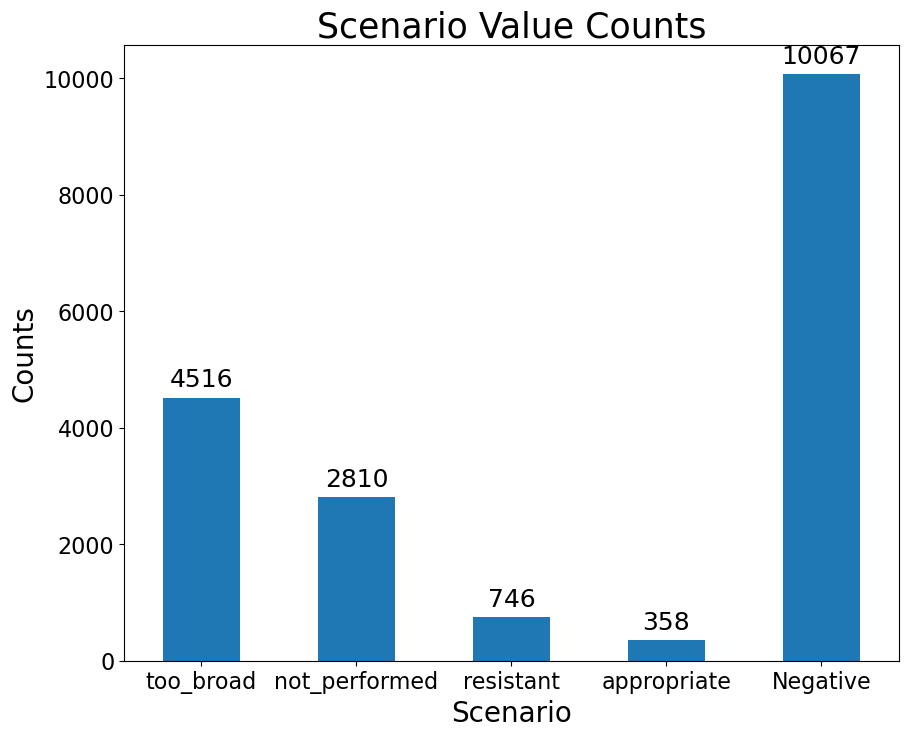

In [407]:
plt.figure(figsize=(10, 8))
# 1) Get the scenario counts as a Series
scenario_counts = results["scenario"].value_counts()

# 2) Append your extra row
scenario_counts.loc["Negative"] = 10067  # or scenario_counts["Extra Bar"] = 10067

# 3) Plot in one step
ax = scenario_counts.plot(
    kind='bar',
    title='Scenario Value Counts',
    xlabel='Scenario',
    ylabel='Counts',
    rot=0,  # rotate x-labels if desired
    fontsize=16, # increase the font size for labels
)
ax.set_title('Scenario Value Counts', fontsize=25)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add count numbers on top of each bar
for i, count in enumerate(scenario_counts):
    ax.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=18)

plt.show()

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_56375/3388665088.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = scenario_percentages[i]


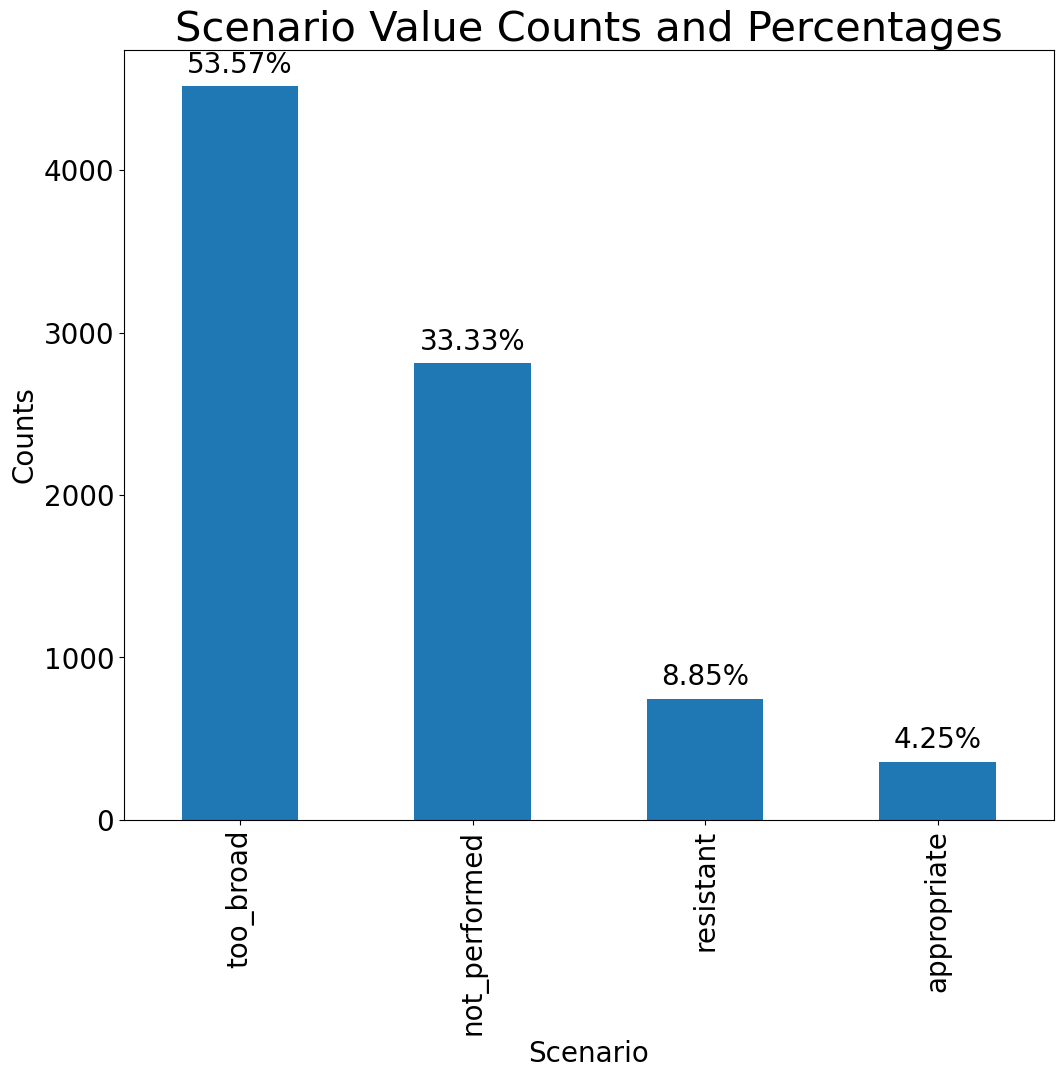

In [409]:
plt.figure(figsize=(12, 10))
# Plot the existing scenario value counts
# Calculate the percentage
scenario_counts = results["scenario"].value_counts()
scenario_percentages = (scenario_counts / scenario_counts.sum()) * 100

# Plot the counts
ax = scenario_counts.plot(kind='bar', title='Scenario Value Counts and Percentages', xlabel='Scenario', ylabel='Counts', fontsize=20)
ax.set_title('Scenario Value Counts and Percentages', fontsize=30)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add percentages on top of the bars
for i, count in enumerate(scenario_counts):
    percentage = scenario_percentages[i]
    ax.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=20)
# ax = results["scenario"].value_counts().plot(kind='bar', title='Scenario Value Counts', xlabel='Scenario', ylabel='Counts')


# Show the plot
plt.show()

In [375]:
results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

ranking_diff
1.0    1318
2.0    2661
3.0     371
4.0     146
5.0      20
Name: count, dtype: int64

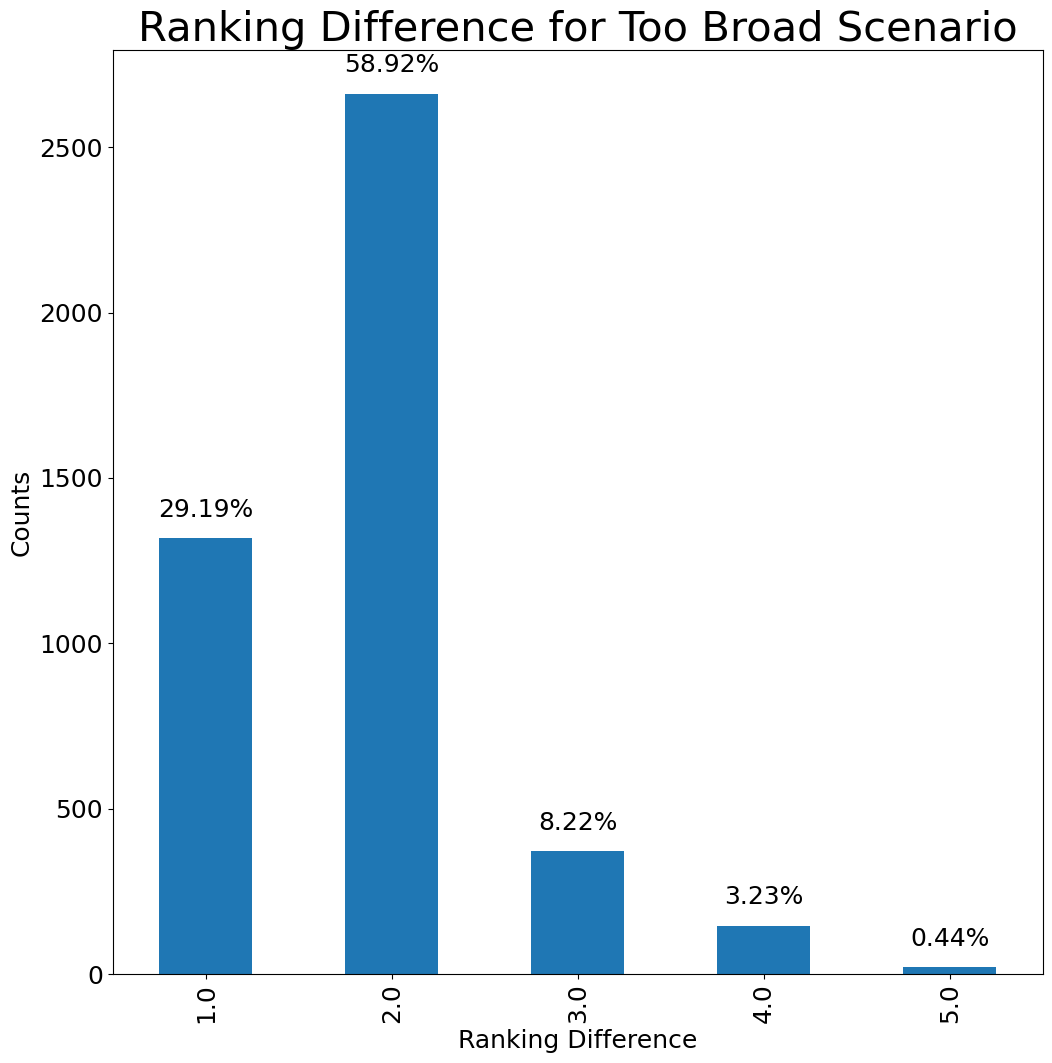

In [417]:
plt.figure(figsize=(12, 12))
ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

# Calculate the percentage
ranking_diff_percentages = (ranking_diff_counts / ranking_diff_counts.sum()) * 100

# Plot the counts
ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', fontsize=18)
ax.set_title('Ranking Difference for Too Broad Scenario', fontsize=30)
ax.set_xlabel("Ranking Difference", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)

# Add percentages on top of the bars
for i, count in enumerate(ranking_diff_counts):
    percentage = ranking_diff_percentages[i+1]
    ax.text(i, count + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=18)
plt.show()
# ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()
# ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', xlabel='Ranking Difference', ylabel='Counts')


In [448]:
starting_cohort[starting_cohort["antibiotic"].fillna("").str.contains("Cephalexin")]["antibiotic"].value_counts()

antibiotic
Cephalexin/Cephalothin    181
Name: count, dtype: int64

In [489]:
results.to_csv('../csv_folder/antibiotic_appropriateness.csv', index=False)